# Predicting Hospital Discharge Outcomes

In this code, we will explore a dataset of patient hospital discharge outcomes as a function of the treatment they receive. We will then examine the business value of the predictive model for UVA Hospital. Finally, we learn how to use cost-sensitive training to maximize the business value of the predictive model.

## 1. Import packages

First, we will import our normal selection of packages. However, this time, we will be importing the classification version of the models we've been using. These will have different names, but generally, the parameters will be identical or nearly so.

In [1]:
import numpy as np # Library for math operations
import pandas as pd # Library for data handling
import sklearn # The machine learning library we will be using in this entire course
from sklearn import tree # Tree function is used for visualizing decision tree
from sklearn.metrics import * 
# Importing function that can be used to calculate different metrics
from sklearn.tree import DecisionTreeClassifier # Importing Decision Tree Classifier 
from sklearn.ensemble import RandomForestClassifier  # Importing Random Forest Classifier 
from sklearn.model_selection import train_test_split # Importing function that can split a dataset into training and testing set
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler # Importing function for scaling the data
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV # Importing GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier # Importing the XGBoost Classifier 
import matplotlib.pyplot as plt # Importing the package for plotting
plt.style.use('fivethirtyeight') # Use the styling from FiveThirtyEight Website
import seaborn as sns # Importing another package for plotting
from sklearn.pipeline import Pipeline
from custom_functions import plot_conf_mat, plot_roc_curve, plot_feature_importance, calculateMetricsAndPrint

## 2. Load the Data

In [2]:
trainInput = pd.read_csv("DischargeTrain.csv")
testInput = pd.read_csv("DischargeTest.csv")

In [3]:
trainInput.head(2)

,Unique_Patient_Encounter_ID,Discharge_Type,Unique_Patient_ID,Sex,Marital_Status,Payment_Class,Previous_Discharge_Type,Age,ReadmissionCount,Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx),...,Subacute/SNF vs HHPT pending progress+First*(PTValue),Script given to CM+First*(PTValue),Long Term Acute Care Hospital+First*(PTValue),Home with nearly 24/7+First*(PTValue),Home with initial 24/7+First*(PTValue),Outpatient Cardiac rehab+First*(PTValue),Outpatient Pulmonary rehab+First*(PTValue),Hospice+First*(PTValue),AMPAC_Raw_Score,AMPAC_Scaled_Score
0,33434057,Home Health Agency,298873,Female,Single,Medicare Replacement,NaN,54,1,0,...,0,0,0,0,0,0,0,0,0,0
1,38150727,Infusion / Home,165661,Male,Divorced,Do not use,NaN,58,1,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
testInput.head(2)

,Unique_Patient_Encounter_ID,Discharge_Type,Unique_Patient_ID,Sex,Marital_Status,Payment_Class,Previous_Discharge_Type,Age,ReadmissionCount,Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx),...,Subacute/SNF vs HHPT pending progress+First*(PTValue),Script given to CM+First*(PTValue),Long Term Acute Care Hospital+First*(PTValue),Home with nearly 24/7+First*(PTValue),Home with initial 24/7+First*(PTValue),Outpatient Cardiac rehab+First*(PTValue),Outpatient Pulmonary rehab+First*(PTValue),Hospice+First*(PTValue),AMPAC_Raw_Score,AMPAC_Scaled_Score
0,37607139,Skilled Nursing Facility (SNF),227723,Female,Divorced,Medicare,NaN,89,0,10,...,0,0,0,0,0,0,0,0,18,0
1,34657024,Skilled Nursing Facility (SNF),188569,Female,Widowed,Medicare,NaN,80,0,0,...,0,0,0,0,0,0,0,0,16,0


Let's take a look at the shape of these dataframes.

In [5]:
trainInput.shape

(17435, 833)

In [6]:
testInput.shape

(5812, 833)

Before moving forward, we need to create our target variable. Our target variable should be equal to 1 if the discharge needs paperwork, and 0 otherwise. Let's take a look at the discharge types and then determine which ones require paperwork:

In [7]:
trainInput['Discharge_Type'].value_counts()

Discharge_Type
Home Health Agency                                        5696
HOME                                                      4790
Skilled Nursing Facility (SNF)                            3025
Acute Rehabilitation Facility (hospital or unit) (IRF)    1150
EXPIRED                                                    972
Infusion / Home                                            712
Long Term Care Hospital (LTCH)                             395
Hospice / Home                                             367
DIS TO LAW ENFORCE                                         166
AGAINST MED ADVICE                                         162
Name: count, dtype: int64

The types of discharge that require additional paperwork are `Skilled Nursing Facility (SNF)`, `Acute Rehabilitation Facility (hospital or unit) (IRF)`, and `Long Term Care Hospital (LTCH)`, so we will create a new variable which is `1` if any of those three are the discharge type or `0` if not.

In [8]:
trainInput['Requires_Paperwork'] = \
np.where(trainInput['Discharge_Type'].isin(['Skilled Nursing Facility (SNF)',
                                           'Acute Rehabilitation Facility (hospital or unit) (IRF)',
                                           'Long Term Care Hospital (LTCH)']),1,0)

trainInput['Requires_Paperwork'].value_counts()

Requires_Paperwork
0    12865
1     4570
Name: count, dtype: int64

In [9]:
testInput['Requires_Paperwork'] = \
np.where(testInput['Discharge_Type'].isin(['Skilled Nursing Facility (SNF)',
                                           'Acute Rehabilitation Facility (hospital or unit) (IRF)',
                                           'Long Term Care Hospital (LTCH)']),1,0)

testInput['Requires_Paperwork'].value_counts()

Requires_Paperwork
0    4267
1    1545
Name: count, dtype: int64

Now, we can go ahead and separate our x and y. Given that `Requires_Paperwork` is still fully correlated with our new y (`Requires_Paperwork`), we have to drop that as well. In addition, `Unique_Patient_Encounter_ID` and `Unique_Patient_ID` are unique identifiers and therefore there is no value in using them as predictors. So, we drop these columns too. Also, because our y values (labels) are already 0s and 1s, we don't need LabelEncode them anymore:

### Quick EDA

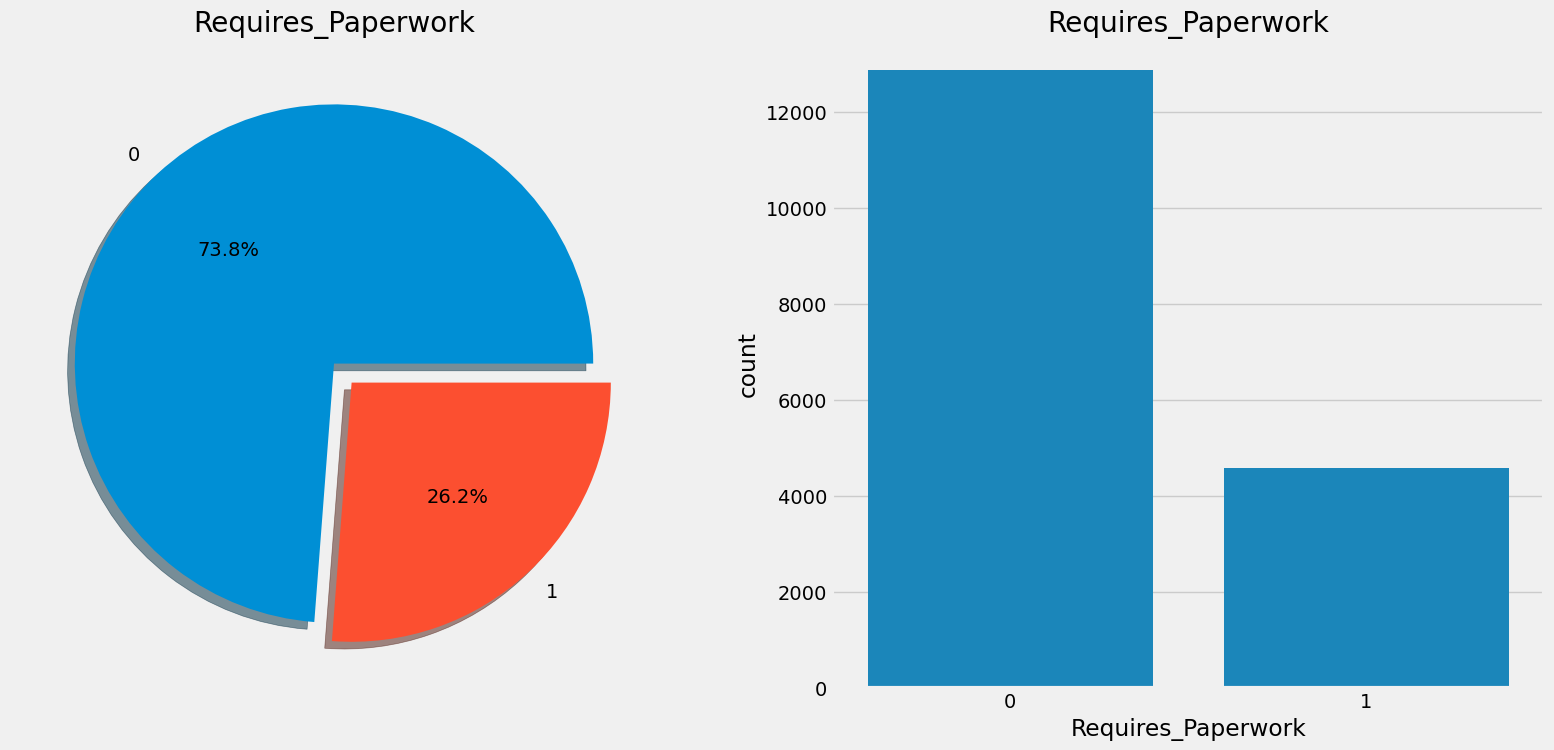

In [10]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot the pie chart
trainInput['Requires_Paperwork'].value_counts().plot.pie(
    explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True
)
ax[0].set_title('Requires_Paperwork')
ax[0].set_ylabel('')

# Plot the countplot
sns.countplot(x='Requires_Paperwork', data=trainInput, ax=ax[1])
ax[1].set_title('Requires_Paperwork')

plt.show()

In [11]:
# Get all columns except Requires_Paperwork
columns = [col for col in trainInput.columns if col != "Requires_Paperwork"]

# Loop through each column and display crosstab with background gradient
for col in columns:
    if trainInput[col].dtype == "object" or trainInput[col].nunique() < 10:  # Only for categorical/low unique value columns
        print(f"\n🔹 Crosstab: {col} vs Requires_Paperwork\n")
        
        # Compute crosstab
        crosstab = pd.crosstab(trainInput[col], trainInput["Requires_Paperwork"], margins=True)
        
        # Calculate the ratio of "Requires_Paperwork" = 1
        crosstab["Ratio_Requires_Paperwork"] = crosstab[1] / crosstab["All"]
        
        # Format the ratio column (reduce decimals)
        styled_crosstab = crosstab.style.background_gradient(cmap="summer_r") \
            .format({"Ratio_Requires_Paperwork": "{:.2%}"}) \
            .set_properties(**{"text-align": "center"}) \
            .set_table_styles([{"selector": "th", "props": [("text-align", "center")]}])
        
        # Display
        display(styled_crosstab)




🔹 Crosstab: Discharge_Type vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Discharge_Type,,,,
AGAINST MED ADVICE,162,0,162,0.00%
Acute Rehabilitation Facility (hospital or unit) (IRF),0,1150,1150,100.00%
DIS TO LAW ENFORCE,166,0,166,0.00%
EXPIRED,972,0,972,0.00%
HOME,4790,0,4790,0.00%
Home Health Agency,5696,0,5696,0.00%
Hospice / Home,367,0,367,0.00%
Infusion / Home,712,0,712,0.00%
Long Term Care Hospital (LTCH),0,395,395,100.00%



🔹 Crosstab: Sex vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Sex,,,,
Female,6536,2273,8809,25.80%
Male,6329,2297,8626,26.63%
All,12865,4570,17435,26.21%



🔹 Crosstab: Marital_Status vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Marital_Status,,,,
Divorced,1821,854,2675,31.93%
Legally Separated,440,118,558,21.15%
Married,6441,1844,8285,22.26%
Other,2,0,2,0.00%
Single,2742,739,3481,21.23%
Widowed,1419,1015,2434,41.70%
All,12865,4570,17435,26.21%



🔹 Crosstab: Payment_Class vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Payment_Class,,,,
Agencies,140,38,178,21.35%
Blue Shield,2140,346,2486,13.92%
Commercial,49,5,54,9.26%
Do not use,898,149,1047,14.23%
Grant,56,41,97,42.27%
Liability,57,48,105,45.71%
Medicaid,446,138,584,23.63%
Medicare,5175,2942,8117,36.24%
Medicare Managed Care,950,564,1514,37.25%



🔹 Crosstab: Previous_Discharge_Type vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Previous_Discharge_Type,,,,
AGAINST MED ADVICE,20,1,21,4.76%
Acute Rehabilitation Facility (hospital or unit) (IRF),95,162,257,63.04%
DIS TO LAW ENFORCE,44,1,45,2.22%
HOME,52,16,68,23.53%
Home Health Agency,1093,218,1311,16.63%
Hospice / Home,10,0,10,0.00%
Infusion / Home,197,11,208,5.29%
Long Term Care Hospital (LTCH),16,2,18,11.11%
SNF / Rehab,15,24,39,61.54%



🔹 Crosstab: Complications of pregnancy; childbirth; and the puerperium-Complications during labor+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Complications of pregnancy; childbirth; and the puerperium-Complications during labor+Count*(sk_dim_dx),,,,
0,12772,4570,17342,26.35%
1,77,0,77,0.00%
2,11,0,11,0.00%
3,2,0,2,0.00%
4,1,0,1,0.00%
6,1,0,1,0.00%
7,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Complications of pregnancy; childbirth; and the puerperium-Abortion-related disorders+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Complications of pregnancy; childbirth; and the puerperium-Abortion-related disorders+Count*(sk_dim_dx),,,,
0,12843,4570,17413,26.24%
1,10,0,10,0.00%
2,5,0,5,0.00%
3,4,0,4,0.00%
4,1,0,1,0.00%
5,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Injury and poisoning-Poisoning+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Injury and poisoning-Poisoning+Count*(sk_dim_dx),,,,
0,12661,4530,17191,26.35%
1,136,29,165,17.58%
2,41,6,47,12.77%
3,16,3,19,15.79%
4,6,0,6,0.00%
5,2,0,2,0.00%
6,0,2,2,100.00%
7,1,0,1,0.00%
8,2,0,2,0.00%



🔹 Crosstab: Diseases of the musculoskeletal system and connective tissue-Pathological fracture [207.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Diseases of the musculoskeletal system and connective tissue-Pathological fracture [207.]+Count*(sk_dim_dx),,,,
0,12722,4476,17198,26.03%
1,92,51,143,35.66%
2,22,24,46,52.17%
3,16,6,22,27.27%
4,7,8,15,53.33%
5,4,4,8,50.00%
6,2,0,2,0.00%
7,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Diseases of the nervous system and sense organs-Coma; stupor; and brain damage [85.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Diseases of the nervous system and sense organs-Coma; stupor; and brain damage [85.]+Count*(sk_dim_dx),,,,
0,12617,4460,17077,26.12%
1,158,75,233,32.19%
2,79,30,109,27.52%
3,8,4,12,33.33%
4,3,1,4,25.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Injury and poisoning-Crushing injury or internal injury [234.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Injury and poisoning-Crushing injury or internal injury [234.]+Count*(sk_dim_dx),,,,
0,12759,4526,17285,26.18%
1,53,22,75,29.33%
2,17,11,28,39.29%
3,12,6,18,33.33%
4,9,3,12,25.00%
5,6,0,6,0.00%
6,6,2,8,25.00%
7,1,0,1,0.00%
8,2,0,2,0.00%



🔹 Crosstab: Injury and poisoning-Sprains and strains [232.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Injury and poisoning-Sprains and strains [232.]+Count*(sk_dim_dx),,,,
0,12659,4505,17164,26.25%
1,128,51,179,28.49%
2,41,8,49,16.33%
3,18,3,21,14.29%
4,7,2,9,22.22%
5,6,1,7,14.29%
6,2,0,2,0.00%
8,1,0,1,0.00%
9,3,0,3,0.00%



🔹 Crosstab: Congenital anomalies-Genitourinary congenital anomalies [215.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Congenital anomalies-Genitourinary congenital anomalies [215.]+Count*(sk_dim_dx),,,,
0,12779,4538,17317,26.21%
1,48,21,69,30.43%
2,19,6,25,24.00%
3,10,2,12,16.67%
4,1,1,2,50.00%
5,4,2,6,33.33%
6,1,0,1,0.00%
7,2,0,2,0.00%
11,1,0,1,0.00%



🔹 Crosstab: Certain conditions originating in the perinatal period-Other perinatal conditions [224.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Certain conditions originating in the perinatal period-Other perinatal conditions [224.]+Count*(sk_dim_dx),,,,
0,12861,4569,17430,26.21%
1,3,1,4,25.00%
4,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Mental Illness-Disorders usually diagnosed in infancy childhood or adolescence [655]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Mental Illness-Disorders usually diagnosed in infancy childhood or adolescence [655]+Count*(sk_dim_dx),,,,
0,12829,4564,17393,26.24%
1,16,3,19,15.79%
2,9,2,11,18.18%
3,7,1,8,12.50%
4,1,0,1,0.00%
5,1,0,1,0.00%
14,1,0,1,0.00%
15,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Injury and poisoning-Superficial injury; contusion [239.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Injury and poisoning-Superficial injury; contusion [239.]+Count*(sk_dim_dx),,,,
0,12599,4449,17048,26.10%
1,177,80,257,31.13%
2,55,18,73,24.66%
3,13,6,19,31.58%
4,12,13,25,52.00%
5,7,3,10,30.00%
6,1,1,2,50.00%
8,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Mental Illness-Developmental disorders [654]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Mental Illness-Developmental disorders [654]+Count*(sk_dim_dx),,,,
0,12841,4556,17397,26.19%
1,15,7,22,31.82%
2,4,2,6,33.33%
3,1,2,3,66.67%
4,1,1,2,50.00%
5,1,2,3,66.67%
7,1,0,1,0.00%
8,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Certain conditions originating in the perinatal period-Liveborn [218.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Certain conditions originating in the perinatal period-Liveborn [218.]+Count*(sk_dim_dx),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Congenital anomalies-Digestive congenital anomalies [214.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Congenital anomalies-Digestive congenital anomalies [214.]+Count*(sk_dim_dx),,,,
0,12825,4559,17384,26.23%
1,28,11,39,28.21%
2,6,0,6,0.00%
3,2,0,2,0.00%
4,2,0,2,0.00%
5,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Certain conditions originating in the perinatal period-Short gestation; low birth weight; and fetal growth retardation [219.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Certain conditions originating in the perinatal period-Short gestation; low birth weight; and fetal growth retardation [219.]+Count*(sk_dim_dx),,,,
0,12864,4569,17433,26.21%
1,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Mental Illness-Impulse control disorders not elsewhere classified [656]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Mental Illness-Impulse control disorders not elsewhere classified [656]+Count*(sk_dim_dx),,,,
0,12844,4564,17408,26.22%
1,8,4,12,33.33%
2,6,1,7,14.29%
3,1,0,1,0.00%
4,0,1,1,100.00%
5,4,0,4,0.00%
6,1,0,1,0.00%
11,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Certain conditions originating in the perinatal period-Hemolytic jaundice and perinatal jaundice [222.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Certain conditions originating in the perinatal period-Hemolytic jaundice and perinatal jaundice [222.]+Count*(sk_dim_dx),,,,
0,12859,4569,17428,26.22%
1,6,1,7,14.29%
All,12865,4570,17435,26.21%



🔹 Crosstab: Diseases of the respiratory system-Aspiration pneumonitis; food/vomitus [129.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Diseases of the respiratory system-Aspiration pneumonitis; food/vomitus [129.]+Count*(sk_dim_dx),,,,
0,12718,4515,17233,26.20%
1,109,48,157,30.57%
2,25,5,30,16.67%
3,11,1,12,8.33%
4,1,1,2,50.00%
5,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Certain conditions originating in the perinatal period-Respiratory distress syndrome [221.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Certain conditions originating in the perinatal period-Respiratory distress syndrome [221.]+Count*(sk_dim_dx),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Certain conditions originating in the perinatal period-Intrauterine hypoxia and birth asphyxia [220.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Certain conditions originating in the perinatal period-Intrauterine hypoxia and birth asphyxia [220.]+Count*(sk_dim_dx),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Certain conditions originating in the perinatal period-Birth trauma [223.]+Count*(sk_dim_dx) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Certain conditions originating in the perinatal period-Birth trauma [223.]+Count*(sk_dim_dx),,,,
0,12864,4570,17434,26.21%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Analgesics-Narcotic-Opioid Agonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Analgesics-Narcotic-Opioid Agonists+Count(Med_Thera_Cls),,,,
0,5570,907,6477,14.00%
1,7295,3663,10958,33.43%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Analgesics-Nonnarcotic-Analgesics Other+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Analgesics-Nonnarcotic-Analgesics Other+Count(Med_Thera_Cls),,,,
0,6623,966,7589,12.73%
1,6242,3604,9846,36.60%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Analgesics-Nonnarcotic-Salicylates+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Analgesics-Nonnarcotic-Salicylates+Count(Med_Thera_Cls),,,,
0,8953,2308,11261,20.50%
1,3912,2262,6174,36.64%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Anti-Rheumatic-Nonsteroidal Anti-inflammatory Agents (NSAIDs)+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Anti-Rheumatic-Nonsteroidal Anti-inflammatory Agents (NSAIDs)+Count(Med_Thera_Cls),,,,
0,11164,3903,15067,25.90%
1,1701,667,2368,28.17%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Local Anesthetics-Parenteral-Local Anesthetics - Amides+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Local Anesthetics-Parenteral-Local Anesthetics - Amides+Count(Med_Thera_Cls),,,,
0,10354,3161,13515,23.39%
1,2511,1409,3920,35.94%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Cephalosporins-Cephalosporins - 1st Generation+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Cephalosporins-Cephalosporins - 1st Generation+Count(Med_Thera_Cls),,,,
0,9521,2634,12155,21.67%
1,3344,1936,5280,36.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Cephalosporins-Cephalosporins - 2nd Generation+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Cephalosporins-Cephalosporins - 2nd Generation+Count(Med_Thera_Cls),,,,
0,12691,4471,17162,26.05%
1,174,99,273,36.26%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Cephalosporins-Cephalosporins - 3rd Generation+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Cephalosporins-Cephalosporins - 3rd Generation+Count(Med_Thera_Cls),,,,
0,11556,3639,15195,23.95%
1,1309,931,2240,41.56%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Cephalosporins-Cephalosporins - 4th Generation+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Cephalosporins-Cephalosporins - 4th Generation+Count(Med_Thera_Cls),,,,
0,11625,3798,15423,24.63%
1,1240,772,2012,38.37%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Macrolide Antibiotics-Azithromycin+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Macrolide Antibiotics-Azithromycin+Count(Med_Thera_Cls),,,,
0,12243,4336,16579,26.15%
1,622,234,856,27.34%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Misc. Antiinfectives-Anti-infective Agents - Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Misc. Antiinfectives-Anti-infective Agents - Misc.+Count(Med_Thera_Cls),,,,
0,9110,2690,11800,22.80%
1,3755,1880,5635,33.36%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Misc. Antiinfectives-Anti-infective Misc. - Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Misc. Antiinfectives-Anti-infective Misc. - Combinations+Count(Med_Thera_Cls),,,,
0,12443,4320,16763,25.77%
1,422,250,672,37.20%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Penicillins-Aminopenicillins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Penicillins-Aminopenicillins+Count(Med_Thera_Cls),,,,
0,12732,4450,17182,25.90%
1,133,120,253,47.43%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Penicillins-Penicillin Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Penicillins-Penicillin Combinations+Count(Med_Thera_Cls),,,,
0,11647,3883,15530,25.00%
1,1218,687,1905,36.06%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Tetracyclines-Tetracyclines+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Tetracyclines-Tetracyclines+Count(Med_Thera_Cls),,,,
0,12738,4516,17254,26.17%
1,127,54,181,29.83%
All,12865,4570,17435,26.21%



🔹 Crosstab: Biological-Vaccines-Viral Vaccines+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Biological-Vaccines-Viral Vaccines+Count(Med_Thera_Cls),,,,
0,12356,4268,16624,25.67%
1,509,302,811,37.24%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antianxiety Agents-Benzodiazepines+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antianxiety Agents-Benzodiazepines+Count(Med_Thera_Cls),,,,
0,10916,3492,14408,24.24%
1,1949,1078,3027,35.61%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Corticosteroids-Glucocorticosteroids+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Corticosteroids-Glucocorticosteroids+Count(Med_Thera_Cls),,,,
0,10522,3463,13985,24.76%
1,2343,1107,3450,32.09%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Antacids-Antacids - Calcium Salts+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Antacids-Antacids - Calcium Salts+Count(Med_Thera_Cls),,,,
0,12505,4370,16875,25.90%
1,360,200,560,35.71%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Antacids-Antacids - Magnesium Salts+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Antacids-Antacids - Magnesium Salts+Count(Med_Thera_Cls),,,,
0,10214,2922,13136,22.24%
1,2651,1648,4299,38.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Antidiarrheals-Antidiarrheal Agents - Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Antidiarrheals-Antidiarrheal Agents - Misc.+Count(Med_Thera_Cls),,,,
0,12711,4482,17193,26.07%
1,154,88,242,36.36%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Antiemetics-5-HT3 Receptor Antagonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Antiemetics-5-HT3 Receptor Antagonists+Count(Med_Thera_Cls),,,,
0,8665,2319,10984,21.11%
1,4200,2251,6451,34.89%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Laxatives-Laxatives - Miscellaneous+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Laxatives-Laxatives - Miscellaneous+Count(Med_Thera_Cls),,,,
0,10127,2733,12860,21.25%
1,2738,1837,4575,40.15%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Laxatives-Lubricant Laxatives+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Laxatives-Lubricant Laxatives+Count(Med_Thera_Cls),,,,
0,12712,4447,17159,25.92%
1,153,123,276,44.57%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Laxatives-Stimulant Laxatives+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Laxatives-Stimulant Laxatives+Count(Med_Thera_Cls),,,,
0,7736,1515,9251,16.38%
1,5129,3055,8184,37.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Laxatives-Surfactant Laxatives+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Laxatives-Surfactant Laxatives+Count(Med_Thera_Cls),,,,
0,7595,1449,9044,16.02%
1,5270,3121,8391,37.19%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Misc. Gi-Antiflatulents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Misc. Gi-Antiflatulents+Count(Med_Thera_Cls),,,,
0,12369,4268,16637,25.65%
1,496,302,798,37.84%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Ulcer Drugs-H-2 Antagonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Ulcer Drugs-H-2 Antagonists+Count(Med_Thera_Cls),,,,
0,10476,3189,13665,23.34%
1,2389,1381,3770,36.63%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Ulcer Drugs-Proton Pump Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Ulcer Drugs-Proton Pump Inhibitors+Count(Med_Thera_Cls),,,,
0,9575,2712,12287,22.07%
1,3290,1858,5148,36.09%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Anticoagulants-Heparins And Heparinoid-Like Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Anticoagulants-Heparins And Heparinoid-Like Agents+Count(Med_Thera_Cls),,,,
0,6080,729,6809,10.71%
1,6785,3841,10626,36.15%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Hematopoietic Agents-Iron+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Hematopoietic Agents-Iron+Count(Med_Thera_Cls),,,,
0,12049,4020,16069,25.02%
1,816,550,1366,40.26%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Antidotes-Opioid Antagonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Antidotes-Opioid Antagonists+Count(Med_Thera_Cls),,,,
0,12160,4004,16164,24.77%
1,705,566,1271,44.53%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Antiseptics & Disinfectants-Chlorine Antiseptics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Antiseptics & Disinfectants-Chlorine Antiseptics+Count(Med_Thera_Cls),,,,
0,8657,1952,10609,18.40%
1,4208,2618,6826,38.35%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Antiseptics & Disinfectants-Iodine Antiseptics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Antiseptics & Disinfectants-Iodine Antiseptics+Count(Med_Thera_Cls),,,,
0,12799,4516,17315,26.08%
1,66,54,120,45.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Diagnostic Products-Radiographic Contrast Media+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Diagnostic Products-Radiographic Contrast Media+Count(Med_Thera_Cls),,,,
0,9829,2772,12601,22.00%
1,3036,1798,4834,37.19%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Medi-Span Reserved Or Unknown(95)-Alternative Medicine - M's+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Medi-Span Reserved Or Unknown(95)-Alternative Medicine - M's+Count(Med_Thera_Cls),,,,
0,11096,3269,14365,22.76%
1,1769,1301,3070,42.38%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Medi-Span Reserved Or Unknown(95)-Alternative Medicine Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Medi-Span Reserved Or Unknown(95)-Alternative Medicine Combinations+Count(Med_Thera_Cls),,,,
0,12864,4569,17433,26.21%
1,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Anticonvulsant-Anticonvulsants - Benzodiazepines+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Anticonvulsant-Anticonvulsants - Benzodiazepines+Count(Med_Thera_Cls),,,,
0,12535,4355,16890,25.78%
1,330,215,545,39.45%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Anticonvulsant-Anticonvulsants - Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Anticonvulsant-Anticonvulsants - Misc.+Count(Med_Thera_Cls),,,,
0,9383,2594,11977,21.66%
1,3482,1976,5458,36.20%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Antiparkinsonian-Antiparkinson Dopaminergics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Antiparkinsonian-Antiparkinson Dopaminergics+Count(Med_Thera_Cls),,,,
0,12640,4357,16997,25.63%
1,225,213,438,48.63%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Skeletal Muscle Relaxants-Central Muscle Relaxants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Skeletal Muscle Relaxants-Central Muscle Relaxants+Count(Med_Thera_Cls),,,,
0,11688,3778,15466,24.43%
1,1177,792,1969,40.22%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Minerals & Electrolytes-Electrolyte Mixtures+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Minerals & Electrolytes-Electrolyte Mixtures+Count(Med_Thera_Cls),,,,
0,10056,2908,12964,22.43%
1,2809,1662,4471,37.17%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Minerals & Electrolytes-Magnesium+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Minerals & Electrolytes-Magnesium+Count(Med_Thera_Cls),,,,
0,9965,2770,12735,21.75%
1,2900,1800,4700,38.30%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Minerals & Electrolytes-Phosphate+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Minerals & Electrolytes-Phosphate+Count(Med_Thera_Cls),,,,
0,10622,3165,13787,22.96%
1,2243,1405,3648,38.51%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Minerals & Electrolytes-Potassium+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Minerals & Electrolytes-Potassium+Count(Med_Thera_Cls),,,,
0,9104,2274,11378,19.99%
1,3761,2296,6057,37.91%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Minerals & Electrolytes-Sodium+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Minerals & Electrolytes-Sodium+Count(Med_Thera_Cls),,,,
0,4423,199,4622,4.31%
1,8442,4371,12813,34.11%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Multivitamins-Multiple Vitamins w/ Minerals+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Multivitamins-Multiple Vitamins w/ Minerals+Count(Med_Thera_Cls),,,,
0,11524,3595,15119,23.78%
1,1341,975,2316,42.10%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Multivitamins-Pediatric Multiple Vitamins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Multivitamins-Pediatric Multiple Vitamins+Count(Med_Thera_Cls),,,,
0,12830,4544,17374,26.15%
1,35,26,61,42.62%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Nutrients-Carbohydrates+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Nutrients-Carbohydrates+Count(Med_Thera_Cls),,,,
0,9787,2680,12467,21.50%
1,3078,1890,4968,38.04%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Vitamins-Oil Soluble Vitamins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Vitamins-Oil Soluble Vitamins+Count(Med_Thera_Cls),,,,
0,11861,3826,15687,24.39%
1,1004,744,1748,42.56%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Vitamins-Water Soluble Vitamins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Vitamins-Water Soluble Vitamins+Count(Med_Thera_Cls),,,,
0,11549,3699,15248,24.26%
1,1316,871,2187,39.83%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Antiasthmatic-Sympathomimetics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Antiasthmatic-Sympathomimetics+Count(Med_Thera_Cls),,,,
0,10479,3172,13651,23.24%
1,2386,1398,3784,36.95%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Antihistamines-Antihistamines - Ethanolamines+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Antihistamines-Antihistamines - Ethanolamines+Count(Med_Thera_Cls),,,,
0,11590,4054,15644,25.91%
1,1275,516,1791,28.81%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Antihistamines-Antihistamines - Non-Sedating+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Antihistamines-Antihistamines - Non-Sedating+Count(Med_Thera_Cls),,,,
0,12353,4333,16686,25.97%
1,512,237,749,31.64%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Decongestants-Nasal Agents - Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Decongestants-Nasal Agents - Misc.+Count(Med_Thera_Cls),,,,
0,12453,4303,16756,25.68%
1,412,267,679,39.32%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Antibiotics - Topical+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Antibiotics - Topical+Count(Med_Thera_Cls),,,,
0,12400,4287,16687,25.69%
1,465,283,748,37.83%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Antifungals - Topical+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Antifungals - Topical+Count(Med_Thera_Cls),,,,
0,12556,4274,16830,25.40%
1,309,296,605,48.93%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Antivirals - Topical+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Antivirals - Topical+Count(Med_Thera_Cls),,,,
0,12859,4568,17427,26.21%
1,6,2,8,25.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Corticosteroids - Topical+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Corticosteroids - Topical+Count(Med_Thera_Cls),,,,
0,12680,4471,17151,26.07%
1,185,99,284,34.86%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Emollients+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Emollients+Count(Med_Thera_Cls),,,,
0,12614,4338,16952,25.59%
1,251,232,483,48.03%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Enzymes - Topical+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Enzymes - Topical+Count(Med_Thera_Cls),,,,
0,12711,4379,17090,25.62%
1,154,191,345,55.36%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Liniments+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Liniments+Count(Med_Thera_Cls),,,,
0,12819,4538,17357,26.15%
1,46,32,78,41.03%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Local Anesthetics - Topical+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Local Anesthetics - Topical+Count(Med_Thera_Cls),,,,
0,10748,3223,13971,23.07%
1,2117,1347,3464,38.89%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Mouth & Throat (Local)-Anesthetics Topical Oral+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Mouth & Throat (Local)-Anesthetics Topical Oral+Count(Med_Thera_Cls),,,,
0,12322,4304,16626,25.89%
1,543,266,809,32.88%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Mouth & Throat (Local)-Antiseptics - Mouth/Throat+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Mouth & Throat (Local)-Antiseptics - Mouth/Throat+Count(Med_Thera_Cls),,,,
0,10606,3286,13892,23.65%
1,2259,1284,3543,36.24%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antidepressants-Serotonin-Norepinephrine Reuptake Inhibitors (SNRIs)+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antidepressants-Serotonin-Norepinephrine Reuptake Inhibitors (SNRIs)+Count(Med_Thera_Cls),,,,
0,12226,4138,16364,25.29%
1,639,432,1071,40.34%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Antiemetics-Antiemetics - Anticholinergic+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Antiemetics-Antiemetics - Anticholinergic+Count(Med_Thera_Cls),,,,
0,12000,4148,16148,25.69%
1,865,422,1287,32.79%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antihyperlipidemic-HMG CoA Reductase Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antihyperlipidemic-HMG CoA Reductase Inhibitors+Count(Med_Thera_Cls),,,,
0,9610,2337,11947,19.56%
1,3255,2233,5488,40.69%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Calcium Blockers-Calcium Channel Blockers+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Calcium Blockers-Calcium Channel Blockers+Count(Med_Thera_Cls),,,,
0,11088,3225,14313,22.53%
1,1777,1345,3122,43.08%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Misc. Antiinfectives-Lincosamides+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Misc. Antiinfectives-Lincosamides+Count(Med_Thera_Cls),,,,
0,12423,4334,16757,25.86%
1,442,236,678,34.81%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antianxiety Agents-Antianxiety Agents - Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antianxiety Agents-Antianxiety Agents - Misc.+Count(Med_Thera_Cls),,,,
0,12314,4236,16550,25.60%
1,551,334,885,37.74%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Beta Blockers-Alpha-Beta Blockers+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Beta Blockers-Alpha-Beta Blockers+Count(Med_Thera_Cls),,,,
0,11151,3212,14363,22.36%
1,1714,1358,3072,44.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Antidiabetic-Biguanides+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Antidiabetic-Biguanides+Count(Med_Thera_Cls),,,,
0,12695,4458,17153,25.99%
1,170,112,282,39.72%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Antidiabetic-Insulin+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Antidiabetic-Insulin+Count(Med_Thera_Cls),,,,
0,9062,2083,11145,18.69%
1,3803,2487,6290,39.54%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Corticosteroids-Mineralocorticoids+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Corticosteroids-Mineralocorticoids+Count(Med_Thera_Cls),,,,
0,12834,4541,17375,26.14%
1,31,29,60,48.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Laxatives-Saline Laxatives+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Laxatives-Saline Laxatives+Count(Med_Thera_Cls),,,,
0,10843,3008,13851,21.72%
1,2022,1562,3584,43.58%
All,12865,4570,17435,26.21%



🔹 Crosstab: Genitourinary Products-Misc. Genitourinary Products-Prostatic Hypertrophy Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Genitourinary Products-Misc. Genitourinary Products-Prostatic Hypertrophy Agents+Count(Med_Thera_Cls),,,,
0,12079,3924,16003,24.52%
1,786,646,1432,45.11%
All,12865,4570,17435,26.21%



🔹 Crosstab: Genitourinary Products-Urinary Antispasmodics-Urinary Antispasmodic - Antimuscarinics (Anticholinergic)+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Genitourinary Products-Urinary Antispasmodics-Urinary Antispasmodic - Antimuscarinics (Anticholinergic)+Count(Med_Thera_Cls),,,,
0,12731,4446,17177,25.88%
1,134,124,258,48.06%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Anticoagulants-Coumarin Anticoagulants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Anticoagulants-Coumarin Anticoagulants+Count(Med_Thera_Cls),,,,
0,12234,4117,16351,25.18%
1,631,453,1084,41.79%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Misc. Hematological-Plasma Proteins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Misc. Hematological-Plasma Proteins+Count(Med_Thera_Cls),,,,
0,11933,4039,15972,25.29%
1,932,531,1463,36.30%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Antihistamines-Antihistamines - Phenothiazines+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Antihistamines-Antihistamines - Phenothiazines+Count(Med_Thera_Cls),,,,
0,12302,4308,16610,25.94%
1,563,262,825,31.76%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Ophthalmic-Ophthalmics - Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Ophthalmic-Ophthalmics - Misc.+Count(Med_Thera_Cls),,,,
0,12796,4526,17322,26.13%
1,69,44,113,38.94%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Aminoglycosides-Aminoglycosides+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Aminoglycosides-Aminoglycosides+Count(Med_Thera_Cls),,,,
0,12624,4474,17098,26.17%
1,241,96,337,28.49%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Antifungals-Imidazole-Related Antifungals+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Antifungals-Imidazole-Related Antifungals+Count(Med_Thera_Cls),,,,
0,12354,4282,16636,25.74%
1,511,288,799,36.05%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Penicillins-Penicillinase-Resistant Penicillins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Penicillins-Penicillinase-Resistant Penicillins+Count(Med_Thera_Cls),,,,
0,12742,4494,17236,26.07%
1,123,76,199,38.19%
All,12865,4570,17435,26.21%



🔹 Crosstab: Biological-Toxoids-Toxoid Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Biological-Toxoids-Toxoid Combinations+Count(Med_Thera_Cls),,,,
0,12772,4499,17271,26.05%
1,93,71,164,43.29%
All,12865,4570,17435,26.21%



🔹 Crosstab: Biological-Vaccines-Bacterial Vaccines+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Biological-Vaccines-Bacterial Vaccines+Count(Med_Thera_Cls),,,,
0,12791,4519,17310,26.11%
1,74,51,125,40.80%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antihypertensive-Antiadrenergic Antihypertensives+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antihypertensive-Antiadrenergic Antihypertensives+Count(Med_Thera_Cls),,,,
0,12468,4243,16711,25.39%
1,397,327,724,45.17%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Diuretics-Loop Diuretics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Diuretics-Loop Diuretics+Count(Med_Thera_Cls),,,,
0,9916,2687,12603,21.32%
1,2949,1883,4832,38.97%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Diuretics-Potassium Sparing Diuretics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Diuretics-Potassium Sparing Diuretics+Count(Med_Thera_Cls),,,,
0,12504,4382,16886,25.95%
1,361,188,549,34.24%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Pressors-Vasopressors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Pressors-Vasopressors+Count(Med_Thera_Cls),,,,
0,11191,3605,14796,24.36%
1,1674,965,2639,36.57%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Hypnotics-Non-Barbiturate Hypnotics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Hypnotics-Non-Barbiturate Hypnotics+Count(Med_Thera_Cls),,,,
0,10222,3149,13371,23.55%
1,2643,1421,4064,34.97%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Stimulants-Analeptics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Stimulants-Analeptics+Count(Med_Thera_Cls),,,,
0,12860,4569,17429,26.21%
1,5,1,6,16.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Misc. Endocrine-Metabolic Modifiers+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Misc. Endocrine-Metabolic Modifiers+Count(Med_Thera_Cls),,,,
0,12560,4330,16890,25.64%
1,305,240,545,44.04%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Ulcer Drugs-Antispasmodics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Ulcer Drugs-Antispasmodics+Count(Med_Thera_Cls),,,,
0,12420,4404,16824,26.18%
1,445,166,611,27.17%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Assorted Classes-Irrigation Solutions+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Assorted Classes-Irrigation Solutions+Count(Med_Thera_Cls),,,,
0,12850,4565,17415,26.21%
1,15,5,20,25.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Pharmaceutical Adjuvants-Liquid Vehicles+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Pharmaceutical Adjuvants-Liquid Vehicles+Count(Med_Thera_Cls),,,,
0,12130,4177,16307,25.61%
1,735,393,1128,34.84%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Neuromuscular Blockers-Nondepolarizing Muscle Relaxants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Neuromuscular Blockers-Nondepolarizing Muscle Relaxants+Count(Med_Thera_Cls),,,,
0,12531,4361,16892,25.82%
1,334,209,543,38.49%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Minerals & Electrolytes-Bicarbonates+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Minerals & Electrolytes-Bicarbonates+Count(Med_Thera_Cls),,,,
0,11958,4184,16142,25.92%
1,907,386,1293,29.85%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Minerals & Electrolytes-Calcium+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Minerals & Electrolytes-Calcium+Count(Med_Thera_Cls),,,,
0,11288,3590,14878,24.13%
1,1577,980,2557,38.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Minerals & Electrolytes-Trace Minerals+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Minerals & Electrolytes-Trace Minerals+Count(Med_Thera_Cls),,,,
0,12545,4430,16975,26.10%
1,320,140,460,30.43%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Minerals & Electrolytes-Zinc+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Minerals & Electrolytes-Zinc+Count(Med_Thera_Cls),,,,
0,12800,4523,17323,26.11%
1,65,47,112,41.96%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Multivitamins-Multivitamins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Multivitamins-Multivitamins+Count(Med_Thera_Cls),,,,
0,12124,4107,16231,25.30%
1,741,463,1204,38.46%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Multivitamins-Ped MV w/ Iron+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Multivitamins-Ped MV w/ Iron+Count(Med_Thera_Cls),,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Nutrients-Lipids+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Nutrients-Lipids+Count(Med_Thera_Cls),,,,
0,12548,4429,16977,26.09%
1,317,141,458,30.79%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Nutrients-Proteins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Nutrients-Proteins+Count(Med_Thera_Cls),,,,
0,12553,4436,16989,26.11%
1,312,134,446,30.04%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Antiasthmatic-Steroid Inhalants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Antiasthmatic-Steroid Inhalants+Count(Med_Thera_Cls),,,,
0,12580,4404,16984,25.93%
1,285,166,451,36.81%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Misc. Respiratory-Respiratory Agents - Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Misc. Respiratory-Respiratory Agents - Misc.+Count(Med_Thera_Cls),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Ophthalmic-Cycloplegic Mydriatics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Ophthalmic-Cycloplegic Mydriatics+Count(Med_Thera_Cls),,,,
0,12771,4530,17301,26.18%
1,94,40,134,29.85%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Ophthalmic-Ophthalmic Anti-infectives+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Ophthalmic-Ophthalmic Anti-infectives+Count(Med_Thera_Cls),,,,
0,12798,4513,17311,26.07%
1,67,57,124,45.97%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antihypertensive-Angiotensin II Receptor Antagonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antihypertensive-Angiotensin II Receptor Antagonists+Count(Med_Thera_Cls),,,,
0,12400,4237,16637,25.47%
1,465,333,798,41.73%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Gout-Gout Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Gout-Gout Agents+Count(Med_Thera_Cls),,,,
0,12299,4244,16543,25.65%
1,566,326,892,36.55%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antihypertensive-ACE Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antihypertensive-ACE Inhibitors+Count(Med_Thera_Cls),,,,
0,11747,3698,15445,23.94%
1,1118,872,1990,43.82%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Beta Blockers-Beta Blockers Cardio-Selective+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Beta Blockers-Beta Blockers Cardio-Selective+Count(Med_Thera_Cls),,,,
0,10188,2789,12977,21.49%
1,2677,1781,4458,39.95%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antiarrhythmic-Antiarrhythmics Type I-B+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antiarrhythmic-Antiarrhythmics Type I-B+Count(Med_Thera_Cls),,,,
0,12269,4241,16510,25.69%
1,596,329,925,35.57%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antihypertensive-Vasodilators+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antihypertensive-Vasodilators+Count(Med_Thera_Cls),,,,
0,11499,3509,15008,23.38%
1,1366,1061,2427,43.72%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Misc. Endocrine-Bone Density Regulators+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Misc. Endocrine-Bone Density Regulators+Count(Med_Thera_Cls),,,,
0,12805,4518,17323,26.08%
1,60,52,112,46.43%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Thyroid-Thyroid Hormones+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Thyroid-Thyroid Hormones+Count(Med_Thera_Cls),,,,
0,11622,3668,15290,23.99%
1,1243,902,2145,42.05%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Decongestants-Sympathomimetic Decongestants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Decongestants-Sympathomimetic Decongestants+Count(Med_Thera_Cls),,,,
0,12514,4350,16864,25.79%
1,351,220,571,38.53%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antidepressants-Serotonin Modulators+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antidepressants-Serotonin Modulators+Count(Med_Thera_Cls),,,,
0,12362,4262,16624,25.64%
1,503,308,811,37.98%
All,12865,4570,17435,26.21%



🔹 Crosstab: Genitourinary Products-Misc. Genitourinary Products-Alkalinizers+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Genitourinary Products-Misc. Genitourinary Products-Alkalinizers+Count(Med_Thera_Cls),,,,
0,12813,4554,17367,26.22%
1,52,16,68,23.53%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Hemostatics-Hemostatics - Topical+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Hemostatics-Hemostatics - Topical+Count(Med_Thera_Cls),,,,
0,12748,4497,17245,26.08%
1,117,73,190,38.42%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Misc. Topical+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Misc. Topical+Count(Med_Thera_Cls),,,,
0,12835,4546,17381,26.15%
1,30,24,54,44.44%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antidepressants-Tricyclic Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antidepressants-Tricyclic Agents+Count(Med_Thera_Cls),,,,
0,12478,4338,16816,25.80%
1,387,232,619,37.48%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-General Anesthetics-Anesthetics - Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-General Anesthetics-Anesthetics - Misc.+Count(Med_Thera_Cls),,,,
0,11426,3771,15197,24.81%
1,1439,799,2238,35.70%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antidepressants-Selective Serotonin Reuptake Inhibitors (SSRIs)+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antidepressants-Selective Serotonin Reuptake Inhibitors (SSRIs)+Count(Med_Thera_Cls),,,,
0,11443,3502,14945,23.43%
1,1422,1068,2490,42.89%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Antifungals-Antifungal - Glucan Synthesis Inhibitors (Echinocandins)+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Antifungals-Antifungal - Glucan Synthesis Inhibitors (Echinocandins)+Count(Med_Thera_Cls),,,,
0,12647,4481,17128,26.16%
1,218,89,307,28.99%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Antiviral-Herpes Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Antiviral-Herpes Agents+Count(Med_Thera_Cls),,,,
0,12494,4454,16948,26.28%
1,371,116,487,23.82%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Fluoroquinolones-Fluoroquinolones+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Fluoroquinolones-Fluoroquinolones+Count(Med_Thera_Cls),,,,
0,12131,4173,16304,25.59%
1,734,397,1131,35.10%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Misc. Antiinfectives-Carbapenems+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Misc. Antiinfectives-Carbapenems+Count(Med_Thera_Cls),,,,
0,12544,4374,16918,25.85%
1,321,196,517,37.91%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Penicillins-Natural Penicillins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Penicillins-Natural Penicillins+Count(Med_Thera_Cls),,,,
0,12797,4535,17332,26.17%
1,68,35,103,33.98%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antiarrhythmic-Antiarrhythmics Type III+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antiarrhythmic-Antiarrhythmics Type III+Count(Med_Thera_Cls),,,,
0,12059,4098,16157,25.36%
1,806,472,1278,36.93%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antihyperlipidemic-Bile Acid Sequestrants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antihyperlipidemic-Bile Acid Sequestrants+Count(Med_Thera_Cls),,,,
0,12839,4559,17398,26.20%
1,26,11,37,29.73%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Cardiotonics-Phosphodiesterase Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Cardiotonics-Phosphodiesterase Inhibitors+Count(Med_Thera_Cls),,,,
0,12559,4421,16980,26.04%
1,306,149,455,32.75%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Cardiovascular-Prostaglandin Vasodilators+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Cardiovascular-Prostaglandin Vasodilators+Count(Med_Thera_Cls),,,,
0,12641,4465,17106,26.10%
1,224,105,329,31.91%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Cardiovascular-Pulmonary Hypertension - Phosphodiesterase Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Cardiovascular-Pulmonary Hypertension - Phosphodiesterase Inhibitors+Count(Med_Thera_Cls),,,,
0,12784,4545,17329,26.23%
1,81,25,106,23.58%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Diuretics-Thiazides and Thiazide-Like Diuretics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Diuretics-Thiazides and Thiazide-Like Diuretics+Count(Med_Thera_Cls),,,,
0,12042,4030,16072,25.07%
1,823,540,1363,39.62%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antipsychotics-Dibenzapines+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antipsychotics-Dibenzapines+Count(Med_Thera_Cls),,,,
0,12085,3807,15892,23.96%
1,780,763,1543,49.45%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Androgen-Anabolic-Anabolic Steroids+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Androgen-Anabolic-Anabolic Steroids+Count(Med_Thera_Cls),,,,
0,12859,4561,17420,26.18%
1,6,9,15,60.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Androgen-Anabolic-Androgens+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Androgen-Anabolic-Androgens+Count(Med_Thera_Cls),,,,
0,12855,4566,17421,26.21%
1,10,4,14,28.57%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Antidiabetic-Diabetic Other+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Antidiabetic-Diabetic Other+Count(Med_Thera_Cls),,,,
0,12418,4128,16546,24.95%
1,447,442,889,49.72%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Misc. Endocrine-Posterior Pituitary Hormones+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Misc. Endocrine-Posterior Pituitary Hormones+Count(Med_Thera_Cls),,,,
0,12198,4238,16436,25.78%
1,667,332,999,33.23%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Misc. Gi-Gastrointestinal Stimulants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Misc. Gi-Gastrointestinal Stimulants+Count(Med_Thera_Cls),,,,
0,12479,4369,16848,25.93%
1,386,201,587,34.24%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Misc. Gi-Peripheral Opioid Receptor Antagonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Misc. Gi-Peripheral Opioid Receptor Antagonists+Count(Med_Thera_Cls),,,,
0,12697,4515,17212,26.23%
1,168,55,223,24.66%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Hematopoietic Agents-Folic Acid/Folates+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Hematopoietic Agents-Folic Acid/Folates+Count(Med_Thera_Cls),,,,
0,11774,3934,15708,25.04%
1,1091,636,1727,36.83%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Hematopoietic Agents-Hematopoietic Growth Factors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Hematopoietic Agents-Hematopoietic Growth Factors+Count(Med_Thera_Cls),,,,
0,12572,4344,16916,25.68%
1,293,226,519,43.55%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Misc. Hematological-Antihemophilic Products+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Misc. Hematological-Antihemophilic Products+Count(Med_Thera_Cls),,,,
0,12811,4533,17344,26.14%
1,54,37,91,40.66%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Misc. Hematological-Protamine+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Misc. Hematological-Protamine+Count(Med_Thera_Cls),,,,
0,12824,4545,17369,26.17%
1,41,25,66,37.88%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Misc. Hematological-Thrombolytic Enzymes+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Misc. Hematological-Thrombolytic Enzymes+Count(Med_Thera_Cls),,,,
0,12536,4328,16864,25.66%
1,329,242,571,42.38%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Assorted Classes-Continuous Renal Replacement Therapy (CRRT) Solutions+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Assorted Classes-Continuous Renal Replacement Therapy (CRRT) Solutions+Count(Med_Thera_Cls),,,,
0,12667,4498,17165,26.20%
1,198,72,270,26.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Assorted Classes-Enzymes+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Assorted Classes-Enzymes+Count(Med_Thera_Cls),,,,
0,12782,4513,17295,26.09%
1,83,57,140,40.71%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Diagnostic Products-Diagnostic Drugs+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Diagnostic Products-Diagnostic Drugs+Count(Med_Thera_Cls),,,,
0,12657,4430,17087,25.93%
1,208,140,348,40.23%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Diagnostic Products-Diagnostic Radiopharmaceuticals+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Diagnostic Products-Diagnostic Radiopharmaceuticals+Count(Med_Thera_Cls),,,,
0,12847,4556,17403,26.18%
1,18,14,32,43.75%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Dietary Products-Nutritional Supplements+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Dietary Products-Nutritional Supplements+Count(Med_Thera_Cls),,,,
0,12147,3908,16055,24.34%
1,718,662,1380,47.97%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Cough/Cold-Cough/Cold/Allergy Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Cough/Cold-Cough/Cold/Allergy Combinations+Count(Med_Thera_Cls),,,,
0,12719,4501,17220,26.14%
1,146,69,215,32.09%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Cough/Cold-Mucolytics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Cough/Cold-Mucolytics+Count(Med_Thera_Cls),,,,
0,12650,4383,17033,25.73%
1,215,187,402,46.52%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Decongestants-Nasal Steroids+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Decongestants-Nasal Steroids+Count(Med_Thera_Cls),,,,
0,12126,4107,16233,25.30%
1,739,463,1202,38.52%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Mouth & Throat (Local)-Lozenges+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Mouth & Throat (Local)-Lozenges+Count(Med_Thera_Cls),,,,
0,12792,4531,17323,26.16%
1,73,39,112,34.82%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Ophthalmic-Artificial Tears and Lubricants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Ophthalmic-Artificial Tears and Lubricants+Count(Med_Thera_Cls),,,,
0,12545,4330,16875,25.66%
1,320,240,560,42.86%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Analgesics-Narcotic-Opioid Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Analgesics-Narcotic-Opioid Combinations+Count(Med_Thera_Cls),,,,
0,12576,4391,16967,25.88%
1,289,179,468,38.25%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antipsychotics-Butyrophenones+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antipsychotics-Butyrophenones+Count(Med_Thera_Cls),,,,
0,12493,4270,16763,25.47%
1,372,300,672,44.64%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Misc. Psychotherapeutic-Smoking Deterrents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Misc. Psychotherapeutic-Smoking Deterrents+Count(Med_Thera_Cls),,,,
0,12326,4331,16657,26.00%
1,539,239,778,30.72%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Antacids-Antacid Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Antacids-Antacid Combinations+Count(Med_Thera_Cls),,,,
0,12253,4209,16462,25.57%
1,612,361,973,37.10%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Anticoagulants-Direct Factor Xa Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Anticoagulants-Direct Factor Xa Inhibitors+Count(Med_Thera_Cls),,,,
0,12202,4014,16216,24.75%
1,663,556,1219,45.61%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antidepressants-Alpha-2 Receptor Antagonists (Tetracyclics)+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antidepressants-Alpha-2 Receptor Antagonists (Tetracyclics)+Count(Med_Thera_Cls),,,,
0,12603,4388,16991,25.83%
1,262,182,444,40.99%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Ophthalmic-Prostaglandins - Ophthalmic+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Ophthalmic-Prostaglandins - Ophthalmic+Count(Med_Thera_Cls),,,,
0,12675,4426,17101,25.88%
1,190,144,334,43.11%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antidepressants-Antidepressants - Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antidepressants-Antidepressants - Misc.+Count(Med_Thera_Cls),,,,
0,12593,4387,16980,25.84%
1,272,183,455,40.22%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Hemostatics-Hemostatics - Systemic+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Hemostatics-Hemostatics - Systemic+Count(Med_Thera_Cls),,,,
0,12792,4518,17310,26.10%
1,73,52,125,41.60%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Diuretics-Carbonic Anhydrase Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Diuretics-Carbonic Anhydrase Inhibitors+Count(Med_Thera_Cls),,,,
0,12746,4445,17191,25.86%
1,119,125,244,51.23%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Misc. Hematological-Platelet Aggregation Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Misc. Hematological-Platelet Aggregation Inhibitors+Count(Med_Thera_Cls),,,,
0,12171,4152,16323,25.44%
1,694,418,1112,37.59%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antianginal Agents-Nitrates+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antianginal Agents-Nitrates+Count(Med_Thera_Cls),,,,
0,12243,4237,16480,25.71%
1,622,333,955,34.87%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Antidiarrheals-Antiperistaltic Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Antidiarrheals-Antiperistaltic Agents+Count(Med_Thera_Cls),,,,
0,12541,4331,16872,25.67%
1,324,239,563,42.45%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Antimalarial-Antimalarials+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Antimalarial-Antimalarials+Count(Med_Thera_Cls),,,,
0,12769,4522,17291,26.15%
1,96,48,144,33.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Antiviral-CMV Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Antiviral-CMV Agents+Count(Med_Thera_Cls),,,,
0,12711,4521,17232,26.24%
1,154,49,203,24.14%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Cephalosporins-Cephalosporin Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Cephalosporins-Cephalosporin Combinations+Count(Med_Thera_Cls),,,,
0,12854,4559,17413,26.18%
1,11,11,22,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Misc. Antiinfectives-Leprostatics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Misc. Antiinfectives-Leprostatics+Count(Med_Thera_Cls),,,,
0,12804,4540,17344,26.18%
1,61,30,91,32.97%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Thyroid-Antithyroid Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Thyroid-Antithyroid Agents+Count(Med_Thera_Cls),,,,
0,12846,4557,17403,26.19%
1,19,13,32,40.62%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Anticoagulants-Thrombin Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Anticoagulants-Thrombin Inhibitors+Count(Med_Thera_Cls),,,,
0,12713,4496,17209,26.13%
1,152,74,226,32.74%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Assorted Classes-Immunosuppressive Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Assorted Classes-Immunosuppressive Agents+Count(Med_Thera_Cls),,,,
0,12384,4416,16800,26.29%
1,481,154,635,24.25%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Neuromuscular Blockers-Depolarizing Muscle Relaxants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Neuromuscular Blockers-Depolarizing Muscle Relaxants+Count(Med_Thera_Cls),,,,
0,12716,4495,17211,26.12%
1,149,75,224,33.48%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Cough/Cold-Expectorants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Cough/Cold-Expectorants+Count(Med_Thera_Cls),,,,
0,12541,4376,16917,25.87%
1,324,194,518,37.45%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Mouth & Throat (Local)-Anti-infectives - Throat+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Mouth & Throat (Local)-Anti-infectives - Throat+Count(Med_Thera_Cls),,,,
0,12458,4354,16812,25.90%
1,407,216,623,34.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Mouth & Throat (Local)-Throat Products - Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Mouth & Throat (Local)-Throat Products - Misc.+Count(Med_Thera_Cls),,,,
0,12828,4544,17372,26.16%
1,37,26,63,41.27%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Cardiotonics-Cardiac Glycosides+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Cardiotonics-Cardiac Glycosides+Count(Med_Thera_Cls),,,,
0,12706,4464,17170,26.00%
1,159,106,265,40.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Hypnotics-Selective Melatonin Receptor Agonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Hypnotics-Selective Melatonin Receptor Agonists+Count(Med_Thera_Cls),,,,
0,12589,4280,16869,25.37%
1,276,290,566,51.24%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Pharmaceutical Adjuvants-Semi Solid Vehicles+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Pharmaceutical Adjuvants-Semi Solid Vehicles+Count(Med_Thera_Cls),,,,
0,12828,4545,17373,26.16%
1,37,25,62,40.32%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Antiasthmatic-Xanthines+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Antiasthmatic-Xanthines+Count(Med_Thera_Cls),,,,
0,12837,4554,17391,26.19%
1,28,16,44,36.36%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Anorectal-Rectal Steroids+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Anorectal-Rectal Steroids+Count(Med_Thera_Cls),,,,
0,12836,4544,17380,26.14%
1,29,26,55,47.27%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Macrolide Antibiotics-Erythromycins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Macrolide Antibiotics-Erythromycins+Count(Med_Thera_Cls),,,,
0,12789,4532,17321,26.16%
1,76,38,114,33.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Hypnotics-Barbiturate Hypnotics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Hypnotics-Barbiturate Hypnotics+Count(Med_Thera_Cls),,,,
0,12842,4547,17389,26.15%
1,23,23,46,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Antiemetics-Antiemetics - Miscellaneous+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Antiemetics-Antiemetics - Miscellaneous+Count(Med_Thera_Cls),,,,
0,12765,4497,17262,26.05%
1,100,73,173,42.20%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Ulcer Drugs-Misc. Anti-Ulcer+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Ulcer Drugs-Misc. Anti-Ulcer+Count(Med_Thera_Cls),,,,
0,12759,4535,17294,26.22%
1,106,35,141,24.82%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antihyperlipidemic-Intestinal Cholesterol Absorption Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antihyperlipidemic-Intestinal Cholesterol Absorption Inhibitors+Count(Med_Thera_Cls),,,,
0,12799,4519,17318,26.09%
1,66,51,117,43.59%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Laxatives-Laxative Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Laxatives-Laxative Combinations+Count(Med_Thera_Cls),,,,
0,12345,4257,16602,25.64%
1,520,313,833,37.58%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Misc. Psychotherapeutic-Antidementia Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Misc. Psychotherapeutic-Antidementia Agents+Count(Med_Thera_Cls),,,,
0,12787,4425,17212,25.71%
1,78,145,223,65.02%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antipsychotics-Phenothiazines+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antipsychotics-Phenothiazines+Count(Med_Thera_Cls),,,,
0,12053,4265,16318,26.14%
1,812,305,1117,27.31%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Antiasthmatic-Leukotriene Modulators+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Antiasthmatic-Leukotriene Modulators+Count(Med_Thera_Cls),,,,
0,12548,4393,16941,25.93%
1,317,177,494,35.83%
All,12865,4570,17435,26.21%



🔹 Crosstab: Unknown-Unknown-Unknown+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Unknown-Unknown-Unknown+Count(Med_Thera_Cls),,,,
0,12801,4533,17334,26.15%
1,64,37,101,36.63%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Antidotes-Benzodiazepine Antagonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Antidotes-Benzodiazepine Antagonists+Count(Med_Thera_Cls),,,,
0,12728,4513,17241,26.18%
1,137,57,194,29.38%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antipsychotics-Benzisoxazoles+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antipsychotics-Benzisoxazoles+Count(Med_Thera_Cls),,,,
0,12784,4488,17272,25.98%
1,81,82,163,50.31%
All,12865,4570,17435,26.21%



🔹 Crosstab: Antineoplastic Agents-Antineoplastics-Antineoplastic - Hormonal and Related Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Antineoplastic Agents-Antineoplastics-Antineoplastic - Hormonal and Related Agents+Count(Med_Thera_Cls),,,,
0,12811,4507,17318,26.02%
1,54,63,117,53.85%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Assorted Classes-Potassium Removing Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Assorted Classes-Potassium Removing Agents+Count(Med_Thera_Cls),,,,
0,12673,4447,17120,25.98%
1,192,123,315,39.05%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Multivitamins-B-Complex w/ Folic Acid+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Multivitamins-B-Complex w/ Folic Acid+Count(Med_Thera_Cls),,,,
0,12766,4440,17206,25.80%
1,99,130,229,56.77%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Anorectal-Rectal Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Anorectal-Rectal Combinations+Count(Med_Thera_Cls),,,,
0,12843,4548,17391,26.15%
1,22,22,44,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Misc. Gi-Phosphate Binder Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Misc. Gi-Phosphate Binder Agents+Count(Med_Thera_Cls),,,,
0,12603,4340,16943,25.62%
1,262,230,492,46.75%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Local Anesthetics-Parenteral-Local Anesthetic Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Local Anesthetics-Parenteral-Local Anesthetic Combinations+Count(Med_Thera_Cls),,,,
0,12487,4289,16776,25.57%
1,378,281,659,42.64%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Digestive Aids-Digestive Enzymes+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Digestive Aids-Digestive Enzymes+Count(Med_Thera_Cls),,,,
0,12716,4530,17246,26.27%
1,149,40,189,21.16%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Cough/Cold-Misc. Respiratory Inhalants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Cough/Cold-Misc. Respiratory Inhalants+Count(Med_Thera_Cls),,,,
0,12721,4503,17224,26.14%
1,144,67,211,31.75%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Stimulants-Stimulants - Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Stimulants-Stimulants - Misc.+Count(Med_Thera_Cls),,,,
0,12824,4524,17348,26.08%
1,41,46,87,52.87%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Diagnostic Products-Miscellaneous Contrast Media+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Diagnostic Products-Miscellaneous Contrast Media+Count(Med_Thera_Cls),,,,
0,12014,3922,15936,24.61%
1,851,648,1499,43.23%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Anticonvulsant-Hydantoins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Anticonvulsant-Hydantoins+Count(Med_Thera_Cls),,,,
0,12784,4492,17276,26.00%
1,81,78,159,49.06%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Beta Blockers-Beta Blockers Non-Selective+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Beta Blockers-Beta Blockers Non-Selective+Count(Med_Thera_Cls),,,,
0,12726,4482,17208,26.05%
1,139,88,227,38.77%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Antidiabetic-Sulfonylureas+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Antidiabetic-Sulfonylureas+Count(Med_Thera_Cls),,,,
0,12822,4529,17351,26.10%
1,43,41,84,48.81%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Anticoagulants-In Vitro Anticoagulants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Anticoagulants-In Vitro Anticoagulants+Count(Med_Thera_Cls),,,,
0,12818,4553,17371,26.21%
1,47,17,64,26.56%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Hematopoietic Agents-Cobalamins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Hematopoietic Agents-Cobalamins+Count(Med_Thera_Cls),,,,
0,12654,4415,17069,25.87%
1,211,155,366,42.35%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Misc. Respiratory-Cystic Fibrosis Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Misc. Respiratory-Cystic Fibrosis Agents+Count(Med_Thera_Cls),,,,
0,12783,4546,17329,26.23%
1,82,24,106,22.64%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Multivitamins-B-Complex Vitamins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Multivitamins-B-Complex Vitamins+Count(Med_Thera_Cls),,,,
0,12859,4568,17427,26.21%
1,6,2,8,25.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Antiasthmatic-Bronchodilators - Anticholinergics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Antiasthmatic-Bronchodilators - Anticholinergics+Count(Med_Thera_Cls),,,,
0,12360,4297,16657,25.80%
1,505,273,778,35.09%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antihyperlipidemic-Fibric Acid Derivatives+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antihyperlipidemic-Fibric Acid Derivatives+Count(Med_Thera_Cls),,,,
0,12764,4509,17273,26.10%
1,101,61,162,37.65%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Misc. Psychotherapeutic-Multiple Sclerosis Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Misc. Psychotherapeutic-Multiple Sclerosis Agents+Count(Med_Thera_Cls),,,,
0,12857,4552,17409,26.15%
1,8,18,26,69.23%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Migraine Products-Serotonin Agonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Migraine Products-Serotonin Agonists+Count(Med_Thera_Cls),,,,
0,12831,4550,17381,26.18%
1,34,20,54,37.04%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Stimulants-Amphetamines+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Stimulants-Amphetamines+Count(Med_Thera_Cls),,,,
0,12850,4563,17413,26.20%
1,15,7,22,31.82%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antiarrhythmic-Antiarrhythmics Type I-C+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antiarrhythmic-Antiarrhythmics Type I-C+Count(Med_Thera_Cls),,,,
0,12836,4556,17392,26.20%
1,29,14,43,32.56%
All,12865,4570,17435,26.21%



🔹 Crosstab: Biological-Antisera-Immune Serums+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Biological-Antisera-Immune Serums+Count(Med_Thera_Cls),,,,
0,12795,4534,17329,26.16%
1,70,36,106,33.96%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Cardiovascular-Peripheral Vasodilators+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Cardiovascular-Peripheral Vasodilators+Count(Med_Thera_Cls),,,,
0,12862,4570,17432,26.22%
1,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Diuretics-Osmotic Diuretics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Diuretics-Osmotic Diuretics+Count(Med_Thera_Cls),,,,
0,12747,4528,17275,26.21%
1,118,42,160,26.25%
All,12865,4570,17435,26.21%



🔹 Crosstab: Genitourinary Products-Misc. Genitourinary Products-Genitourinary Irrigants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Genitourinary Products-Misc. Genitourinary Products-Genitourinary Irrigants+Count(Med_Thera_Cls),,,,
0,12824,4536,17360,26.13%
1,41,34,75,45.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Assorted Classes-Peritoneal Dialysis Solutions+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Assorted Classes-Peritoneal Dialysis Solutions+Count(Med_Thera_Cls),,,,
0,12861,4569,17430,26.21%
1,4,1,5,20.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Chemicals-Bulk Chemicals - C's+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Chemicals-Bulk Chemicals - C's+Count(Med_Thera_Cls),,,,
0,12862,4570,17432,26.22%
1,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Multivitamins-Ped MV w/ Fluoride+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Multivitamins-Ped MV w/ Fluoride+Count(Med_Thera_Cls),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Wound Care Products+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Wound Care Products+Count(Med_Thera_Cls),,,,
0,12794,4503,17297,26.03%
1,71,67,138,48.55%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Antidotes-Antidotes and Specific Antagonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Antidotes-Antidotes and Specific Antagonists+Count(Med_Thera_Cls),,,,
0,12746,4517,17263,26.17%
1,119,53,172,30.81%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Ophthalmic-Beta-blockers - Ophthalmic+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Ophthalmic-Beta-blockers - Ophthalmic+Count(Med_Thera_Cls),,,,
0,12743,4488,17231,26.05%
1,122,82,204,40.20%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antiarrhythmic-Antiarrhythmics - Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antiarrhythmic-Antiarrhythmics - Misc.+Count(Med_Thera_Cls),,,,
0,12809,4547,17356,26.20%
1,56,23,79,29.11%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Antifungals-Antifungals+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Antifungals-Antifungals+Count(Med_Thera_Cls),,,,
0,12829,4549,17378,26.18%
1,36,21,57,36.84%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Ophthalmic-Ophthalmic Steroids+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Ophthalmic-Ophthalmic Steroids+Count(Med_Thera_Cls),,,,
0,12757,4525,17282,26.18%
1,108,45,153,29.41%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Misc. Endocrine-Somatostatic Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Misc. Endocrine-Somatostatic Agents+Count(Med_Thera_Cls),,,,
0,12704,4529,17233,26.28%
1,161,41,202,20.30%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Burn Products+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Burn Products+Count(Med_Thera_Cls),,,,
0,12831,4548,17379,26.17%
1,34,22,56,39.29%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Decongestants-Nasal Anticholinergics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Decongestants-Nasal Anticholinergics+Count(Med_Thera_Cls),,,,
0,12837,4556,17393,26.19%
1,28,14,42,33.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Antacids-Antacids - Bicarbonate+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Antacids-Antacids - Bicarbonate+Count(Med_Thera_Cls),,,,
0,12610,4422,17032,25.96%
1,255,148,403,36.72%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Misc. Gi-Gallstone Solubilizing Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Misc. Gi-Gallstone Solubilizing Agents+Count(Med_Thera_Cls),,,,
0,12759,4530,17289,26.20%
1,106,40,146,27.40%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Antidiabetic-Dipeptidyl Peptidase-4 (DPP-4) Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Antidiabetic-Dipeptidyl Peptidase-4 (DPP-4) Inhibitors+Count(Med_Thera_Cls),,,,
0,12821,4528,17349,26.10%
1,44,42,86,48.84%
All,12865,4570,17435,26.21%



🔹 Crosstab: Antineoplastic Agents-Antineoplastics-Antimetabolites+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Antineoplastic Agents-Antineoplastics-Antimetabolites+Count(Med_Thera_Cls),,,,
0,12697,4538,17235,26.33%
1,168,32,200,16.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Antineoplastic Agents-Antineoplastics-Antineoplastic Antibiotics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Antineoplastic Agents-Antineoplastics-Antineoplastic Antibiotics+Count(Med_Thera_Cls),,,,
0,12791,4565,17356,26.30%
1,74,5,79,6.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Antineoplastic Agents-Antineoplastics-Antineoplastic Enzymes+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Antineoplastic Agents-Antineoplastics-Antineoplastic Enzymes+Count(Med_Thera_Cls),,,,
0,12861,4570,17431,26.22%
1,4,0,4,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Antineoplastic Agents-Antineoplastics-Mitotic Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Antineoplastic Agents-Antineoplastics-Mitotic Inhibitors+Count(Med_Thera_Cls),,,,
0,12776,4558,17334,26.30%
1,89,12,101,11.88%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Multivitamins-Ped Multiple Vitamins w/ Minerals+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Multivitamins-Ped Multiple Vitamins w/ Minerals+Count(Med_Thera_Cls),,,,
0,12851,4563,17414,26.20%
1,14,7,21,33.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Cardiovascular-Pulmonary Hypertension - Endothelin Receptor Antagonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Cardiovascular-Pulmonary Hypertension - Endothelin Receptor Antagonists+Count(Med_Thera_Cls),,,,
0,12850,4568,17418,26.23%
1,15,2,17,11.76%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Ophthalmic-Ophthalmic Decongestants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Ophthalmic-Ophthalmic Decongestants+Count(Med_Thera_Cls),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Ophthalmic-Ophthalmic Local Anesthetics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Ophthalmic-Ophthalmic Local Anesthetics+Count(Med_Thera_Cls),,,,
0,12861,4568,17429,26.21%
1,4,2,6,33.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Misc. Gi-Inflammatory Bowel Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Misc. Gi-Inflammatory Bowel Agents+Count(Med_Thera_Cls),,,,
0,12813,4550,17363,26.21%
1,52,20,72,27.78%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Misc. Antiinfectives-Cyclic Lipopeptides+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Misc. Antiinfectives-Cyclic Lipopeptides+Count(Med_Thera_Cls),,,,
0,12756,4502,17258,26.09%
1,109,68,177,38.42%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Misc. Endocrine-Hormone Receptor Modulators+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Misc. Endocrine-Hormone Receptor Modulators+Count(Med_Thera_Cls),,,,
0,12862,4561,17423,26.18%
1,3,9,12,75.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Anticonvulsant-Valproic Acid+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Anticonvulsant-Valproic Acid+Count(Med_Thera_Cls),,,,
0,12717,4443,17160,25.89%
1,148,127,275,46.18%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Ophthalmic-Ophthalmic Adrenergic Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Ophthalmic-Ophthalmic Adrenergic Agents+Count(Med_Thera_Cls),,,,
0,12798,4518,17316,26.09%
1,67,52,119,43.70%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Antiseborrheic Products+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Antiseborrheic Products+Count(Med_Thera_Cls),,,,
0,12864,4564,17428,26.19%
1,1,6,7,85.71%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-General Anesthetics-Barbiturate Anesthetics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-General Anesthetics-Barbiturate Anesthetics+Count(Med_Thera_Cls),,,,
0,12860,4565,17425,26.20%
1,5,5,10,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Genitourinary Products-Misc. Genitourinary Products-Urinary Analgesics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Genitourinary Products-Misc. Genitourinary Products-Urinary Analgesics+Count(Med_Thera_Cls),,,,
0,12836,4543,17379,26.14%
1,29,27,56,48.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Diuretics-Diuretic Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Diuretics-Diuretic Combinations+Count(Med_Thera_Cls),,,,
0,12849,4545,17394,26.13%
1,16,25,41,60.98%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Laxatives-Bulk Laxatives+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Laxatives-Bulk Laxatives+Count(Med_Thera_Cls),,,,
0,12804,4512,17316,26.06%
1,61,58,119,48.74%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Estrogens-Estrogens+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Estrogens-Estrogens+Count(Med_Thera_Cls),,,,
0,12833,4560,17393,26.22%
1,32,10,42,23.81%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Contraceptives-Progestin Contraceptives - Injectable+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Contraceptives-Progestin Contraceptives - Injectable+Count(Med_Thera_Cls),,,,
0,12862,4569,17431,26.21%
1,3,1,4,25.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Multivitamins-Prenatal Vitamins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Multivitamins-Prenatal Vitamins+Count(Med_Thera_Cls),,,,
0,12827,4567,17394,26.26%
1,38,3,41,7.32%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Analgesics-Narcotic-Opioid Partial Agonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Analgesics-Narcotic-Opioid Partial Agonists+Count(Med_Thera_Cls),,,,
0,12734,4531,17265,26.24%
1,131,39,170,22.94%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Misc. Antiinfectives-Oxazolidinones+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Misc. Antiinfectives-Oxazolidinones+Count(Med_Thera_Cls),,,,
0,12840,4557,17397,26.19%
1,25,13,38,34.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Assorted Classes-Prostaglandins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Assorted Classes-Prostaglandins+Count(Med_Thera_Cls),,,,
0,12864,4569,17433,26.21%
1,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antihypertensive-Selective Aldosterone Receptor Antagonists (SARAs)+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antihypertensive-Selective Aldosterone Receptor Antagonists (SARAs)+Count(Med_Thera_Cls),,,,
0,12848,4567,17415,26.22%
1,17,3,20,15.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Antimyasthenic Agents-Antimyasthenic/Cholinergic Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Antimyasthenic Agents-Antimyasthenic/Cholinergic Agents+Count(Med_Thera_Cls),,,,
0,12845,4556,17401,26.18%
1,20,14,34,41.18%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Anticonvulsant-Succinimides+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Anticonvulsant-Succinimides+Count(Med_Thera_Cls),,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Antihistamines-Antihistamines - Piperidines+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Antihistamines-Antihistamines - Piperidines+Count(Med_Thera_Cls),,,,
0,12857,4568,17425,26.22%
1,8,2,10,20.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Chemicals-Liquids+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Chemicals-Liquids+Count(Med_Thera_Cls),,,,
0,12820,4525,17345,26.09%
1,45,45,90,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antipsychotics-Quinolinone Derivatives+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antipsychotics-Quinolinone Derivatives+Count(Med_Thera_Cls),,,,
0,12804,4524,17328,26.11%
1,61,46,107,42.99%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Anti-Rheumatic-Soluble Tumor Necrosis Factor Receptor Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Anti-Rheumatic-Soluble Tumor Necrosis Factor Receptor Agents+Count(Med_Thera_Cls),,,,
0,12858,4569,17427,26.22%
1,7,1,8,12.50%
All,12865,4570,17435,26.21%



🔹 Crosstab: Antineoplastic Agents-Antineoplastics-Alkylating Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Antineoplastic Agents-Antineoplastics-Alkylating Agents+Count(Med_Thera_Cls),,,,
0,12748,4554,17302,26.32%
1,117,16,133,12.03%
All,12865,4570,17435,26.21%



🔹 Crosstab: Antineoplastic Agents-Antineoplastics-Chemotherapy Rescue/Antidote Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Antineoplastic Agents-Antineoplastics-Chemotherapy Rescue/Antidote Agents+Count(Med_Thera_Cls),,,,
0,12779,4553,17332,26.27%
1,86,17,103,16.50%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Contraceptives-Combination Contraceptives - Oral+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Contraceptives-Combination Contraceptives - Oral+Count(Med_Thera_Cls),,,,
0,12858,4568,17426,26.21%
1,7,2,9,22.22%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Progestins-Progestins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Progestins-Progestins+Count(Med_Thera_Cls),,,,
0,12852,4568,17420,26.22%
1,13,2,15,13.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Misc. Antiinfectives-Antiprotozoal Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Misc. Antiinfectives-Antiprotozoal Agents+Count(Med_Thera_Cls),,,,
0,12816,4556,17372,26.23%
1,49,14,63,22.22%
All,12865,4570,17435,26.21%



🔹 Crosstab: Antineoplastic Agents-Antineoplastics-Antineoplastics Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Antineoplastic Agents-Antineoplastics-Antineoplastics Misc.+Count(Med_Thera_Cls),,,,
0,12824,4555,17379,26.21%
1,41,15,56,26.79%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Antimycobacterial Agents-Antimycobacterial Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Antimycobacterial Agents-Antimycobacterial Agents+Count(Med_Thera_Cls),,,,
0,12799,4510,17309,26.06%
1,66,60,126,47.62%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Assorted Classes-Sclerosing Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Assorted Classes-Sclerosing Agents+Count(Med_Thera_Cls),,,,
0,12856,4569,17425,26.22%
1,9,1,10,10.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Anti-Rheumatic-Pyrimidine Synthesis Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Anti-Rheumatic-Pyrimidine Synthesis Inhibitors+Count(Med_Thera_Cls),,,,
0,12854,4561,17415,26.19%
1,11,9,20,45.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antihyperlipidemic-Antihyperlipidemics - Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antihyperlipidemic-Antihyperlipidemics - Misc.+Count(Med_Thera_Cls),,,,
0,12804,4546,17350,26.20%
1,61,24,85,28.24%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Migraine Products-Migraine Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Migraine Products-Migraine Combinations+Count(Med_Thera_Cls),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Genitourinary Products-Urinary Antiinfectives-Urinary Anti-infectives+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Genitourinary Products-Urinary Antiinfectives-Urinary Anti-infectives+Count(Med_Thera_Cls),,,,
0,12831,4542,17373,26.14%
1,34,28,62,45.16%
All,12865,4570,17435,26.21%



🔹 Crosstab: Antineoplastic Agents-Antineoplastics-Antineoplastic - Antibodies+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Antineoplastic Agents-Antineoplastics-Antineoplastic - Antibodies+Count(Med_Thera_Cls),,,,
0,12773,4544,17317,26.24%
1,92,26,118,22.03%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Acne Products+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Acne Products+Count(Med_Thera_Cls),,,,
0,12860,4564,17424,26.19%
1,5,6,11,54.55%
All,12865,4570,17435,26.21%



🔹 Crosstab: Antineoplastic Agents-Antineoplastics-Antineoplastic Enzyme Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Antineoplastic Agents-Antineoplastics-Antineoplastic Enzyme Inhibitors+Count(Med_Thera_Cls),,,,
0,12835,4560,17395,26.21%
1,30,10,40,25.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antianginal Agents-Antianginals-Other+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antianginal Agents-Antianginals-Other+Count(Med_Thera_Cls),,,,
0,12835,4556,17391,26.20%
1,30,14,44,31.82%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Cephalosporins-Cephalosporins - 5th Generation+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Cephalosporins-Cephalosporins - 5th Generation+Count(Med_Thera_Cls),,,,
0,12856,4554,17410,26.16%
1,9,16,25,64.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Antiviral-Antiretrovirals+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Antiviral-Antiretrovirals+Count(Med_Thera_Cls),,,,
0,12826,4549,17375,26.18%
1,39,21,60,35.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Ulcer Drugs-Ulcer Drugs - Prostaglandins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Ulcer Drugs-Ulcer Drugs - Prostaglandins+Count(Med_Thera_Cls),,,,
0,12858,4567,17425,26.21%
1,7,3,10,30.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Antiparkinsonian-Antiparkinson Anticholinergics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Antiparkinsonian-Antiparkinson Anticholinergics+Count(Med_Thera_Cls),,,,
0,12842,4542,17384,26.13%
1,23,28,51,54.90%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Diagnostic Products-Diagnostic Biologicals+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Diagnostic Products-Diagnostic Biologicals+Count(Med_Thera_Cls),,,,
0,12838,4562,17400,26.22%
1,27,8,35,22.86%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Skeletal Muscle Relaxants-Direct Muscle Relaxants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Skeletal Muscle Relaxants-Direct Muscle Relaxants+Count(Med_Thera_Cls),,,,
0,12856,4569,17425,26.22%
1,9,1,10,10.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Misc. Hematological-Hematorheologic Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Misc. Hematological-Hematorheologic Agents+Count(Med_Thera_Cls),,,,
0,12846,4555,17401,26.18%
1,19,15,34,44.12%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Medical Devices-Diabetic Supplies+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Medical Devices-Diabetic Supplies+Count(Med_Thera_Cls),,,,
0,12849,4567,17416,26.22%
1,16,3,19,15.79%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antipsychotics-Antimanic Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antipsychotics-Antimanic Agents+Count(Med_Thera_Cls),,,,
0,12829,4552,17381,26.19%
1,36,18,54,33.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Decongestants-Nasal Antiallergy+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Decongestants-Nasal Antiallergy+Count(Med_Thera_Cls),,,,
0,12858,4569,17427,26.22%
1,7,1,8,12.50%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Chemicals-Bulk Chemicals - T's+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Chemicals-Bulk Chemicals - T's+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Antiasthmatic-Anti-Inflammatory Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Antiasthmatic-Anti-Inflammatory Agents+Count(Med_Thera_Cls),,,,
0,12862,4570,17432,26.22%
1,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Anticonvulsant-Carbamates+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Anticonvulsant-Carbamates+Count(Med_Thera_Cls),,,,
0,12858,4569,17427,26.22%
1,7,1,8,12.50%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Anorectal-Rectal Local Anesthetics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Anorectal-Rectal Local Anesthetics+Count(Med_Thera_Cls),,,,
0,12856,4542,17398,26.11%
1,9,28,37,75.68%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Gout-Uricosurics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Gout-Uricosurics+Count(Med_Thera_Cls),,,,
0,12858,4562,17420,26.19%
1,7,8,15,53.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Anti-Rheumatic-Selective Costimulation Modulators+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Anti-Rheumatic-Selective Costimulation Modulators+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Misc. Gi-Gastrointestinal Chloride Channel Activators+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Misc. Gi-Gastrointestinal Chloride Channel Activators+Count(Med_Thera_Cls),,,,
0,12861,4567,17428,26.20%
1,4,3,7,42.86%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Misc. Hematological-Plasma Expanders+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Misc. Hematological-Plasma Expanders+Count(Med_Thera_Cls),,,,
0,12842,4560,17402,26.20%
1,23,10,33,30.30%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Antipsoriatics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Antipsoriatics+Count(Med_Thera_Cls),,,,
0,12856,4570,17426,26.23%
1,9,0,9,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Ophthalmic-Ophthalmic Immunomodulators+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Ophthalmic-Ophthalmic Immunomodulators+Count(Med_Thera_Cls),,,,
0,12849,4548,17397,26.14%
1,16,22,38,57.89%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antihypertensive-Agents for Pheochromocytoma+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antihypertensive-Agents for Pheochromocytoma+Count(Med_Thera_Cls),,,,
0,12857,4567,17424,26.21%
1,8,3,11,27.27%
All,12865,4570,17435,26.21%



🔹 Crosstab: Genitourinary Products-Vaginal Products-Vaginal Anti-infectives+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Genitourinary Products-Vaginal Products-Vaginal Anti-infectives+Count(Med_Thera_Cls),,,,
0,12850,4565,17415,26.21%
1,15,5,20,25.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Misc. Psychotherapeutic-Pseudobulbar Affect (PBA) Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Misc. Psychotherapeutic-Pseudobulbar Affect (PBA) Agents+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Neuromuscular Blockers-ALS Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Neuromuscular Blockers-ALS Agents+Count(Med_Thera_Cls),,,,
0,12861,4570,17431,26.22%
1,4,0,4,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Local Anesthetics-Parenteral-Local Anesthetics - Esters+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Local Anesthetics-Parenteral-Local Anesthetics - Esters+Count(Med_Thera_Cls),,,,
0,12860,4569,17429,26.21%
1,5,1,6,16.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Genitourinary Products-Vaginal Products-Vaginal Estrogens+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Genitourinary Products-Vaginal Products-Vaginal Estrogens+Count(Med_Thera_Cls),,,,
0,12859,4560,17419,26.18%
1,6,10,16,62.50%
All,12865,4570,17435,26.21%



🔹 Crosstab: Unknown-Rx Consult-Unknown+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Unknown-Rx Consult-Unknown+Count(Med_Thera_Cls),,,,
0,12853,4560,17413,26.19%
1,12,10,22,45.45%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Ophthalmic-Miotics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Ophthalmic-Miotics+Count(Med_Thera_Cls),,,,
0,12862,4568,17430,26.21%
1,3,2,5,40.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Antiasthmatic-Selective Phosphodiesterase 4 (PDE4) Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Antiasthmatic-Selective Phosphodiesterase 4 (PDE4) Inhibitors+Count(Med_Thera_Cls),,,,
0,12863,4569,17432,26.21%
1,2,1,3,33.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antihyperlipidemic-Nicotinic Acid Derivatives+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antihyperlipidemic-Nicotinic Acid Derivatives+Count(Med_Thera_Cls),,,,
0,12837,4551,17388,26.17%
1,28,19,47,40.43%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Antidiabetic-Insulin Sensitizing Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Antidiabetic-Insulin Sensitizing Agents+Count(Med_Thera_Cls),,,,
0,12861,4567,17428,26.20%
1,4,3,7,42.86%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Otic-Otic Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Otic-Otic Combinations+Count(Med_Thera_Cls),,,,
0,12856,4563,17419,26.20%
1,9,7,16,43.75%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Medical Devices-Respiratory Therapy Supplies+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Medical Devices-Respiratory Therapy Supplies+Count(Med_Thera_Cls),,,,
0,12862,4569,17431,26.21%
1,3,1,4,25.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Antiparkinsonian-Antiparkinson Monoamine Oxidase Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Antiparkinsonian-Antiparkinson Monoamine Oxidase Inhibitors+Count(Med_Thera_Cls),,,,
0,12861,4569,17430,26.21%
1,4,1,5,20.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Misc. Endocrine-Vasopressin Receptor Antagonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Misc. Endocrine-Vasopressin Receptor Antagonists+Count(Med_Thera_Cls),,,,
0,12845,4566,17411,26.22%
1,20,4,24,16.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antipsychotics-Thioxanthenes+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antipsychotics-Thioxanthenes+Count(Med_Thera_Cls),,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Anthelmintic-Anthelmintics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Anthelmintic-Anthelmintics+Count(Med_Thera_Cls),,,,
0,12861,4570,17431,26.22%
1,4,0,4,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Misc. Antiinfectives-Polymyxins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Misc. Antiinfectives-Polymyxins+Count(Med_Thera_Cls),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Chemicals-Solids+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Chemicals-Solids+Count(Med_Thera_Cls),,,,
0,12863,4566,17429,26.20%
1,2,4,6,66.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Scabicides & Pediculicides+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Scabicides & Pediculicides+Count(Med_Thera_Cls),,,,
0,12861,4565,17426,26.20%
1,4,5,9,55.56%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Medi-Span Reserved Or Unknown(95)-Alternative Medicine - S's+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Medi-Span Reserved Or Unknown(95)-Alternative Medicine - S's+Count(Med_Thera_Cls),,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Antiparkinsonian-Antiparkinson COMT Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Antiparkinsonian-Antiparkinson COMT Inhibitors+Count(Med_Thera_Cls),,,,
0,12860,4567,17427,26.21%
1,5,3,8,37.50%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Antipsychotics-Antipsychotics - Misc.+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Antipsychotics-Antipsychotics - Misc.+Count(Med_Thera_Cls),,,,
0,12858,4563,17421,26.19%
1,7,7,14,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Antineoplastic Agents-Antineoplastics-Chemotherapy Adjuncts+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Antineoplastic Agents-Antineoplastics-Chemotherapy Adjuncts+Count(Med_Thera_Cls),,,,
0,12841,4569,17410,26.24%
1,24,1,25,4.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Misc. Gi-Irritable Bowel Syndrome (IBS) Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Misc. Gi-Irritable Bowel Syndrome (IBS) Agents+Count(Med_Thera_Cls),,,,
0,12861,4569,17430,26.21%
1,4,1,5,20.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Antidiabetic-Alpha-Glucosidase Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Antidiabetic-Alpha-Glucosidase Inhibitors+Count(Med_Thera_Cls),,,,
0,12861,4570,17431,26.22%
1,4,0,4,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antiarrhythmic-Antiarrhythmics Type I-A+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antiarrhythmic-Antiarrhythmics Type I-A+Count(Med_Thera_Cls),,,,
0,12854,4570,17424,26.23%
1,11,0,11,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Antidiabetic-Sodium-Glucose Co-Transporter 2 (SGLT2) Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Antidiabetic-Sodium-Glucose Co-Transporter 2 (SGLT2) Inhibitors+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Cardiovascular-Pulmonary Hypertension - Sol Guanylate Cyclase Stimulator+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Cardiovascular-Pulmonary Hypertension - Sol Guanylate Cyclase Stimulator+Count(Med_Thera_Cls),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Rosacea Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Rosacea Agents+Count(Med_Thera_Cls),,,,
0,12863,4568,17431,26.21%
1,2,2,4,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Pharmaceutical Adjuvants-Pharmaceutical Excipients+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Pharmaceutical Adjuvants-Pharmaceutical Excipients+Count(Med_Thera_Cls),,,,
0,12861,4568,17429,26.21%
1,4,2,6,33.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Misc. Antiinfectives-Glycylcyclines+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Misc. Antiinfectives-Glycylcyclines+Count(Med_Thera_Cls),,,,
0,12857,4569,17426,26.22%
1,8,1,9,11.11%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Macrolide Antibiotics-Clarithromycin+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Macrolide Antibiotics-Clarithromycin+Count(Med_Thera_Cls),,,,
0,12860,4559,17419,26.17%
1,5,11,16,68.75%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Antiviral-Influenza Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Antiviral-Influenza Agents+Count(Med_Thera_Cls),,,,
0,12814,4548,17362,26.20%
1,51,22,73,30.14%
All,12865,4570,17435,26.21%



🔹 Crosstab: Biological-Antisera-Monoclonal Antibodies+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Biological-Antisera-Monoclonal Antibodies+Count(Med_Thera_Cls),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Antiviral-Hepatitis Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Antiviral-Hepatitis Agents+Count(Med_Thera_Cls),,,,
0,12839,4564,17403,26.23%
1,26,6,32,18.75%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Chemicals-Bulk Chemicals - P's+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Chemicals-Bulk Chemicals - P's+Count(Med_Thera_Cls),,,,
0,12859,4569,17428,26.22%
1,6,1,7,14.29%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Antidiabetic-Incretin Mimetic Agents (GLP-1 Receptor Agonists)+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Antidiabetic-Incretin Mimetic Agents (GLP-1 Receptor Agonists)+Count(Med_Thera_Cls),,,,
0,12865,4567,17432,26.20%
1,0,3,3,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Assorted Classes-Immunomodulators+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Assorted Classes-Immunomodulators+Count(Med_Thera_Cls),,,,
0,12861,4567,17428,26.20%
1,4,3,7,42.86%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antihypertensive-Antihypertensive Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antihypertensive-Antihypertensive Combinations+Count(Med_Thera_Cls),,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Agents for Wrinkles/Lipoatrophy/Other Aesthetic Uses+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Agents for Wrinkles/Lipoatrophy/Other Aesthetic Uses+Count(Med_Thera_Cls),,,,
0,12863,4566,17429,26.20%
1,2,4,6,66.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Neuromuscular Blockers-Neuromuscular Blocking Agent - Neurotoxins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Neuromuscular Blockers-Neuromuscular Blocking Agent - Neurotoxins+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Genitourinary Products-Misc. Genitourinary Products-Interstitial Cystitis Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Genitourinary Products-Misc. Genitourinary Products-Interstitial Cystitis Agents+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Misc. Psychotherapeutic-Anti-Cataplectic Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Misc. Psychotherapeutic-Anti-Cataplectic Agents+Count(Med_Thera_Cls),,,,
0,12864,4569,17433,26.21%
1,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Antineoplastic Agents-Antineoplastics-Antineoplastic - Angiogenesis Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Antineoplastic Agents-Antineoplastics-Antineoplastic - Angiogenesis Inhibitors+Count(Med_Thera_Cls),,,,
0,12864,4568,17432,26.20%
1,1,2,3,66.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Misc. Endocrine-Growth Hormones+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Misc. Endocrine-Growth Hormones+Count(Med_Thera_Cls),,,,
0,12864,4569,17433,26.21%
1,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Misc. Hematological-Complement Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Misc. Hematological-Complement Inhibitors+Count(Med_Thera_Cls),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Misc. Endocrine-Corticotropin+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Misc. Endocrine-Corticotropin+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Multivitamins-Vitamins w/ Lipotropics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Multivitamins-Vitamins w/ Lipotropics+Count(Med_Thera_Cls),,,,
0,12865,4568,17433,26.20%
1,0,2,2,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Pharmaceutical Adjuvants-Gelatin Capsules (Empty)+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Pharmaceutical Adjuvants-Gelatin Capsules (Empty)+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Analgesics-Nonnarcotic-Analgesics-Peptide Channel Blockers+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Analgesics-Nonnarcotic-Analgesics-Peptide Channel Blockers+Count(Med_Thera_Cls),,,,
0,12862,4570,17432,26.22%
1,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Antineoplastic Agents-Antineoplastics-Topoisomerase I Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Antineoplastic Agents-Antineoplastics-Topoisomerase I Inhibitors+Count(Med_Thera_Cls),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Diagnostic Products-Diagnostic Drugs+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Diagnostic Products-Diagnostic Drugs+Count(Med_Thera_Cls),,,,
0,12857,4568,17425,26.22%
1,8,2,10,20.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Unknown-Penicillins-Natural Penicillins+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Unknown-Penicillins-Natural Penicillins+Count(Med_Thera_Cls),,,,
0,12852,4568,17420,26.22%
1,13,2,15,13.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Antiseptics & Disinfectants-Antiseptics & Disinfectants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Antiseptics & Disinfectants-Antiseptics & Disinfectants+Count(Med_Thera_Cls),,,,
0,12862,4569,17431,26.21%
1,3,1,4,25.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Unknown-Diagnostic Products-Diagnostic Drugs+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Unknown-Diagnostic Products-Diagnostic Drugs+Count(Med_Thera_Cls),,,,
0,12860,4568,17428,26.21%
1,5,2,7,28.57%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Antacids-Antacids - Aluminum Salts+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Antacids-Antacids - Aluminum Salts+Count(Med_Thera_Cls),,,,
0,12861,4569,17430,26.21%
1,4,1,5,20.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Decongestants-Nasal Agent Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Decongestants-Nasal Agent Combinations+Count(Med_Thera_Cls),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Pharmaceutical Adjuvants-Antimicrobial Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Pharmaceutical Adjuvants-Antimicrobial Agents+Count(Med_Thera_Cls),,,,
0,12865,4568,17433,26.20%
1,0,2,2,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Antiemetics-Substance P/Neurokinin 1 (NK1) Receptor Antagonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Antiemetics-Substance P/Neurokinin 1 (NK1) Receptor Antagonists+Count(Med_Thera_Cls),,,,
0,12849,4568,17417,26.23%
1,16,2,18,11.11%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Contraceptives-Progestin Contraceptives - Oral+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Contraceptives-Progestin Contraceptives - Oral+Count(Med_Thera_Cls),,,,
0,12862,4570,17432,26.22%
1,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Misc. Psychotherapeutic-Restless Leg Syndrome (RLS) Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Misc. Psychotherapeutic-Restless Leg Syndrome (RLS) Agents+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Misc. Endocrine-Prolactin Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Misc. Endocrine-Prolactin Inhibitors+Count(Med_Thera_Cls),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Genitourinary Products-Urinary Antispasmodics-Urinary Antispasmodics - Beta-3 Adrenergic Agonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Genitourinary Products-Urinary Antispasmodics-Urinary Antispasmodics - Beta-3 Adrenergic Agonists+Count(Med_Thera_Cls),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Emollient/Keratolytic Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Emollient/Keratolytic Agents+Count(Med_Thera_Cls),,,,
0,12865,4566,17431,26.19%
1,0,4,4,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Genitourinary Products-Urinary Antispasmodics-Urinary Antispasmodics - Direct Muscle Relaxants+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Genitourinary Products-Urinary Antispasmodics-Urinary Antispasmodics - Direct Muscle Relaxants+Count(Med_Thera_Cls),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Anorectal-Intrarectal Steroids+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Anorectal-Intrarectal Steroids+Count(Med_Thera_Cls),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Gastrointestinal Agents-Misc. Gi-Short Bowel Syndrome (SBS) Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Gastrointestinal Agents-Misc. Gi-Short Bowel Syndrome (SBS) Agents+Count(Med_Thera_Cls),,,,
0,12862,4570,17432,26.22%
1,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Cough/Cold-Antitussives+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Cough/Cold-Antitussives+Count(Med_Thera_Cls),,,,
0,12864,4568,17432,26.20%
1,1,2,3,66.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Unknown-Unknown+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Unknown-Unknown+Count(Med_Thera_Cls),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Cardiovascular-Vasoactive Natriuretic Peptides+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Cardiovascular-Vasoactive Natriuretic Peptides+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anti-Infective Agents-Macrolide Antibiotics-Fidaxomicin+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anti-Infective Agents-Macrolide Antibiotics-Fidaxomicin+Count(Med_Thera_Cls),,,,
0,12865,4568,17433,26.20%
1,0,2,2,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Chemicals-Bulk Chemicals - N's+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Chemicals-Bulk Chemicals - N's+Count(Med_Thera_Cls),,,,
0,12864,4569,17433,26.21%
1,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Misc. Respiratory-Pulmonary Fibrosis Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Misc. Respiratory-Pulmonary Fibrosis Agents+Count(Med_Thera_Cls),,,,
0,12862,4570,17432,26.22%
1,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Anti-inflammatory Agents - Topical+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Anti-inflammatory Agents - Topical+Count(Med_Thera_Cls),,,,
0,12865,4567,17432,26.20%
1,0,3,3,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Mouth & Throat (Local)-Steroids - Mouth/Throat+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Mouth & Throat (Local)-Steroids - Mouth/Throat+Count(Med_Thera_Cls),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Neuromuscular Drugs-Anticonvulsant-AMPA Glutamate Receptor Antagonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Neuromuscular Drugs-Anticonvulsant-AMPA Glutamate Receptor Antagonists+Count(Med_Thera_Cls),,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Glabellar Lines (Frown Lines) Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Glabellar Lines (Frown Lines) Agents+Count(Med_Thera_Cls),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Estrogens-Estrogen Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Estrogens-Estrogen Combinations+Count(Med_Thera_Cls),,,,
0,12860,4570,17430,26.22%
1,5,0,5,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Analgesics-Nonnarcotic-Analgesic Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Analgesics-Nonnarcotic-Analgesic Combinations+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Anti-Rheumatic-Anti-TNF-alpha - Monoclonal Antibodies+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Anti-Rheumatic-Anti-TNF-alpha - Monoclonal Antibodies+Count(Med_Thera_Cls),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Immunosuppressive Agents - Topical+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Immunosuppressive Agents - Topical+Count(Med_Thera_Cls),,,,
0,12861,4569,17430,26.21%
1,4,1,5,20.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Minerals & Electrolytes-Manganese+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Minerals & Electrolytes-Manganese+Count(Med_Thera_Cls),,,,
0,12862,4570,17432,26.22%
1,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Hematopoietic Agents-Agents for Gaucher Disease+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Hematopoietic Agents-Agents for Gaucher Disease+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Medi-Span Reserved Or Unknown(95)-Alternative Medicine - A's+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Medi-Span Reserved Or Unknown(95)-Alternative Medicine - A's+Count(Med_Thera_Cls),,,,
0,12864,4569,17433,26.21%
1,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Antihypertensive-Direct Renin Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Antihypertensive-Direct Renin Inhibitors+Count(Med_Thera_Cls),,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Pressors-Neurogenic Orthostatic Hypotension (NOH) - Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Pressors-Neurogenic Orthostatic Hypotension (NOH) - Agents+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Miscellaneous Products-Assorted Classes-Miscellaneous Therapeutic Classes+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Miscellaneous Products-Assorted Classes-Miscellaneous Therapeutic Classes+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Antipruritics - Topical+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Antipruritics - Topical+Count(Med_Thera_Cls),,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hematological Agents-Hematopoietic Agents-Stem Cell Mobilizers+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hematological Agents-Hematopoietic Agents-Stem Cell Mobilizers+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Stimulants-Attention-Deficit/Hyperactivity Disorder (ADHD) Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Stimulants-Attention-Deficit/Hyperactivity Disorder (ADHD) Agents+Count(Med_Thera_Cls),,,,
0,12862,4569,17431,26.21%
1,3,1,4,25.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Multivitamins-Specialty Vitamins Products+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Multivitamins-Specialty Vitamins Products+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Otic-Otic Agents - Miscellaneous+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Otic-Otic Agents - Miscellaneous+Count(Med_Thera_Cls),,,,
0,12864,4568,17432,26.20%
1,1,2,3,66.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Pressors-Anaphylaxis Therapy Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Pressors-Anaphylaxis Therapy Agents+Count(Med_Thera_Cls),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Oxytocics-Abortifacients/Agents for Cervical Ripening+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Oxytocics-Abortifacients/Agents for Cervical Ripening+Count(Med_Thera_Cls),,,,
0,12859,4570,17429,26.22%
1,6,0,6,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Oxytocics-Oxytocics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Oxytocics-Oxytocics+Count(Med_Thera_Cls),,,,
0,12857,4570,17427,26.22%
1,8,0,8,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Antineoplastic Agents-Antineoplastics-Antineoplastic - Hedgehog Pathway Inhibitors+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Antineoplastic Agents-Antineoplastics-Antineoplastic - Hedgehog Pathway Inhibitors+Count(Med_Thera_Cls),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Respiratory Agents-Antiasthmatic-Antiasthmatic - Monoclonal Antibodies+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Respiratory Agents-Antiasthmatic-Antiasthmatic - Monoclonal Antibodies+Count(Med_Thera_Cls),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Multivitamins-Multiple Vitamins w/ Calcium+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Multivitamins-Multiple Vitamins w/ Calcium+Count(Med_Thera_Cls),,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Immunomodulating Agents - Topical+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Immunomodulating Agents - Topical+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nutritional Products-Minerals & Electrolytes-Iodine Products+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nutritional Products-Minerals & Electrolytes-Iodine Products+Count(Med_Thera_Cls),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Analgesics & Anesthetics-Migraine Products-Migraine Products+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Analgesics & Anesthetics-Migraine Products-Migraine Products+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Otic-Otic Anti-infectives+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Otic-Otic Anti-infectives+Count(Med_Thera_Cls),,,,
0,12864,4569,17433,26.21%
1,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Cardiovascular-Pulmonary Hypertension - Prostacyclin Receptor Agonist+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Cardiovascular-Pulmonary Hypertension - Prostacyclin Receptor Agonist+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Cardiovascular Agents-Cardiovascular-Cardiovascular Agents Misc. - Combinations+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Cardiovascular Agents-Cardiovascular-Cardiovascular Agents Misc. - Combinations+Count(Med_Thera_Cls),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Topical Products-Dermatological-Keratolytic/Antimitotic Agents+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Topical Products-Dermatological-Keratolytic/Antimitotic Agents+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Hypnotics-Orexin Receptor Antagonists+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Hypnotics-Orexin Receptor Antagonists+Count(Med_Thera_Cls),,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Central Nervous System Drugs-Hypnotics-Antihistamine Hypnotics+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Central Nervous System Drugs-Hypnotics-Antihistamine Hypnotics+Count(Med_Thera_Cls),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Endocrine & Metabolic Drugs-Contraceptives-Progestin Contraceptives - IUD+Count(Med_Thera_Cls) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Endocrine & Metabolic Drugs-Contraceptives-Progestin Contraceptives - IUD+Count(Med_Thera_Cls),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Evaluation and Management Services-Consultation Services-Initial Inpatient Consultation Services-New or Established Patient Initial Inpatient Consultation Services+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Evaluation and Management Services-Consultation Services-Initial Inpatient Consultation Services-New or Established Patient Initial Inpatient Consultation Services+Count*(sk_Dim_CPT),,,,
0,9112,1969,11081,17.77%
1,2679,1686,4365,38.63%
2,890,752,1642,45.80%
3,168,145,313,46.33%
4,16,18,34,52.94%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Hydration, Therapeutic, Prophylactic, Diagnostic Injections and Infusions, and Chemotherapy and Other Highly Complex Drug or Highly Complex Biologic Agent Administration-Hydration Infusion-Intravenous infusion, hydration+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Hydration, Therapeutic, Prophylactic, Diagnostic Injections and Infusions, and Chemotherapy and Other Highly Complex Drug or Highly Complex Biologic Agent Administration-Hydration Infusion-Intravenous infusion, hydration+Count*(sk_Dim_CPT)",,,,
0,12478,4295,16773,25.61%
1,385,275,660,41.67%
2,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Physical Medicine and Rehabilitation Evaluations-Active Wound Care Management-Debridement (eg, high pressure waterjet with/without suction, sharp selective debridement with scissors, scalpel and forceps), open wound, (eg, fibrin, devitalized epidermis and/or dermis, exudate, debris, biofilm), including topical application(s), wound assessment, use of a whirlpool, when performed and instruction(s) for ongoing care, per session, total wound(s) surface area+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Physical Medicine and Rehabilitation Evaluations-Active Wound Care Management-Debridement (eg, high pressure waterjet with/without suction, sharp selective debridement with scissors, scalpel and forceps), open wound, (eg, fibrin, devitalized epidermis and/or dermis, exudate, debris, biofilm), including topical application(s), wound assessment, use of a whirlpool, when performed and instruction(s) for ongoing care, per session, total wound(s) surface area+Count*(sk_Dim_CPT)",,,,
0,12857,4563,17420,26.19%
1,8,7,15,46.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Physical Medicine and Rehabilitation Evaluations-Active Wound Care Management-Negative pressure wound therapy (eg, vacuum assisted drainage collection), utilizing durable medical equipment (DME), including topical application(s), wound assessment, and instruction(s) for ongoing care, per session+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Physical Medicine and Rehabilitation Evaluations-Active Wound Care Management-Negative pressure wound therapy (eg, vacuum assisted drainage collection), utilizing durable medical equipment (DME), including topical application(s), wound assessment, and instruction(s) for ongoing care, per session+Count*(sk_Dim_CPT)",,,,
0,12851,4557,17408,26.18%
1,14,13,27,48.15%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Physical Medicine and Rehabilitation Evaluations-Physical Medicine and Rehabilitation Therapeutic Procedures-Therapeutic procedure, 1 or more areas, each 15 minutes+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Physical Medicine and Rehabilitation Evaluations-Physical Medicine and Rehabilitation Therapeutic Procedures-Therapeutic procedure, 1 or more areas, each 15 minutes+Count*(sk_Dim_CPT)",,,,
0,10445,2486,12931,19.23%
1,1699,1488,3187,46.69%
2,699,571,1270,44.96%
3,22,24,46,52.17%
4,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Pulmonary Procedures-Manipulation chest wall, such as cupping, percussing, and vibration to facilitate lung function-Pulmonary Diagnostic Testing and Therapies+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Pulmonary Procedures-Manipulation chest wall, such as cupping, percussing, and vibration to facilitate lung function-Pulmonary Diagnostic Testing and Therapies+Count*(sk_Dim_CPT)",,,,
0,12397,4171,16568,25.18%
1,461,395,856,46.14%
2,7,4,11,36.36%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Pulmonary Procedures-Ventilation assist and management, initiation of pressure or volume preset ventilators for assisted or controlled breathing-Ventilator Management+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Pulmonary Procedures-Ventilation assist and management, initiation of pressure or volume preset ventilators for assisted or controlled breathing-Ventilator Management+Count*(sk_Dim_CPT)",,,,
0,11158,3597,14755,24.38%
1,574,269,843,31.91%
2,1133,704,1837,38.32%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Arterial Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Arterial Procedures+Count*(sk_Dim_CPT),,,,
0,11614,3730,15344,24.31%
1,1021,700,1721,40.67%
2,154,88,242,36.36%
3,75,52,127,40.94%
4,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Venous Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Venous Procedures+Count*(sk_Dim_CPT),,,,
0,9344,2206,11550,19.10%
1,3129,2052,5181,39.61%
2,374,299,673,44.43%
3,17,11,28,39.29%
4,1,2,3,66.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Trachea and Bronchi-Introduction Procedures on the Trachea and Bronchi+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Trachea and Bronchi-Introduction Procedures on the Trachea and Bronchi+Count*(sk_Dim_CPT),,,,
0,12737,4411,17148,25.72%
1,128,159,287,55.40%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Ophthalmology Services and Procedures-General Ophthalmological Services and Procedures-Established Patient General Ophthalmological Services and Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Ophthalmology Services and Procedures-General Ophthalmological Services and Procedures-Established Patient General Ophthalmological Services and Procedures+Count*(sk_Dim_CPT),,,,
0,12864,4568,17432,26.20%
1,1,2,3,66.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Male Genital System-Surgical Procedures on the Penis-Excision Procedures on the Penis+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Male Genital System-Surgical Procedures on the Penis-Excision Procedures on the Penis+Count*(sk_Dim_CPT),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Larynx-Introduction Procedures on the Larynx+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Larynx-Introduction Procedures on the Larynx+Count*(sk_Dim_CPT),,,,
0,12482,4298,16780,25.61%
1,335,233,568,41.02%
2,47,37,84,44.05%
3,1,2,3,66.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Urinary System-Surgical Procedures on the Bladder-Introduction Procedures on the Bladder+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Urinary System-Surgical Procedures on the Bladder-Introduction Procedures on the Bladder+Count*(sk_Dim_CPT),,,,
0,12545,4295,16840,25.50%
1,314,264,578,45.67%
2,6,11,17,64.71%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Nervous System-Surgical Procedures on the Extracranial Nerves, Peripheral Nerves, and Autonomic Nervous System-Introduction/Injection of Anesthetic Agent (Nerve Block), Diagnostic or Therapeutic Procedures on the Extracranial Nerves, Peripheral Nerves, and Autonomic Nervous System+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Surgery-Surgical Procedures on the Nervous System-Surgical Procedures on the Extracranial Nerves, Peripheral Nerves, and Autonomic Nervous System-Introduction/Injection of Anesthetic Agent (Nerve Block), Diagnostic or Therapeutic Procedures on the Extracranial Nerves, Peripheral Nerves, and Autonomic Nervous System+Count*(sk_Dim_CPT)",,,,
0,12274,4312,16586,26.00%
1,506,194,700,27.71%
2,84,64,148,43.24%
3,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Evaluation and Management Services-Consultation Services-Office or Other Outpatient Consultation Services-New or Established Patient Office or Other Outpatient Consultation Services+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Evaluation and Management Services-Consultation Services-Office or Other Outpatient Consultation Services-New or Established Patient Office or Other Outpatient Consultation Services+Count*(sk_Dim_CPT),,,,
0,12609,4381,16990,25.79%
1,248,185,433,42.73%
2,7,4,11,36.36%
3,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures for Maternity Care and Delivery-Cesarean Delivery Procedures-Cesarean delivery only+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures for Maternity Care and Delivery-Cesarean Delivery Procedures-Cesarean delivery only+Count*(sk_Dim_CPT),,,,
0,12862,4570,17432,26.22%
1,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Ultrasound Procedures-Diagnostic Ultrasound Procedures of the Pelvis-Diagnostic Ultrasound Procedures of the Pelvis Obstetrical+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Radiology Procedures-Diagnostic Ultrasound Procedures-Diagnostic Ultrasound Procedures of the Pelvis-Diagnostic Ultrasound Procedures of the Pelvis Obstetrical+Count*(sk_Dim_CPT),,,,
0,12853,4570,17423,26.23%
1,11,0,11,0.00%
3,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures for Maternity Care and Delivery-Vaginal Delivery, Antepartum and Postpartum Care Procedures-Vaginal delivery only (with or without episiotomy and/or forceps)+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Surgery-Surgical Procedures for Maternity Care and Delivery-Vaginal Delivery, Antepartum and Postpartum Care Procedures-Vaginal delivery only (with or without episiotomy and/or forceps)+Count*(sk_Dim_CPT)",,,,
0,12861,4570,17431,26.22%
1,4,0,4,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Implantable and Wearable Cardiac Device Evaluations-Programming device evaluation (in person) with iterative adjustment of the implantable device to test the function of the device and select optimal permanent programmed values with analysis, review and report by a physician or other qualified health care professional+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Cardiovascular Procedures-Implantable and Wearable Cardiac Device Evaluations-Programming device evaluation (in person) with iterative adjustment of the implantable device to test the function of the device and select optimal permanent programmed values with analysis, review and report by a physician or other qualified health care professional+Count*(sk_Dim_CPT)",,,,
0,12734,4491,17225,26.07%
1,80,52,132,39.39%
2,48,26,74,35.14%
3,2,1,3,33.33%
4,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Gastrointestinal Tract-Radiologic examination, gastrointestinal tract, upper+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Gastrointestinal Tract-Radiologic examination, gastrointestinal tract, upper+Count*(sk_Dim_CPT)",,,,
0,12757,4545,17302,26.27%
1,106,25,131,19.08%
2,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Central Venous Access Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Central Venous Access Procedures+Count*(sk_Dim_CPT),,,,
0,12310,4304,16614,25.91%
1,149,56,205,27.32%
2,360,184,544,33.82%
3,40,25,65,38.46%
4,6,1,7,14.29%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Nervous System-Surgical Procedures on the Spine and Spinal Cord-Injection, Drainage, or Aspiration Procedures on the Spine and Spinal Cord+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Surgery-Surgical Procedures on the Nervous System-Surgical Procedures on the Spine and Spinal Cord-Injection, Drainage, or Aspiration Procedures on the Spine and Spinal Cord+Count*(sk_Dim_CPT)",,,,
0,12581,4391,16972,25.87%
1,261,157,418,37.56%
2,22,20,42,47.62%
3,1,2,3,66.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Cardiac Catheterization Procedures-Catheter placement in coronary artery(s) for coronary angiography, including intraprocedural injection(s) for coronary angiography, imaging supervision and interpretation+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Cardiovascular Procedures-Cardiac Catheterization Procedures-Catheter placement in coronary artery(s) for coronary angiography, including intraprocedural injection(s) for coronary angiography, imaging supervision and interpretation+Count*(sk_Dim_CPT)",,,,
0,12596,4446,17042,26.09%
1,92,12,104,11.54%
2,175,109,284,38.38%
4,2,3,5,60.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Implantable and Wearable Cardiac Device Evaluations-Peri-procedural device evaluation (in person) and programming of device system parameters before or after a surgery, procedure, or test with analysis, review and report by a physician or other qualified health care professional+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Cardiovascular Procedures-Implantable and Wearable Cardiac Device Evaluations-Peri-procedural device evaluation (in person) and programming of device system parameters before or after a surgery, procedure, or test with analysis, review and report by a physician or other qualified health care professional+Count*(sk_Dim_CPT)",,,,
0,12824,4545,17369,26.17%
2,41,25,66,37.88%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Therapeutic Cardiovascular Services and Procedures-Intravascular ultrasound (coronary vessel or graft) during diagnostic evaluation and/or therapeutic intervention including imaging supervision, interpretation and report+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Cardiovascular Procedures-Therapeutic Cardiovascular Services and Procedures-Intravascular ultrasound (coronary vessel or graft) during diagnostic evaluation and/or therapeutic intervention including imaging supervision, interpretation and report+Count*(sk_Dim_CPT)",,,,
0,12849,4567,17416,26.22%
1,6,0,6,0.00%
2,8,3,11,27.27%
4,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Hydration, Therapeutic, Prophylactic, Diagnostic Injections and Infusions, and Chemotherapy and Other Highly Complex Drug or Highly Complex Biologic Agent Administration-Therapeutic, Prophylactic, and Diagnostic Injections and Infusions (Excludes Chemotherapy and Other Highly Complex Drug or Highly Complex Biologic Agent Administration)-Intravenous infusion, for therapy, prophylaxis, or diagnosis (specify substance or drug)+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Hydration, Therapeutic, Prophylactic, Diagnostic Injections and Infusions, and Chemotherapy and Other Highly Complex Drug or Highly Complex Biologic Agent Administration-Therapeutic, Prophylactic, and Diagnostic Injections and Infusions (Excludes Chemotherapy and Other Highly Complex Drug or Highly Complex Biologic Agent Administration)-Intravenous infusion, for therapy, prophylaxis, or diagnosis (specify substance or drug)+Count*(sk_Dim_CPT)",,,,
0,12633,4433,17066,25.98%
1,230,137,367,37.33%
3,1,0,1,0.00%
4,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Pulmonary Procedures-Continuous inhalation treatment with aerosol medication for acute airway obstruction-Pulmonary Diagnostic Testing and Therapies+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Pulmonary Procedures-Continuous inhalation treatment with aerosol medication for acute airway obstruction-Pulmonary Diagnostic Testing and Therapies+Count*(sk_Dim_CPT),,,,
0,12665,4473,17138,26.10%
1,49,13,62,20.97%
2,151,84,235,35.74%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Special Otorhinolaryngologic Services and Procedures-Audiologic Function Tests-Pure tone audiometry (threshold)+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Special Otorhinolaryngologic Services and Procedures-Audiologic Function Tests-Pure tone audiometry (threshold)+Count*(sk_Dim_CPT),,,,
0,12849,4564,17413,26.21%
2,16,6,22,27.27%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Special Otorhinolaryngologic Services and Procedures-Evaluative and Therapeutic Otorhinolaryngologic Services-Flexible fiberoptic endoscopic evaluation of swallowing by cine or video recording+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Special Otorhinolaryngologic Services and Procedures-Evaluative and Therapeutic Otorhinolaryngologic Services-Flexible fiberoptic endoscopic evaluation of swallowing by cine or video recording+Count*(sk_Dim_CPT),,,,
0,12809,4508,17317,26.03%
1,56,62,118,52.54%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on the Heart and Pericardium-Cardiac Assist Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on the Heart and Pericardium-Cardiac Assist Procedures+Count*(sk_Dim_CPT),,,,
0,12831,4552,17383,26.19%
1,12,0,12,0.00%
2,15,14,29,48.28%
3,5,3,8,37.50%
4,1,1,2,50.00%
5,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Abdomen, Peritoneum, and Omentum-Introduction, Revision, and/or Removal Procedures on the Abdomen, Peritoneum, and Omentum+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Abdomen, Peritoneum, and Omentum-Introduction, Revision, and/or Removal Procedures on the Abdomen, Peritoneum, and Omentum+Count*(sk_Dim_CPT)",,,,
0,12789,4524,17313,26.13%
1,59,38,97,39.18%
2,14,8,22,36.36%
3,2,0,2,0.00%
4,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Esophagus-Endoscopy Procedures on the Esophagus+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Esophagus-Endoscopy Procedures on the Esophagus+Count*(sk_Dim_CPT),,,,
0,12779,4388,17167,25.56%
2,84,181,265,68.30%
4,2,1,3,33.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Intestines (Except Rectum)-Introduction Procedures on the Intestines (Except Rectum)+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Intestines (Except Rectum)-Introduction Procedures on the Intestines (Except Rectum)+Count*(sk_Dim_CPT),,,,
0,12814,4547,17361,26.19%
1,51,23,74,31.08%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Lungs and Pleura-Introduction and Removal Procedures on the Lungs and Pleura+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Lungs and Pleura-Introduction and Removal Procedures on the Lungs and Pleura+Count*(sk_Dim_CPT),,,,
0,12757,4516,17273,26.14%
1,11,6,17,35.29%
2,82,43,125,34.40%
3,3,2,5,40.00%
4,10,3,13,23.08%
6,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Trachea and Bronchi-Incision Procedures on the Trachea and Bronchi+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Trachea and Bronchi-Incision Procedures on the Trachea and Bronchi+Count*(sk_Dim_CPT),,,,
0,12827,4486,17313,25.91%
1,4,5,9,55.56%
2,34,76,110,69.09%
3,0,3,3,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Neurology and Neuromuscular Procedures-Routine Electroencephalography (EEG) Procedures-Electroencephalogram (EEG)+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Neurology and Neuromuscular Procedures-Routine Electroencephalography (EEG) Procedures-Electroencephalogram (EEG)+Count*(sk_Dim_CPT),,,,
0,12723,4440,17163,25.87%
1,13,13,26,50.00%
2,118,93,211,44.08%
3,11,24,35,68.57%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Hydration, Therapeutic, Prophylactic, Diagnostic Injections and Infusions, and Chemotherapy and Other Highly Complex Drug or Highly Complex Biologic Agent Administration-Therapeutic, Prophylactic, and Diagnostic Injections and Infusions (Excludes Chemotherapy and Other Highly Complex Drug or Highly Complex Biologic Agent Administration)-Therapeutic, prophylactic, or diagnostic injection (specify substance or drug)+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Hydration, Therapeutic, Prophylactic, Diagnostic Injections and Infusions, and Chemotherapy and Other Highly Complex Drug or Highly Complex Biologic Agent Administration-Therapeutic, Prophylactic, and Diagnostic Injections and Infusions (Excludes Chemotherapy and Other Highly Complex Drug or Highly Complex Biologic Agent Administration)-Therapeutic, prophylactic, or diagnostic injection (specify substance or drug)+Count*(sk_Dim_CPT)",,,,
0,12439,4318,16757,25.77%
1,315,166,481,34.51%
2,101,83,184,45.11%
3,10,3,13,23.08%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Therapeutic Cardiovascular Services and Procedures-Other Therapeutic Cardiovascular Services and Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Cardiovascular Procedures-Therapeutic Cardiovascular Services and Procedures-Other Therapeutic Cardiovascular Services and Procedures+Count*(sk_Dim_CPT),,,,
0,12825,4552,17377,26.20%
1,31,12,43,27.91%
2,9,6,15,40.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Nose-Other Procedures on the Nose+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Nose-Other Procedures on the Nose+Count*(sk_Dim_CPT),,,,
0,12858,4567,17425,26.21%
2,7,3,10,30.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Stomach-Introduction Procedures on the Stomach+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Stomach-Introduction Procedures on the Stomach+Count*(sk_Dim_CPT),,,,
0,12832,4545,17377,26.16%
1,32,25,57,43.86%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Larynx-Endoscopy Procedures on the Larynx+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Larynx-Endoscopy Procedures on the Larynx+Count*(sk_Dim_CPT),,,,
0,12809,4526,17335,26.11%
1,4,2,6,33.33%
2,51,42,93,45.16%
3,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Evaluation and Management Services-Prolonged Services-Prolonged Service With Direct Patient Contact-Prolonged service in the inpatient or observation setting, requiring unit/floor time beyond the usual service+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Evaluation and Management Services-Prolonged Services-Prolonged Service With Direct Patient Contact-Prolonged service in the inpatient or observation setting, requiring unit/floor time beyond the usual service+Count*(sk_Dim_CPT)",,,,
0,12779,4540,17319,26.21%
1,79,27,106,25.47%
2,7,3,10,30.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Urinary System-Surgical Procedures on the Bladder-Urodynamic Procedures on the Bladder+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Urinary System-Surgical Procedures on the Bladder-Urodynamic Procedures on the Bladder+Count*(sk_Dim_CPT),,,,
0,12792,4502,17294,26.03%
1,73,68,141,48.23%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Cardiac Catheterization Procedures-Injection Procedures During Cardiac Catheterizations+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Cardiovascular Procedures-Cardiac Catheterization Procedures-Injection Procedures During Cardiac Catheterizations+Count*(sk_Dim_CPT),,,,
0,12859,4569,17428,26.22%
2,5,1,6,16.67%
6,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Therapeutic Cardiovascular Services and Procedures-Percutaneous transluminal pulmonary artery balloon angioplasty+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Cardiovascular Procedures-Therapeutic Cardiovascular Services and Procedures-Percutaneous transluminal pulmonary artery balloon angioplasty+Count*(sk_Dim_CPT),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Physical Medicine and Rehabilitation Evaluations-Active Wound Care Management-Negative pressure wound therapy, (eg, vacuum assisted drainage collection), utilizing disposable, non-durable medical equipment including provision of exudate management collection system, topical application(s), wound assessment, and instructions for ongoing care, per session+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Physical Medicine and Rehabilitation Evaluations-Active Wound Care Management-Negative pressure wound therapy, (eg, vacuum assisted drainage collection), utilizing disposable, non-durable medical equipment including provision of exudate management collection system, topical application(s), wound assessment, and instructions for ongoing care, per session+Count*(sk_Dim_CPT)",,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Special Otorhinolaryngologic Services and Procedures-Audiologic Function Tests-Distortion product evoked otoacoustic emissions+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Special Otorhinolaryngologic Services and Procedures-Audiologic Function Tests-Distortion product evoked otoacoustic emissions+Count*(sk_Dim_CPT),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Vascular System-Transcatheter Diagnostic Radiology (Diagnostic Imaging) Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Vascular System-Transcatheter Diagnostic Radiology (Diagnostic Imaging) Procedures+Count*(sk_Dim_CPT),,,,
0,12838,4554,17392,26.18%
1,12,4,16,25.00%
2,15,10,25,40.00%
3,0,2,2,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Endovascular Revascularization (Open or Percutaneous, Transcatheter) Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Endovascular Revascularization (Open or Percutaneous, Transcatheter) Procedures+Count*(sk_Dim_CPT)",,,,
0,12861,4568,17429,26.21%
1,2,0,2,0.00%
2,2,2,4,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Vascular Embolization and Occlusion Procedures on Arteries and Veins+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Vascular Embolization and Occlusion Procedures on Arteries and Veins+Count*(sk_Dim_CPT),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on the Heart and Pericardium-Extracorporeal Membrane Oxygenation or Extracorporeal Life Support Services and Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on the Heart and Pericardium-Extracorporeal Membrane Oxygenation or Extracorporeal Life Support Services and Procedures+Count*(sk_Dim_CPT),,,,
0,12836,4562,17398,26.22%
2,3,1,4,25.00%
3,7,1,8,12.50%
4,7,2,9,22.22%
5,4,1,5,20.00%
6,4,0,4,0.00%
7,2,2,4,50.00%
8,1,0,1,0.00%
9,1,1,2,50.00%



🔹 Crosstab: Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Lungs and Pleura-Incision Procedures on the Lungs and Pleura+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Lungs and Pleura-Incision Procedures on the Lungs and Pleura+Count*(sk_Dim_CPT),,,,
0,12857,4565,17422,26.20%
1,8,5,13,38.46%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Pulmonary Procedures-Noninvasive ear or pulse oximetry for oxygen saturation-Pulmonary Diagnostic Testing and Therapies+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Pulmonary Procedures-Noninvasive ear or pulse oximetry for oxygen saturation-Pulmonary Diagnostic Testing and Therapies+Count*(sk_Dim_CPT),,,,
0,12793,4502,17295,26.03%
1,72,68,140,48.57%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Chemotherapy Administration and Other Highly Complex Drug or Highly Complex Biologic Agent Administration-Other Injection and Infusion Services-Hydration, Therapeutic, Prophylactic, Diagnostic Injections and Infusions, and Chemotherapy and Other Highly Complex Drug or Highly Complex Biologic Agent Administration+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Chemotherapy Administration and Other Highly Complex Drug or Highly Complex Biologic Agent Administration-Other Injection and Infusion Services-Hydration, Therapeutic, Prophylactic, Diagnostic Injections and Infusions, and Chemotherapy and Other Highly Complex Drug or Highly Complex Biologic Agent Administration+Count*(sk_Dim_CPT)",,,,
0,12842,4564,17406,26.22%
1,23,6,29,20.69%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Abdomen-Radiologic examination, abdomen+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Abdomen-Radiologic examination, abdomen+Count*(sk_Dim_CPT)",,,,
0,12860,4568,17428,26.21%
1,4,2,6,33.33%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Gastrointestinal Tract-Radiologic examination, small intestine, includes multiple serial films+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Gastrointestinal Tract-Radiologic examination, small intestine, includes multiple serial films+Count*(sk_Dim_CPT)",,,,
0,12846,4565,17411,26.22%
1,19,5,24,20.83%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Psychiatry Services and Procedures-Psychiatric Diagnostic Procedures-Other Psychiatric Services or Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Psychiatry Services and Procedures-Psychiatric Diagnostic Procedures-Other Psychiatric Services or Procedures+Count*(sk_Dim_CPT),,,,
0,12860,4565,17425,26.20%
1,2,3,5,60.00%
2,3,2,5,40.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on the Heart and Pericardium-Surgical Procedures on Cardiac Valves+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on the Heart and Pericardium-Surgical Procedures on Cardiac Valves+Count*(sk_Dim_CPT),,,,
0,12821,4552,17373,26.20%
1,6,0,6,0.00%
2,36,18,54,33.33%
4,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Pulmonary Procedures-Pulmonary stress testing-Pulmonary Diagnostic Testing and Therapies+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Pulmonary Procedures-Pulmonary stress testing-Pulmonary Diagnostic Testing and Therapies+Count*(sk_Dim_CPT),,,,
0,12859,4566,17425,26.20%
1,3,4,7,57.14%
2,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Gastrointestinal Tract-Radiologic examination+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Gastrointestinal Tract-Radiologic examination+Count*(sk_Dim_CPT),,,,
0,12808,4525,17333,26.11%
1,33,23,56,41.07%
2,24,22,46,47.83%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on the Heart and Pericardium-Pacemaker or Implantable Defibrillator Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on the Heart and Pericardium-Pacemaker or Implantable Defibrillator Procedures+Count*(sk_Dim_CPT),,,,
0,12800,4513,17313,26.07%
1,20,11,31,35.48%
2,29,35,64,54.69%
3,2,2,4,50.00%
4,10,7,17,41.18%
6,2,2,4,50.00%
7,1,0,1,0.00%
10,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Therapeutic Cardiovascular Services and Procedures-Cardioversion, elective, electrical conversion of arrhythmia+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Cardiovascular Procedures-Therapeutic Cardiovascular Services and Procedures-Cardioversion, elective, electrical conversion of arrhythmia+Count*(sk_Dim_CPT)",,,,
0,12828,4549,17377,26.18%
1,7,0,7,0.00%
2,30,21,51,41.18%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Integumentary System-Surgical Procedures on the Skin, Subcutaneous and Accessory Structures-Biopsy Procedures on the Skin+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Surgery-Surgical Procedures on the Integumentary System-Surgical Procedures on the Skin, Subcutaneous and Accessory Structures-Biopsy Procedures on the Skin+Count*(sk_Dim_CPT)",,,,
0,12864,4568,17432,26.20%
2,1,2,3,66.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Accessory Sinuses-Endoscopy Procedures on the Accessory Sinuses+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Accessory Sinuses-Endoscopy Procedures on the Accessory Sinuses+Count*(sk_Dim_CPT),,,,
0,12841,4562,17403,26.21%
2,22,8,30,26.67%
4,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Gastrointestinal Tract-Radiologic examination, colon+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Gastrointestinal Tract-Radiologic examination, colon+Count*(sk_Dim_CPT)",,,,
0,12855,4564,17419,26.20%
1,10,6,16,37.50%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Hemic and Lymphatic Systems-Hematopoietic progenitor cell (HPC)-Transplantation and Post-Transplantation Cellular Infusion Procedures on the Hemic and Lymphatic Systems+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Hemic and Lymphatic Systems-Hematopoietic progenitor cell (HPC)-Transplantation and Post-Transplantation Cellular Infusion Procedures on the Hemic and Lymphatic Systems+Count*(sk_Dim_CPT),,,,
0,12825,4566,17391,26.25%
1,4,0,4,0.00%
2,36,4,40,10.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Therapeutic Cardiovascular Services and Procedures-Therapeutic Cardiovascular Services and Procedures on the Coronary Vessels+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Cardiovascular Procedures-Therapeutic Cardiovascular Services and Procedures-Therapeutic Cardiovascular Services and Procedures on the Coronary Vessels+Count*(sk_Dim_CPT),,,,
0,12762,4545,17307,26.26%
1,50,3,53,5.66%
2,46,20,66,30.30%
3,1,0,1,0.00%
4,4,1,5,20.00%
6,2,1,3,33.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Intravenous Vascular Introduction and Injection Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Intravenous Vascular Introduction and Injection Procedures+Count*(sk_Dim_CPT),,,,
0,12856,4568,17424,26.22%
1,8,2,10,20.00%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Hemic and Lymphatic Systems-General Surgical Procedures on the Hemic and Lymphatic Systems-Bone Marrow or Stem Cell Services/Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Hemic and Lymphatic Systems-General Surgical Procedures on the Hemic and Lymphatic Systems-Bone Marrow or Stem Cell Services/Procedures+Count*(sk_Dim_CPT),,,,
0,12835,4565,17400,26.24%
1,7,5,12,41.67%
2,23,0,23,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Neurology and Neuromuscular Procedures-Routine Electroencephalography (EEG) Procedures-Electroencephalogram (EEG) extended monitoring+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Neurology and Neuromuscular Procedures-Routine Electroencephalography (EEG) Procedures-Electroencephalogram (EEG) extended monitoring+Count*(sk_Dim_CPT),,,,
0,12863,4564,17427,26.19%
1,1,1,2,50.00%
2,1,5,6,83.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Abdomen, Peritoneum, and Omentum-Incision Procedures on the Abdomen, Peritoneum, and Omentum+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Abdomen, Peritoneum, and Omentum-Incision Procedures on the Abdomen, Peritoneum, and Omentum+Count*(sk_Dim_CPT)",,,,
0,12786,4551,17337,26.25%
1,1,1,2,50.00%
2,68,16,84,19.05%
4,10,2,12,16.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Neurology and Neuromuscular Procedures-Electromyography Procedures-Needle electromyography, each extremity, with related paraspinal areas, when performed, done with nerve conduction, amplitude and latency/velocity study+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Neurology and Neuromuscular Procedures-Electromyography Procedures-Needle electromyography, each extremity, with related paraspinal areas, when performed, done with nerve conduction, amplitude and latency/velocity study+Count*(sk_Dim_CPT)",,,,
0,12840,4534,17374,26.10%
1,1,1,2,50.00%
2,21,30,51,58.82%
3,2,0,2,0.00%
4,1,5,6,83.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Neurology and Neuromuscular Procedures-Nerve Conduction Tests-Nerve conduction studies+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Neurology and Neuromuscular Procedures-Nerve Conduction Tests-Nerve conduction studies+Count*(sk_Dim_CPT),,,,
0,12838,4533,17371,26.10%
1,1,1,2,50.00%
2,24,32,56,57.14%
3,2,4,6,66.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Cardiac Catheterization Procedures-Repair Procedures of Structural Heart Defect+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Cardiovascular Procedures-Cardiac Catheterization Procedures-Repair Procedures of Structural Heart Defect+Count*(sk_Dim_CPT),,,,
0,12864,4570,17434,26.21%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Musculoskeletal System-General Surgical Procedures on the Musculoskeletal System-General Introduction or Removal Procedures on the Musculoskeletal System+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Musculoskeletal System-General Surgical Procedures on the Musculoskeletal System-General Introduction or Removal Procedures on the Musculoskeletal System+Count*(sk_Dim_CPT),,,,
0,12841,4545,17386,26.14%
1,24,22,46,47.83%
2,0,3,3,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Evaluation and Management Services-Hospital Observation Services-Initial Hospital Observation Care Services-New or Established Patient Initial Hospital Observation Care Services+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Evaluation and Management Services-Hospital Observation Services-Initial Hospital Observation Care Services-New or Established Patient Initial Hospital Observation Care Services+Count*(sk_Dim_CPT),,,,
0,12847,4558,17405,26.19%
1,18,12,30,40.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Neurology and Neuromuscular Procedures-Neurostimulators and Analysis-Programming Procedures-Electronic analysis of implanted neurostimulator pulse generator system (eg, rate, pulse amplitude, pulse duration, configuration of wave form, battery status, electrode selectability, output modulation, cycling, impedance and patient compliance measurements)+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Neurology and Neuromuscular Procedures-Neurostimulators and Analysis-Programming Procedures-Electronic analysis of implanted neurostimulator pulse generator system (eg, rate, pulse amplitude, pulse duration, configuration of wave form, battery status, electrode selectability, output modulation, cycling, impedance and patient compliance measurements)+Count*(sk_Dim_CPT)",,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Therapeutic Cardiovascular Services and Procedures-Percutaneous balloon valvuloplasty+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Cardiovascular Procedures-Therapeutic Cardiovascular Services and Procedures-Percutaneous balloon valvuloplasty+Count*(sk_Dim_CPT),,,,
0,12864,4569,17433,26.21%
2,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Intraosseous Procedures on Arteries and Veins+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Intraosseous Procedures on Arteries and Veins+Count*(sk_Dim_CPT),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Gastrointestinal Tract-Radiological examination, gastrointestinal tract, upper, air contrast, with specific high density barium, effervescent agent, with or without glucagon+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Gastrointestinal Tract-Radiological examination, gastrointestinal tract, upper, air contrast, with specific high density barium, effervescent agent, with or without glucagon+Count*(sk_Dim_CPT)",,,,
0,12860,4568,17428,26.21%
1,5,2,7,28.57%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Chest-Radiologic examination, chest+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Chest-Radiologic examination, chest+Count*(sk_Dim_CPT)",,,,
0,12864,4566,17430,26.20%
1,0,1,1,100.00%
2,1,3,4,75.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Intra-Arterial-Intra-Aortic Vascular Injection Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Intra-Arterial-Intra-Aortic Vascular Injection Procedures+Count*(sk_Dim_CPT),,,,
0,12810,4524,17334,26.10%
1,13,11,24,45.83%
2,21,16,37,43.24%
3,14,11,25,44.00%
4,6,4,10,40.00%
5,0,2,2,100.00%
6,0,2,2,100.00%
7,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Esophagus-Manipulation Procedures on the Esophagus+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Esophagus-Manipulation Procedures on the Esophagus+Count*(sk_Dim_CPT),,,,
0,12860,4569,17429,26.21%
1,5,1,6,16.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Nervous System-Surgical Procedures on the Skull, Meninges, and Brain-Twist Drill, Burr Hole(s), or Trephine Procedures on the Skull, Meninges, and Brain+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Surgery-Surgical Procedures on the Nervous System-Surgical Procedures on the Skull, Meninges, and Brain-Twist Drill, Burr Hole(s), or Trephine Procedures on the Skull, Meninges, and Brain+Count*(sk_Dim_CPT)",,,,
0,12864,4566,17430,26.20%
1,0,4,4,100.00%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Transcatheter Procedures on Arteries and Veins+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Transcatheter Procedures on Arteries and Veins+Count*(sk_Dim_CPT),,,,
0,12858,4562,17420,26.19%
1,7,7,14,50.00%
2,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Nervous System-Surgical Procedures on the Skull, Meninges, and Brain-Endovascular Therapy Procedures on the Skull, Meninges, and Brain+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Surgery-Surgical Procedures on the Nervous System-Surgical Procedures on the Skull, Meninges, and Brain-Endovascular Therapy Procedures on the Skull, Meninges, and Brain+Count*(sk_Dim_CPT)",,,,
0,12844,4558,17402,26.19%
1,18,11,29,37.93%
2,2,1,3,33.33%
3,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on the Heart and Pericardium-Other Cardiac Surgery Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on the Heart and Pericardium-Other Cardiac Surgery Procedures+Count*(sk_Dim_CPT),,,,
0,12865,4569,17434,26.21%
2,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Cardiography Procedures-Cardiovascular stress test using maximal or submaximal treadmill or bicycle exercise, continuous electrocardiographic monitoring, and/or pharmacological stress+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Cardiovascular Procedures-Cardiography Procedures-Cardiovascular stress test using maximal or submaximal treadmill or bicycle exercise, continuous electrocardiographic monitoring, and/or pharmacological stress+Count*(sk_Dim_CPT)",,,,
0,12862,4570,17432,26.22%
1,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Nuclear Medicine Procedures-Diagnostic Nuclear Medicine Procedures-Diagnostic Nuclear Medicine Procedures on the Cardiovascular System+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Radiology Procedures-Nuclear Medicine Procedures-Diagnostic Nuclear Medicine Procedures-Diagnostic Nuclear Medicine Procedures on the Cardiovascular System+Count*(sk_Dim_CPT),,,,
0,12862,4570,17432,26.22%
1,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Neurology and Neuromuscular Procedures-Electromyography Procedures-Needle electromyography+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Neurology and Neuromuscular Procedures-Electromyography Procedures-Needle electromyography+Count*(sk_Dim_CPT),,,,
0,12858,4563,17421,26.19%
1,5,6,11,54.55%
2,2,1,3,33.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on the Heart and Pericardium-Surgical Procedures on the Pericardium+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on the Heart and Pericardium-Surgical Procedures on the Pericardium+Count*(sk_Dim_CPT),,,,
0,12862,4563,17425,26.19%
2,3,7,10,70.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Intracardiac Electrophysiological Procedures/Studies-Comprehensive electrophysiologic evaluation including insertion and repositioning of multiple electrode catheters with induction or attempted induction of arrhythmia+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Cardiovascular Procedures-Intracardiac Electrophysiological Procedures/Studies-Comprehensive electrophysiologic evaluation including insertion and repositioning of multiple electrode catheters with induction or attempted induction of arrhythmia+Count*(sk_Dim_CPT),,,,
0,12860,4569,17429,26.21%
1,1,0,1,0.00%
2,4,1,5,20.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Vascular System-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Aorta and Arteries+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Vascular System-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Aorta and Arteries+Count*(sk_Dim_CPT),,,,
0,12858,4559,17417,26.18%
1,6,8,14,57.14%
2,1,3,4,75.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Integumentary System-Surgical Repair (Closure) Procedures on the Integumentary System-Repair-Intermediate Procedures on the Integumentary System+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Integumentary System-Surgical Repair (Closure) Procedures on the Integumentary System-Repair-Intermediate Procedures on the Integumentary System+Count*(sk_Dim_CPT),,,,
0,12859,4565,17424,26.20%
2,6,5,11,45.45%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Integumentary System-Surgical Repair (Closure) Procedures on the Integumentary System-Repair-Simple Procedures on the Integumentary System+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Integumentary System-Surgical Repair (Closure) Procedures on the Integumentary System-Repair-Simple Procedures on the Integumentary System+Count*(sk_Dim_CPT),,,,
0,12865,4566,17431,26.19%
2,0,4,4,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Vascular System-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Veins and Lymphatics+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Vascular System-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Veins and Lymphatics+Count*(sk_Dim_CPT),,,,
0,12861,4570,17431,26.22%
1,2,0,2,0.00%
2,1,0,1,0.00%
3,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Cardiac Catheterization Procedures-Intravascular Doppler velocity and/or pressure derived coronary flow reserve measurement (coronary vessel or graft) during coronary angiography including pharmacologically induced stress+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Cardiovascular Procedures-Cardiac Catheterization Procedures-Intravascular Doppler velocity and/or pressure derived coronary flow reserve measurement (coronary vessel or graft) during coronary angiography including pharmacologically induced stress+Count*(sk_Dim_CPT),,,,
0,12856,4568,17424,26.22%
1,4,0,4,0.00%
2,5,2,7,28.57%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Head and Neck-Computed tomography, head or brain+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Head and Neck-Computed tomography, head or brain+Count*(sk_Dim_CPT)",,,,
0,12862,4570,17432,26.22%
2,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Spine and Pelvis-Radiologic examination, spine, cervical+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Spine and Pelvis-Radiologic examination, spine, cervical+Count*(sk_Dim_CPT)",,,,
0,12863,4567,17430,26.20%
2,2,3,5,60.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Intracardiac Electrophysiological Procedures/Studies-Comprehensive electrophysiologic evaluation including insertion and repositioning of multiple electrode catheters with induction or attempted induction of an arrhythmia with right atrial pacing and recording, right ventricular pacing and recording (when necessary), and His bundle recording (when necessary) with intracardiac catheter ablation of arrhythmogenic focus+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Cardiovascular Procedures-Intracardiac Electrophysiological Procedures/Studies-Comprehensive electrophysiologic evaluation including insertion and repositioning of multiple electrode catheters with induction or attempted induction of an arrhythmia with right atrial pacing and recording, right ventricular pacing and recording (when necessary), and His bundle recording (when necessary) with intracardiac catheter ablation of arrhythmogenic focus+Count*(sk_Dim_CPT)",,,,
0,12851,4568,17419,26.22%
1,6,0,6,0.00%
2,8,2,10,20.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Integumentary System-Surgical Repair (Closure) Procedures on the Integumentary System-Local Treatment Procedures for Burns+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Integumentary System-Surgical Repair (Closure) Procedures on the Integumentary System-Local Treatment Procedures for Burns+Count*(sk_Dim_CPT),,,,
0,12863,4565,17428,26.19%
1,2,5,7,71.43%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Neurology and Neuromuscular Procedures-Evoked Potentials and Reflex Testing Procedures-Short-latency somatosensory evoked potential study, stimulation of any/all peripheral nerves or skin sites, recording from the central nervous system+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Neurology and Neuromuscular Procedures-Evoked Potentials and Reflex Testing Procedures-Short-latency somatosensory evoked potential study, stimulation of any/all peripheral nerves or skin sites, recording from the central nervous system+Count*(sk_Dim_CPT)",,,,
0,12857,4570,17427,26.22%
1,2,0,2,0.00%
2,6,0,6,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Chest-Computed tomography, thorax+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Chest-Computed tomography, thorax+Count*(sk_Dim_CPT)",,,,
0,12857,4567,17424,26.21%
2,8,3,11,27.27%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Chest-Radiologic examination, chest, 2 views, frontal and lateral+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Chest-Radiologic examination, chest, 2 views, frontal and lateral+Count*(sk_Dim_CPT)",,,,
0,12847,4564,17411,26.21%
1,2,5,7,71.43%
2,16,1,17,5.88%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Nervous System-Surgical Procedures on the Spine and Spinal Cord-Reservoir/Pump Implantation Procedures on the Spine and Spinal Cord+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Nervous System-Surgical Procedures on the Spine and Spinal Cord-Reservoir/Pump Implantation Procedures on the Spine and Spinal Cord+Count*(sk_Dim_CPT),,,,
0,12863,4569,17432,26.21%
2,2,1,3,33.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Transluminal Angioplasty Procedures on Arteries and Veins+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Transluminal Angioplasty Procedures on Arteries and Veins+Count*(sk_Dim_CPT),,,,
0,12865,4568,17433,26.20%
1,0,2,2,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Lungs and Pleura-Excision/Resection Procedures on the Lungs and Pleura+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Respiratory System-Surgical Procedures on the Lungs and Pleura-Excision/Resection Procedures on the Lungs and Pleura+Count*(sk_Dim_CPT),,,,
0,12864,4570,17434,26.21%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Spine and Pelvis-Computed tomography, cervical spine+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Spine and Pelvis-Computed tomography, cervical spine+Count*(sk_Dim_CPT)",,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Non-Invasive Vascular Diagnostic Studies-Non-Invasive Extremity Arterial Studies (Including Digits)-Duplex scan of lower extremity arteries or arterial bypass grafts+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Non-Invasive Vascular Diagnostic Studies-Non-Invasive Extremity Arterial Studies (Including Digits)-Duplex scan of lower extremity arteries or arterial bypass grafts+Count*(sk_Dim_CPT),,,,
0,12864,4568,17432,26.20%
2,1,2,3,66.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Musculoskeletal System-Surgical Procedures on the Spine (Vertebral Column)-Percutaneous Vertebroplasty and Vertebral Augmentation Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Musculoskeletal System-Surgical Procedures on the Spine (Vertebral Column)-Percutaneous Vertebroplasty and Vertebral Augmentation Procedures+Count*(sk_Dim_CPT),,,,
0,12863,4567,17430,26.20%
1,1,3,4,75.00%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Nuclear Medicine Procedures-Diagnostic Nuclear Medicine Procedures-Diagnostic Nuclear Medicine Procedures on the Genitourinary System+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Radiology Procedures-Nuclear Medicine Procedures-Diagnostic Nuclear Medicine Procedures-Diagnostic Nuclear Medicine Procedures on the Genitourinary System+Count*(sk_Dim_CPT),,,,
0,12864,4570,17434,26.21%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Female Genital System-Surgical Procedures on the Oviduct/Ovary-Incision Procedures on the Oviduct/Ovary+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Female Genital System-Surgical Procedures on the Oviduct/Ovary-Incision Procedures on the Oviduct/Ovary+Count*(sk_Dim_CPT),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Other Diagnostic Radiology (Diagnostic Imaging) Related Procedures-3D rendering with interpretation and reporting of computed tomography, magnetic resonance imaging, ultrasound, or other tomographic modality with image postprocessing under concurrent supervision+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Other Diagnostic Radiology (Diagnostic Imaging) Related Procedures-3D rendering with interpretation and reporting of computed tomography, magnetic resonance imaging, ultrasound, or other tomographic modality with image postprocessing under concurrent supervision+Count*(sk_Dim_CPT)",,,,
0,12857,4568,17425,26.22%
1,6,2,8,25.00%
2,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Psychiatry Services and Procedures-Psychiatric Diagnostic Procedures-Psychotherapy Services and Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Psychiatry Services and Procedures-Psychiatric Diagnostic Procedures-Psychotherapy Services and Procedures+Count*(sk_Dim_CPT),,,,
0,12861,4568,17429,26.21%
2,4,2,6,33.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Spine and Pelvis-Radiologic examination, spine, lumbosacral+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Spine and Pelvis-Radiologic examination, spine, lumbosacral+Count*(sk_Dim_CPT)",,,,
0,12865,4569,17434,26.21%
2,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Musculoskeletal System-Surgical Procedures on the Femur (Thigh Region) and Knee Joint-Introduction or Removal Procedures on the Femur (Thigh Region) and Knee Joint+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Musculoskeletal System-Surgical Procedures on the Femur (Thigh Region) and Knee Joint-Introduction or Removal Procedures on the Femur (Thigh Region) and Knee Joint+Count*(sk_Dim_CPT),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on the Heart and Pericardium-Introduction or Removal of Patient-activated Cardiac Event Recorder+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on the Heart and Pericardium-Introduction or Removal of Patient-activated Cardiac Event Recorder+Count*(sk_Dim_CPT),,,,
0,12863,4566,17429,26.20%
1,1,1,2,50.00%
2,1,3,4,75.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Musculoskeletal System-General Surgical Procedures on the Musculoskeletal System-General Excision Procedures on the Musculoskeletal System+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Musculoskeletal System-General Surgical Procedures on the Musculoskeletal System-General Excision Procedures on the Musculoskeletal System+Count*(sk_Dim_CPT),,,,
0,12864,4568,17432,26.20%
1,1,2,3,66.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Non-Invasive Vascular Diagnostic Studies-Non-Invasive Visceral and Penile Vascular Studies-Duplex scan of arterial inflow and venous outflow of abdominal, pelvic, scrotal contents and/or retroperitoneal organs+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Non-Invasive Vascular Diagnostic Studies-Non-Invasive Visceral and Penile Vascular Studies-Duplex scan of arterial inflow and venous outflow of abdominal, pelvic, scrotal contents and/or retroperitoneal organs+Count*(sk_Dim_CPT)",,,,
0,12864,4569,17433,26.21%
2,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Ultrasound Procedures-Diagnostic Ultrasound Procedures of the Abdomen and Retroperitoneum-Ultrasound, abdominal, real time with image documentation+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Ultrasound Procedures-Diagnostic Ultrasound Procedures of the Abdomen and Retroperitoneum-Ultrasound, abdominal, real time with image documentation+Count*(sk_Dim_CPT)",,,,
0,12864,4569,17433,26.21%
2,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Abdomen-Computed tomography, abdomen+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Abdomen-Computed tomography, abdomen+Count*(sk_Dim_CPT)",,,,
0,12864,4570,17434,26.21%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Implantable and Wearable Cardiac Device Evaluations-Interrogation device evaluation (in person) with analysis, review and report by a physician or other qualified health care professional, includes connection, recording and disconnection per patient encounter+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Cardiovascular Procedures-Implantable and Wearable Cardiac Device Evaluations-Interrogation device evaluation (in person) with analysis, review and report by a physician or other qualified health care professional, includes connection, recording and disconnection per patient encounter+Count*(sk_Dim_CPT)",,,,
0,12839,4562,17401,26.22%
1,26,8,34,23.53%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Integumentary System-Surgical Repair (Closure) Procedures on the Integumentary System-Repair-Complex Procedures on the Integumentary System+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Integumentary System-Surgical Repair (Closure) Procedures on the Integumentary System-Repair-Complex Procedures on the Integumentary System+Count*(sk_Dim_CPT),,,,
0,12863,4568,17431,26.21%
2,2,1,3,33.33%
4,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Female Genital System-Surgical Procedures on the Corpus Uteri-Excision Procedures on the Corpus Uteri+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Female Genital System-Surgical Procedures on the Corpus Uteri-Excision Procedures on the Corpus Uteri+Count*(sk_Dim_CPT),,,,
0,12864,4570,17434,26.21%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Intracardiac Electrophysiological Procedures/Studies-Electrophysiologic evaluation of single or dual chamber pacing cardioverter-defibrillator leads including defibrillation threshold evaluation (induction of arrhythmia, evaluation of sensing and pacing for arrhythmia termination) at time of initial implantation or replacement+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Cardiovascular Procedures-Intracardiac Electrophysiological Procedures/Studies-Electrophysiologic evaluation of single or dual chamber pacing cardioverter-defibrillator leads including defibrillation threshold evaluation (induction of arrhythmia, evaluation of sensing and pacing for arrhythmia termination) at time of initial implantation or replacement+Count*(sk_Dim_CPT)",,,,
0,12864,4569,17433,26.21%
1,1,0,1,0.00%
2,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Eye and Ocular Adnexa-Surgical Procedures on the Posterior Segment of the Eye-Vitreous Procedures on the Posterior Segment of the Eye+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Eye and Ocular Adnexa-Surgical Procedures on the Posterior Segment of the Eye-Vitreous Procedures on the Posterior Segment of the Eye+Count*(sk_Dim_CPT),,,,
0,12865,4568,17433,26.20%
2,0,2,2,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Therapeutic Cardiovascular Services and Procedures-Atrial septectomy or septostomy+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Cardiovascular Procedures-Therapeutic Cardiovascular Services and Procedures-Atrial septectomy or septostomy+Count*(sk_Dim_CPT),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Hemodialysis Access, Intervascular Cannulation for Extracorporeal Circulation, or Shunt Insertion Procedures on Arteries and Veins+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Surgery-Surgical Procedures on the Cardiovascular System-Surgical Procedures on Arteries and Veins-Hemodialysis Access, Intervascular Cannulation for Extracorporeal Circulation, or Shunt Insertion Procedures on Arteries and Veins+Count*(sk_Dim_CPT)",,,,
0,12864,4569,17433,26.21%
1,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Musculoskeletal System-Surgical Procedures on the Femur (Thigh Region) and Knee Joint-Amputation Procedures on the Femur (Thigh Region) and Knee Joint+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Musculoskeletal System-Surgical Procedures on the Femur (Thigh Region) and Knee Joint-Amputation Procedures on the Femur (Thigh Region) and Knee Joint+Count*(sk_Dim_CPT),,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Integumentary System-Surgical Procedures on the Skin, Subcutaneous and Accessory Structures-Incision and Drainage Procedures on the Skin, Subcutaneous and Accessory Structures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Surgery-Surgical Procedures on the Integumentary System-Surgical Procedures on the Skin, Subcutaneous and Accessory Structures-Incision and Drainage Procedures on the Skin, Subcutaneous and Accessory Structures+Count*(sk_Dim_CPT)",,,,
0,12862,4569,17431,26.21%
2,3,1,4,25.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Abdomen-Computed tomography, abdomen and pelvis+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Abdomen-Computed tomography, abdomen and pelvis+Count*(sk_Dim_CPT)",,,,
0,12864,4569,17433,26.21%
2,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Musculoskeletal System-Surgical Procedures on the Neck (Soft Tissues) and Thorax-Incision Procedures on the Neck (Soft Tissues) and Thorax+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Musculoskeletal System-Surgical Procedures on the Neck (Soft Tissues) and Thorax-Incision Procedures on the Neck (Soft Tissues) and Thorax+Count*(sk_Dim_CPT),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Echocardiography Procedures-Doppler echocardiography, pulsed wave and/or continuous wave with spectral display (List separately in addition to codes for echocardiographic imaging)+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Cardiovascular Procedures-Echocardiography Procedures-Doppler echocardiography, pulsed wave and/or continuous wave with spectral display (List separately in addition to codes for echocardiographic imaging)+Count*(sk_Dim_CPT)",,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Echocardiography Procedures-Transthoracic echocardiography for congenital cardiac anomalies+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Cardiovascular Procedures-Echocardiography Procedures-Transthoracic echocardiography for congenital cardiac anomalies+Count*(sk_Dim_CPT),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Head and Neck-Magnetic resonance (eg, proton) imaging, orbit, face, and/or neck+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Head and Neck-Magnetic resonance (eg, proton) imaging, orbit, face, and/or neck+Count*(sk_Dim_CPT)",,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Nervous System-Surgical Procedures on the Skull, Meninges, and Brain-Injection, Drainage, or Aspiration Procedures on the Skull, Meninges, and Brain+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Surgery-Surgical Procedures on the Nervous System-Surgical Procedures on the Skull, Meninges, and Brain-Injection, Drainage, or Aspiration Procedures on the Skull, Meninges, and Brain+Count*(sk_Dim_CPT)",,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Evaluation and Management Services-Preventive Medicine Services-Counseling Risk Factor Reduction and Behavior Change Intervention-New or Established Patient Counseling and/or Risk Factor Reduction Intervention Services+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Evaluation and Management Services-Preventive Medicine Services-Counseling Risk Factor Reduction and Behavior Change Intervention-New or Established Patient Counseling and/or Risk Factor Reduction Intervention Services+Count*(sk_Dim_CPT),,,,
0,12861,4565,17426,26.20%
2,1,2,3,66.67%
3,3,2,5,40.00%
5,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Chemotherapy Administration and Other Highly Complex Drug or Highly Complex Biologic Agent Administration-Injection and Intravenous Infusion Chemotherapy and Other Highly Complex Drug or Highly Complex Biologic Agent Administration-Chemotherapy administration+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Chemotherapy Administration and Other Highly Complex Drug or Highly Complex Biologic Agent Administration-Injection and Intravenous Infusion Chemotherapy and Other Highly Complex Drug or Highly Complex Biologic Agent Administration-Chemotherapy administration+Count*(sk_Dim_CPT),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Ophthalmology Services and Procedures-Special Ophthalmological Services and Procedures-Ophthalmoscopy Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Ophthalmology Services and Procedures-Special Ophthalmological Services and Procedures-Ophthalmoscopy Procedures+Count*(sk_Dim_CPT),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Upper Extremities-Radiologic examination+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Upper Extremities-Radiologic examination+Count*(sk_Dim_CPT),,,,
0,12864,4570,17434,26.21%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Spine and Pelvis-Radiologic examination, sacroiliac joints+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Spine and Pelvis-Radiologic examination, sacroiliac joints+Count*(sk_Dim_CPT)",,,,
0,12864,4569,17433,26.21%
2,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Colon and Rectum-Endoscopy Procedures on the Rectum+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Colon and Rectum-Endoscopy Procedures on the Rectum+Count*(sk_Dim_CPT),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Lower Extremities-Radiologic examination, foot+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Lower Extremities-Radiologic examination, foot+Count*(sk_Dim_CPT)",,,,
0,12864,4570,17434,26.21%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Nuclear Medicine Procedures-Diagnostic Nuclear Medicine Procedures-Diagnostic Nuclear Medicine Procedures on the Musculoskeletal System+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Radiology Procedures-Nuclear Medicine Procedures-Diagnostic Nuclear Medicine Procedures-Diagnostic Nuclear Medicine Procedures on the Musculoskeletal System+Count*(sk_Dim_CPT),,,,
0,12864,4570,17434,26.21%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Physical Medicine and Rehabilitation Evaluations-Physical Medicine and Rehabilitation Modalities-Constant Attendance Physical Medicine and Rehabilitation Modalities+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Physical Medicine and Rehabilitation Evaluations-Physical Medicine and Rehabilitation Modalities-Constant Attendance Physical Medicine and Rehabilitation Modalities+Count*(sk_Dim_CPT),,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Head and Neck-Magnetic resonance (eg, proton) imaging, brain (including brain stem)+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Head and Neck-Magnetic resonance (eg, proton) imaging, brain (including brain stem)+Count*(sk_Dim_CPT)",,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Echocardiography Procedures-Echocardiography, transesophageal, real-time with image documentation (2D) (with or without M-mode recording)+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Cardiovascular Procedures-Echocardiography Procedures-Echocardiography, transesophageal, real-time with image documentation (2D) (with or without M-mode recording)+Count*(sk_Dim_CPT)",,,,
0,12864,4570,17434,26.21%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Nuclear Medicine Procedures-Diagnostic Nuclear Medicine Procedures-Other Diagnostic Nuclear Medicine Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Radiology Procedures-Nuclear Medicine Procedures-Diagnostic Nuclear Medicine Procedures-Other Diagnostic Nuclear Medicine Procedures+Count*(sk_Dim_CPT),,,,
0,12863,4570,17433,26.21%
2,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Evaluation and Management Services-Prolonged Services-Prolonged Service Without Direct Patient Contact-Prolonged evaluation and management service before and/or after direct patient care+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Evaluation and Management Services-Prolonged Services-Prolonged Service Without Direct Patient Contact-Prolonged evaluation and management service before and/or after direct patient care+Count*(sk_Dim_CPT),,,,
0,12864,4569,17433,26.21%
1,1,1,2,50.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Musculoskeletal System-Surgical Procedures on the Pelvis and Hip Joint-Introduction or Removal Procedures on the Pelvis and Hip Joint+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Musculoskeletal System-Surgical Procedures on the Pelvis and Hip Joint-Introduction or Removal Procedures on the Pelvis and Hip Joint+Count*(sk_Dim_CPT),,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Auditory System-Surgical Procedures on the External Ear-Removal Procedures on the External Ear+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Auditory System-Surgical Procedures on the External Ear-Removal Procedures on the External Ear+Count*(sk_Dim_CPT),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Head and Neck-Radiologic examination, skull+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Head and Neck-Radiologic examination, skull+Count*(sk_Dim_CPT)",,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Tongue and Floor of Mouth-Incision Procedures on the Tongue and Floor of Mouth+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Digestive System-Surgical Procedures on the Tongue and Floor of Mouth-Incision Procedures on the Tongue and Floor of Mouth+Count*(sk_Dim_CPT),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Spine and Pelvis-Radiologic examination, spine+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Radiology Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures-Diagnostic Radiology (Diagnostic Imaging) Procedures of the Spine and Pelvis-Radiologic examination, spine+Count*(sk_Dim_CPT)",,,,
0,12864,4570,17434,26.21%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Musculoskeletal System-General Surgical Procedures on the Musculoskeletal System-Wound Exploration-Trauma (eg, Penetrating Gunshot, Stab Wound) Procedures on the Musculoskeletal System+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Surgery-Surgical Procedures on the Musculoskeletal System-General Surgical Procedures on the Musculoskeletal System-Wound Exploration-Trauma (eg, Penetrating Gunshot, Stab Wound) Procedures on the Musculoskeletal System+Count*(sk_Dim_CPT)",,,,
0,12864,4570,17434,26.21%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Musculoskeletal System-General Surgical Procedures on the Musculoskeletal System-Other Procedures on the Musculoskeletal System+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Musculoskeletal System-General Surgical Procedures on the Musculoskeletal System-Other Procedures on the Musculoskeletal System+Count*(sk_Dim_CPT),,,,
0,12865,4568,17433,26.20%
1,0,2,2,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Ophthalmology Services and Procedures-Special Ophthalmological Services and Procedures-Other Specialized Ophthalmological Services and Procedures+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Ophthalmology Services and Procedures-Special Ophthalmological Services and Procedures-Other Specialized Ophthalmological Services and Procedures+Count*(sk_Dim_CPT),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Cardiography Procedures-Electrocardiogram, routine ECG with at least 12 leads+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Medicine Services and Procedures-Cardiovascular Procedures-Cardiography Procedures-Electrocardiogram, routine ECG with at least 12 leads+Count*(sk_Dim_CPT)",,,,
0,12853,4561,17414,26.19%
1,12,9,21,42.86%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Cardiovascular Procedures-Other Cardiovascular Procedures-Physician or other qualified health care professional services for outpatient cardiac rehabilitation+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Cardiovascular Procedures-Other Cardiovascular Procedures-Physician or other qualified health care professional services for outpatient cardiac rehabilitation+Count*(sk_Dim_CPT),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Integumentary System-Surgical Procedures on the Skin, Subcutaneous and Accessory Structures-Debridement Procedures on the Skin+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Surgery-Surgical Procedures on the Integumentary System-Surgical Procedures on the Skin, Subcutaneous and Accessory Structures-Debridement Procedures on the Skin+Count*(sk_Dim_CPT)",,,,
0,12864,4570,17434,26.21%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Medicine Services and Procedures-Non-Invasive Vascular Diagnostic Studies-Non-Invasive Cerebrovascular Arterial Studies-Duplex scan of extracranial arteries+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Medicine Services and Procedures-Non-Invasive Vascular Diagnostic Studies-Non-Invasive Cerebrovascular Arterial Studies-Duplex scan of extracranial arteries+Count*(sk_Dim_CPT),,,,
0,12864,4570,17434,26.21%
2,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: Surgery-Surgical Procedures on the Urinary System-Surgical Procedures on the Bladder-Removal Procedures on the Bladder+Count*(sk_Dim_CPT) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Surgery-Surgical Procedures on the Urinary System-Surgical Procedures on the Bladder-Removal Procedures on the Bladder+Count*(sk_Dim_CPT),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME FEEDING PUMP, KANGAROO+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME FEEDING PUMP, KANGAROO+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12815,4568,17383,26.28%
1,50,2,52,3.85%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME OTHER+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME OTHER+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12838,4568,17406,26.24%
1,27,2,29,6.90%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME WALKER+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME WALKER+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,11968,4518,16486,27.41%
1,897,52,949,5.48%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME ADULT WALKER W REGULAR WHEELS+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME ADULT WALKER W REGULAR WHEELS+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12798,4562,17360,26.28%
1,67,8,75,10.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME BEDSIDE COMMODE+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME BEDSIDE COMMODE+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12626,4553,17179,26.50%
1,239,17,256,6.64%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME ROLLING WALKER WITH SEAT, REGULAR+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME ROLLING WALKER WITH SEAT, REGULAR+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12736,4563,17299,26.38%
1,129,7,136,5.15%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME CPAP/BILEVEL+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME CPAP/BILEVEL+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12847,4566,17413,26.22%
1,18,4,22,18.18%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME CRUTCHES+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME CRUTCHES+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12841,4569,17410,26.24%
1,24,1,25,4.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME ADULT WALKER W FRONT WHEELS+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME ADULT WALKER W FRONT WHEELS+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12755,4563,17318,26.35%
1,110,7,117,5.98%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME WHEELCHAIR+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME WHEELCHAIR+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12767,4556,17323,26.30%
1,98,14,112,12.50%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME OXYGEN, HOME+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME OXYGEN, HOME+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12757,4561,17318,26.34%
1,108,9,117,7.69%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME OXYGEN, PORTABLE+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME OXYGEN, PORTABLE+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12847,4567,17414,26.23%
1,18,3,21,14.29%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME SLEEP RELATED+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME SLEEP RELATED+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12854,4567,17421,26.22%
1,11,3,14,21.43%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME PEDIATRIC RED RUBBER SELF CATHETERS+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME PEDIATRIC RED RUBBER SELF CATHETERS+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME PORTABLE SUCTION MACHINE+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME PORTABLE SUCTION MACHINE+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12782,4565,17347,26.32%
1,83,5,88,5.68%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME CANE+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME CANE+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12814,4567,17381,26.28%
1,51,3,54,5.56%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME HOSPITAL BED+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME HOSPITAL BED+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12788,4561,17349,26.29%
1,77,9,86,10.47%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME SHOWER CHAIR+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME SHOWER CHAIR+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12798,4569,17367,26.31%
1,67,1,68,1.47%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME WHEELCHAIR CUSHION+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME WHEELCHAIR CUSHION+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME ADULT RED RUBBER SELF CATHETERS+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME ADULT RED RUBBER SELF CATHETERS+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12833,4569,17402,26.26%
1,32,1,33,3.03%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME ROLLING WALKER WITH SEAT, BARIATRIC+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME ROLLING WALKER WITH SEAT, BARIATRIC+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12858,4569,17427,26.22%
1,7,1,8,12.50%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME P&O SPLINT, MULTIPODUS+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME P&O SPLINT, MULTIPODUS+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12859,4562,17421,26.19%
1,6,8,14,57.14%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME WOUND VAC+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME WOUND VAC+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12860,4569,17429,26.21%
1,5,1,6,16.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME OBESITY WALKER W 300 LB WHEELS+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME OBESITY WALKER W 300 LB WHEELS+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12850,4570,17420,26.23%
1,15,0,15,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME FOLEY CATHETERS+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME FOLEY CATHETERS+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME HOYER LIFT+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME HOYER LIFT+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12852,4568,17420,26.22%
1,13,2,15,13.33%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME SHOWER TRANSFER BENCH+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME SHOWER TRANSFER BENCH+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12859,4570,17429,26.22%
1,6,0,6,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME ELEVATED TOILET SEAT+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME ELEVATED TOILET SEAT+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12857,4570,17427,26.22%
1,8,0,8,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME WALKER, ANKLE, FIXED, NON-PNEUMATIC+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME WALKER, ANKLE, FIXED, NON-PNEUMATIC+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME P&O AFO, ANKLE FOOT ORTHOSIS+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME P&O AFO, ANKLE FOOT ORTHOSIS+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME MATTRESS OVERLAY, POWERED+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME MATTRESS OVERLAY, POWERED+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME WHEELCHAIR, PEDIATRIC W ELEVATED LEG RESTS/RECLINED BACK+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME WHEELCHAIR, PEDIATRIC W ELEVATED LEG RESTS/RECLINED BACK+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME IMMOBILIZER, KNEE+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME IMMOBILIZER, KNEE+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME ALTERNATING MATTRESS REPLACEMENT SYSTEM+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME ALTERNATING MATTRESS REPLACEMENT SYSTEM+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME ADULT SILICONE SELF CATHETERS+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME ADULT SILICONE SELF CATHETERS+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12861,4570,17431,26.22%
1,4,0,4,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME SLING, STANDARD+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME SLING, STANDARD+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME PULSE OXIMETERY+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME PULSE OXIMETERY+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME ROLLING WALKER WITH SEAT, SHORT ADULT/YOUTH+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME ROLLING WALKER WITH SEAT, SHORT ADULT/YOUTH+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12862,4570,17432,26.22%
1,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME COUGH ASSIST+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME COUGH ASSIST+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME NEBULIZER MACHINE+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME NEBULIZER MACHINE+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12849,4568,17417,26.23%
1,16,2,18,11.11%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME AXILLARY CRUTCHES, REGULAR, PAIR+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME AXILLARY CRUTCHES, REGULAR, PAIR+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME TRAPEZE BAR ATTACHED TO BED+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME TRAPEZE BAR ATTACHED TO BED+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12862,4570,17432,26.22%
1,3,0,3,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME NEBULIZER TUBING KIT+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME NEBULIZER TUBING KIT+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12861,4570,17431,26.22%
1,4,0,4,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME WHEELCHAIR W CUSHION+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME WHEELCHAIR W CUSHION+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12862,4569,17431,26.21%
1,3,1,4,25.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME P&O SHOE(S), PRESSURE RELEASE+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME P&O SHOE(S), PRESSURE RELEASE+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME ORTHOTICS, CUSTOM+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME ORTHOTICS, CUSTOM+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME COMPRESSION STOCKINGS+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME COMPRESSION STOCKINGS+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME PLATFORM ATTACHMENT, EACH+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME PLATFORM ATTACHMENT, EACH+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12861,4570,17431,26.22%
1,4,0,4,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME ROLL-ABOUT KNEE WALKER+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
DME ROLL-ABOUT KNEE WALKER+Count*(sk_Dim_Clrt_EAPrcdr),,,,
0,12863,4570,17433,26.21%
1,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME P&O SHOES, LADIES+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME P&O SHOES, LADIES+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME NEBULIZER, PORTABLE+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME NEBULIZER, PORTABLE+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12865,4569,17434,26.21%
1,0,1,1,100.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME WHEELCHAIR, PEDIATRIC+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME WHEELCHAIR, PEDIATRIC+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME P&O COLLAR, ASPEN+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME P&O COLLAR, ASPEN+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME MATTRESS, FOAM+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME MATTRESS, FOAM+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME P&O SHOE, DARCO ORTHO WEDGE+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME P&O SHOE, DARCO ORTHO WEDGE+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: DME FOREARM CRUTCHES, REGULAR, PAIR+Count*(sk_Dim_Clrt_EAPrcdr) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"DME FOREARM CRUTCHES, REGULAR, PAIR+Count*(sk_Dim_Clrt_EAPrcdr)",,,,
0,12864,4570,17434,26.21%
1,1,0,1,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: SumDME vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
SumDME,,,,
0,11171,4433,15604,28.41%
1,1305,113,1418,7.97%
2,297,20,317,6.31%
3,60,3,63,4.76%
4,21,1,22,4.55%
5,9,0,9,0.00%
6,2,0,2,0.00%
All,12865,4570,17435,26.21%



🔹 Crosstab: PyschConsult vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
PyschConsult,,,,
0,12580,4334,16914,25.62%
1,285,236,521,45.30%
All,12865,4570,17435,26.21%



🔹 Crosstab: Skilled Nursing Facility+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Skilled Nursing Facility+First*(OTValue),,,,
0,12789,4178,16967,24.62%
1,76,392,468,83.76%
All,12865,4570,17435,26.21%



🔹 Crosstab: Home Health OT+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Home Health OT+First*(OTValue),,,,
0,10868,4190,15058,27.83%
1,1997,380,2377,15.99%
All,12865,4570,17435,26.21%



🔹 Crosstab: Nearly 24/7 Supervision+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Nearly 24/7 Supervision+First*(OTValue),,,,
0,12158,4486,16644,26.95%
1,707,84,791,10.62%
All,12865,4570,17435,26.21%



🔹 Crosstab: Pending Progress+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Pending Progress+First*(OTValue),,,,
0,12134,4110,16244,25.30%
1,731,460,1191,38.62%
All,12865,4570,17435,26.21%



🔹 Crosstab: Acute Rehabilitation+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Acute Rehabilitation+First*(OTValue),,,,
0,12395,2893,15288,18.92%
1,470,1677,2147,78.11%
All,12865,4570,17435,26.21%



🔹 Crosstab: 24/7 Supervision+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
24/7 Supervision+First*(OTValue),,,,
0,12155,4070,16225,25.08%
1,710,500,1210,41.32%
All,12865,4570,17435,26.21%



🔹 Crosstab: Other+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Other+First*(OTValue),,,,
0,12860,4562,17422,26.19%
1,5,8,13,61.54%
All,12865,4570,17435,26.21%



🔹 Crosstab: Anticipate no further OT needs+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Anticipate no further OT needs+First*(OTValue),,,,
0,11486,4503,15989,28.16%
1,1379,67,1446,4.63%
All,12865,4570,17435,26.21%



🔹 Crosstab: 24/7 Initially+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
24/7 Initially+First*(OTValue),,,,
0,12219,4487,16706,26.86%
1,646,83,729,11.39%
All,12865,4570,17435,26.21%



🔹 Crosstab: Outpatient OT+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Outpatient OT+First*(OTValue),,,,
0,12793,4566,17359,26.30%
1,72,4,76,5.26%
All,12865,4570,17435,26.21%



🔹 Crosstab: Intermittent Supervision+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Intermittent Supervision+First*(OTValue),,,,
0,12276,4515,16791,26.89%
1,589,55,644,8.54%
All,12865,4570,17435,26.21%



🔹 Crosstab: Unknown+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Unknown+First*(OTValue),,,,
0,12693,4449,17142,25.95%
1,172,121,293,41.30%
All,12865,4570,17435,26.21%



🔹 Crosstab: Transitional Care Hospital+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Transitional Care Hospital+First*(OTValue),,,,
0,12822,4433,17255,25.69%
1,43,137,180,76.11%
All,12865,4570,17435,26.21%



🔹 Crosstab: No insurance and/or funding issue+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
No insurance and/or funding issue+First*(OTValue),,,,
0,12832,4558,17390,26.21%
1,33,12,45,26.67%
All,12865,4570,17435,26.21%



🔹 Crosstab: Sub-Acute Rehab/SNF+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Sub-Acute Rehab/SNF+First*(OTValue),,,,
0,12387,2799,15186,18.43%
1,478,1771,2249,78.75%
All,12865,4570,17435,26.21%



🔹 Crosstab: Acute Rehab+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Acute Rehab+First*(OTValue),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Home with Intermittent Supervision+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Home with Intermittent Supervision+First*(OTValue),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Home with Nearly 24/7 Supervision+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Home with Nearly 24/7 Supervision+First*(OTValue),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Home with Initial 24/7 Supervision+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Home with Initial 24/7 Supervision+First*(OTValue),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Long Term Acute Care Hospital+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Long Term Acute Care Hospital+First*(OTValue),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Home with 24/7 Supervision+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Home with 24/7 Supervision+First*(OTValue),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Home with 24/7 Assistance+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Home with 24/7 Assistance+First*(OTValue),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Inpatient Rehabilitation+First*(OTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Inpatient Rehabilitation+First*(OTValue),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Subacute rehab/SNF+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Subacute rehab/SNF+First*(PTValue),,,,
0,12487,2645,15132,17.48%
1,378,1925,2303,83.59%
All,12865,4570,17435,26.21%



🔹 Crosstab: Home with 24 supervision and HHPT+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Home with 24 supervision and HHPT+First*(PTValue),,,,
0,11192,4474,15666,28.56%
1,1673,96,1769,5.43%
All,12865,4570,17435,26.21%



🔹 Crosstab: Rehab vs HHPT, pending progress+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Rehab vs HHPT, pending progress+First*(PTValue)",,,,
0,12700,4489,17189,26.12%
1,165,81,246,32.93%
All,12865,4570,17435,26.21%



🔹 Crosstab: Acute rehab+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Acute rehab+First*(PTValue),,,,
0,12624,3220,15844,20.32%
1,241,1350,1591,84.85%
All,12865,4570,17435,26.21%



🔹 Crosstab: Pending progress+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Pending progress+First*(PTValue),,,,
0,12457,4439,16896,26.27%
1,408,131,539,24.30%
All,12865,4570,17435,26.21%



🔹 Crosstab: No further PT needs+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
No further PT needs+First*(PTValue),,,,
0,12535,4546,17081,26.61%
1,330,24,354,6.78%
All,12865,4570,17435,26.21%



🔹 Crosstab: Home with intermittent supervision+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Home with intermittent supervision+First*(PTValue),,,,
0,12389,4543,16932,26.83%
1,476,27,503,5.37%
All,12865,4570,17435,26.21%



🔹 Crosstab: Home with 24 supervision+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Home with 24 supervision+First*(PTValue),,,,
0,12573,4547,17120,26.56%
1,292,23,315,7.30%
All,12865,4570,17435,26.21%



🔹 Crosstab: Home with intermittent supervision and HHPT+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Home with intermittent supervision and HHPT+First*(PTValue),,,,
0,11722,4512,16234,27.79%
1,1143,58,1201,4.83%
All,12865,4570,17435,26.21%



🔹 Crosstab: Home health PT+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Home health PT+First*(PTValue),,,,
0,12233,4537,16770,27.05%
1,632,33,665,4.96%
All,12865,4570,17435,26.21%



🔹 Crosstab: Transitional Care Hospital+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Transitional Care Hospital+First*(PTValue),,,,
0,12851,4508,17359,25.97%
1,14,62,76,81.58%
All,12865,4570,17435,26.21%



🔹 Crosstab: Other (comment)+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Other (comment)+First*(PTValue),,,,
0,12706,4506,17212,26.18%
1,159,64,223,28.70%
All,12865,4570,17435,26.21%



🔹 Crosstab: Rehab vs Subacute/SNF, pending progress+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
"Rehab vs Subacute/SNF, pending progress+First*(PTValue)",,,,
0,12789,4253,17042,24.96%
1,76,317,393,80.66%
All,12865,4570,17435,26.21%



🔹 Crosstab: Unknown+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Unknown+First*(PTValue),,,,
0,12724,4511,17235,26.17%
1,141,59,200,29.50%
All,12865,4570,17435,26.21%



🔹 Crosstab: Outpatient PT+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Outpatient PT+First*(PTValue),,,,
0,12664,4562,17226,26.48%
1,201,8,209,3.83%
All,12865,4570,17435,26.21%



🔹 Crosstab: Subacute/SNF vs HHPT pending progress+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Subacute/SNF vs HHPT pending progress+First*(PTValue),,,,
0,12681,4447,17128,25.96%
1,184,123,307,40.07%
All,12865,4570,17435,26.21%



🔹 Crosstab: Script given to CM+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Script given to CM+First*(PTValue),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Long Term Acute Care Hospital+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Long Term Acute Care Hospital+First*(PTValue),,,,
0,12822,4439,17261,25.72%
1,43,131,174,75.29%
All,12865,4570,17435,26.21%



🔹 Crosstab: Home with nearly 24/7+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Home with nearly 24/7+First*(PTValue),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Home with initial 24/7+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Home with initial 24/7+First*(PTValue),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Outpatient Cardiac rehab+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Outpatient Cardiac rehab+First*(PTValue),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Outpatient Pulmonary rehab+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Outpatient Pulmonary rehab+First*(PTValue),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: Hospice+First*(PTValue) vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
Hospice+First*(PTValue),,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%



🔹 Crosstab: AMPAC_Scaled_Score vs Requires_Paperwork



Requires_Paperwork,0,1,All,Ratio_Requires_Paperwork
AMPAC_Scaled_Score,,,,
0,12865,4570,17435,26.21%
All,12865,4570,17435,26.21%


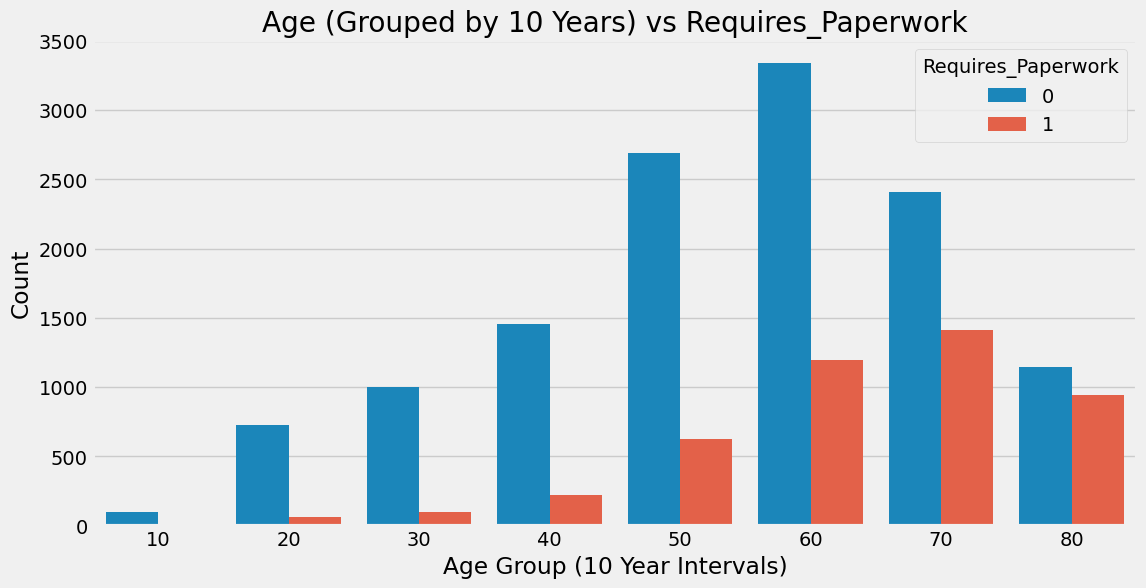

In [12]:
# Create a temporary age group column without modifying the original DataFrame
trainInput_copy = trainInput.copy()
trainInput_copy["Age Group"] = (trainInput_copy["Age"] // 10) * 10  # Group ages into 10-year bins

# Create a single subplot
f, ax = plt.subplots(1, 1, figsize=(12, 6))

# Countplot with age groups
sns.countplot(x="Age Group", hue="Requires_Paperwork", data=trainInput_copy, ax=ax)
ax.set_title("Age (Grouped by 10 Years) vs Requires_Paperwork")
ax.set_xlabel("Age Group (10 Year Intervals)")
ax.set_ylabel("Count")

plt.show()

### Back to Starter

In [13]:
trainData = trainInput.drop(columns = ['Unique_Patient_Encounter_ID',
                                       'Unique_Patient_ID',
                                       'Requires_Paperwork',
                                      'Discharge_Type'])
trainLabels = trainInput.Requires_Paperwork

testData = testInput.drop(columns = ['Unique_Patient_Encounter_ID',
                                     'Unique_Patient_ID',
                                     'Requires_Paperwork',
                                      'Discharge_Type'])
testLabels = testInput.Requires_Paperwork

In [14]:
testLabels.head(1)

0    1
Name: Requires_Paperwork, dtype: int64

## 3. Data Augmentations

In [15]:
!pip install feature-engine

In [31]:
enc = WoEEncoder(add_missing_category=True, add_positive_category=True)

# Apply Weight of Evidence encoding on trainData and testData
trainData, testData = enc.fit_transform(trainData, trainLabels), enc.transform(testData)

TypeError: WoEEncoder.__init__() got an unexpected keyword argument 'add_missing_category'

### 3.1. Treat Missing Values

Before starting the data augmentations, we need to check if we have any columns with missing values. If so, we need to process them first:

In [ ]:
trainData.columns[trainData.isnull().any()].tolist()

In [ ]:
testData.columns[testData.isnull().any()].tolist()

This column captures the previous discharge type if known. Given that many patients may not have a previous discharge status, or their previous discharge could be related to years ago, we just replace the missing values under this column with "Unkown":

In [20]:
from feature_engine.imputation import CategoricalImputer

imp = CategoricalImputer(imputation_method = 'missing',
                            fill_value = "Unknown")

trainData, testData = imp.fit_transform(trainData), imp.transform(testData)

In [ ]:
trainData.Previous_Discharge_Type.value_counts()

In [ ]:
testData.Previous_Discharge_Type.value_counts()

### 3.2. Treat Rare Categories

In [ ]:
from feature_engine.encoding import RareLabelEncoder
#.1
enc = RareLabelEncoder(tol=0.04, n_categories = 2)

trainData, testData = enc.fit_transform(trainData), enc.transform(testData)

In [ ]:
trainData.Previous_Discharge_Type.value_counts()

### 3.3. Drop Psudo-Constant Features (Small Variation)

In [ ]:
from feature_engine.selection import DropConstantFeatures
#.95
con = DropConstantFeatures(tol=.95)

trainData, testData = con.fit_transform(trainData), con.transform(testData)

In [ ]:
trainData.shape

### 3.4. Drop Correlated Columns

In [ ]:
from feature_engine.selection import SmartCorrelatedSelection
#.4
sc = SmartCorrelatedSelection(threshold = .65)

trainData, testData = sc.fit_transform(trainData), sc.transform(testData)

In [ ]:
trainData.shape

### 3.5. Treat Outliers

In [ ]:
from feature_engine.outliers import Winsorizer

out = Winsorizer(tail = "both")

trainData, testData = out.fit_transform(trainData), out.transform(testData)

### 3.6. Remove the Remaining Redundant Features

Given that we have 800+ predictors in this data, we start with removing redundant features to decrease the number of predictors:

In [ ]:
%%time
from feature_engine.selection import SelectByInformationValue
#.05
cor = SelectByInformationValue(threshold = .05)

trainData, testData = cor.fit_transform(trainData,trainLabels), cor.transform(testData)

In [ ]:
trainData.shape

### 3.7. Encode the Categorical Features

In [22]:
trainData.select_dtypes('object')

,Sex,Marital_Status,Payment_Class,Previous_Discharge_Type
0,Female,Single,Medicare Replacement,Unknown
1,Male,Divorced,Do not use,Unknown
2,Male,Married,Medicare Managed Care,Unknown
3,Female,Married,Medicare Replacement,Unknown
4,Female,Married,Medicare,Skilled Nursing Facility (SNF)
...,...,...,...,...
17430,Male,Married,Grant,Unknown
17431,Female,Widowed,Medicare,Unknown
17432,Female,Married,Medicare,Unknown
17433,Female,Married,Blue Shield,Unknown


In [23]:
trainData.Marital_Status.unique()

array(['Single', 'Divorced', 'Married', 'Widowed', 'Legally Separated',
       'Other'], dtype=object)

In [24]:
from feature_engine.encoding import WoEEncoder

enc = WoEEncoder()

trainData, testData = enc.fit_transform(trainData,trainLabels), enc.transform(testData)

ValueError: During the WoE calculation, some of the categories in the following features contained 0 in the denominator or numerator, and hence the WoE can't be calculated: Marital_Status, Previous_Discharge_Type.

In [ ]:
trainData.Marital_Status.unique()

## 4. Train/ Evaluate The Classifier

In [ ]:
xgb = XGBClassifier(random_state=0)
xgb.fit(trainData, trainLabels)

In [ ]:
predictedProbabilities = xgb.predict_proba(testData)
predictedLabels = xgb.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)
#Benchmark 94.5

In [ ]:
plot_conf_mat(xgb, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

## 4.1 AutoML

In [ ]:
# !pip install mljar-supervised

In [ ]:
# from supervised.automl import AutoML

In [ ]:
#%%capture --no-display
#aml = AutoML(model_time_limit = 50,
                     #eval_metric="auc",
                     #algorithms=["CatBoost", "LightGBM", "Xgboost"],
                     #validation_strategy={
        #"validation_type": "kfold",
        #"k_folds": 5,
        #"shuffle": False,
        #"stratify": True,
   # }
  #                  )

#aml.fit(trainData, trainLabels)

In [ ]:
#aml.report()

## 4.2 Catboost

In [ ]:
%pip install catboost

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(random_seed=0, verbose=0)  
cat.fit(trainData, trainLabels)

In [ ]:
predictedProbabilities = cat.predict_proba(testData)
predictedLabels = cat.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)
#Benchmark 94.5

In [ ]:
plot_conf_mat(cat, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

## 4.3 LightGBM

In [ ]:
import lightgbm as lgb
# Rename columns to remove special characters
trainData.columns = [col.replace(" ", "_").replace(",", "_") for col in trainData.columns]

# Initialize and train the LightGBM model
lgb = lgb.LGBMClassifier(random_state=0)
lgb.fit(trainData, trainLabels)


In [ ]:
predictedProbabilities = lgb.predict_proba(testData)
predictedLabels = lgb.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)
#Benchmark 94.5

In [ ]:
plot_conf_mat(lgb, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

## 5. Catboost Optuna

In [ ]:
%pip install Optunahub

In [ ]:
import os
import pickle
import optuna

# File name for the saved model
filename = "final_catboost.sav"

# Check if the model file exists
if os.path.exists(filename):
    print(f"'{filename}' found. Loading the model and skipping training...")
    with open(filename, "rb") as file:
        loaded_model = pickle.load(file)
    print("Model loaded successfully. You are now ready to analyze.")
else:
    print(f"'{filename}' not found. Training a new model...")

    # Define objective function for Optuna
    def optimize_auc(trial):
        # Define hyperparameter search space
        param = {
            'iterations': trial.suggest_int('iterations', 50, 500),
            'depth': trial.suggest_int('depth', 2, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 10.0),
            'verbose': 0
        }

        # Train the model
        model = CatBoostClassifier(
            **param,
            random_seed=42,
            eval_metric='AUC',  # Optimize for AUC
            auto_class_weights="Balanced"  # Handles class imbalance automatically
        )
        model.fit(trainData, trainLabels, eval_set=(testData, testLabels), early_stopping_rounds=50, verbose=0)

        # Get predictions (probabilities for AUC)
        predictions = model.predict_proba(testData)[:, 1]

        # Compute AUC
        auc = roc_auc_score(testLabels, predictions)
        return auc

    # Create a study and optimize for AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(optimize_auc, n_trials=200)

    # Get best parameters
    print("Best hyperparameters:", study.best_params)
    best_params = study.best_params

    # Train the final model with best hyperparameters
    loaded_model = CatBoostClassifier(
        **best_params,
        random_seed=42,
        eval_metric='AUC',
        auto_class_weights="Balanced"
    )
    loaded_model.fit(trainData, trainLabels, eval_set=(testData, testLabels), early_stopping_rounds=50, verbose=100)

    # Save the trained model
    with open(filename, "wb") as file:
        pickle.dump(loaded_model, file)
    print(f"Model trained and saved as '{filename}'.")

    # Evaluate the final model
    final_predictions = loaded_model.predict_proba(testData)[:, 1]
    auc = roc_auc_score(testLabels, final_predictions)
    print("Final AUC Score:", auc)


In [ ]:
filename = 'final_catboost.sav'
final_catboost = pickle.load(open(filename, 'rb'))

In [ ]:
#adjust threshold after testing?
predictedProbabilities = final_catboost.predict_proba(testData)
predictedLabels = final_catboost.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)
#Benchmark 94.5

In [ ]:
plot_conf_mat(final_catboost, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [ ]:
testData.shape

## 6. Cost-benefit Analysis

So far, we built a predictive model-xgb (using XGBClassifier). Below, we use cost-benefit analysis to compare xgb and the status quo (no model). But before doing that, we need to determine the costs associated with FP and FN. 

In the case study, we read that it takes about four hours for a social worker to fill out UAI. We also learned that the average hourly rate to compensate the social workers is $18. Hence, the cost of filling out UAI will be:

$$ $18 * 4 = $72 $$

However, if UAI is needed for discharge, the patient needs to wait in the hospital for at least an additional four hours. In the case, we read that each additional day a patient stays in the hospital will cost 2,081 USD. This translates to 86.71 USD per hour. Hence, the additional four-hour stay will cost the hospital 

$$ $86.71 * 4 = $347 $$

If the staff fills out UAI before the discharge ticket is generated, this additional cost would be avoided.  


To sum up, we have the following information based on the case study and the data files in this notebook:

* Cost of each additional day in hospital: $2,081

* Cost of each additional hour in hospital: $86.71

* Time it takes to fill out UAI: 4 hours

* Social workers' hourly rate: $18

* Cost of filling out UAI: $72

* Additional hospital cost if UAI is completed after discharge recommendation triggered: $347

* Annual number of admitted patients: 28,539 

* Number of patients in testData: 5,812


Using this information, we can go ahead and conduct cost-benefit analysis. First, we estimate the cost or savings per cell in the confusion matrix:

|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | No cost      | 72 USD additional cost  |
| Actual 1   | 347 USD additional cost | No cost    |

Before comparing the two models, let's estimate the costs associated with two naive models: 

#### Scenario 1: No predictive model- predict no one needs UAI:

This is the status quo. In this scenario, every UAI will be filled only when the discharge recommendation is triggered. This is the equivalent of a naive model that predicts no one needs UAI. In this scenario, the confusion matrix will look like this:

|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | 4,455       | 0   |
| Actual 1   | 1,357       | 0      |

The cost associated with this model will be equal to:

In [ ]:
1357 * 347

This is the cost associated with 5,812 patients in testData. To estimate the total annual cost, we have to extrapolate this value for 28,539 annual patients:

In [ ]:
1357 * 347 * (28539/5812)

We can see that the status quo costs about 2.3M USD for UVA Hospital. 

#### Scenario 2: No predictive model- predict everyone needs UAI:

In this scenario, the hospital staff members fill out UAI for every patient before the discharge recommendation is triggered:

|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | 0       | 4,455   |
| Actual 1   | 0       | 1,357      |

The cost will be equal to:

In [ ]:
(4455 * 72) * (28539/5812)

In [ ]:
FN_cost = 347
FP_cost = 72
FN_FP_ratio = 347/72
print("False Negative False Positive Ratio: {:.2f}".format(FN_FP_ratio))

If UVA Hospital proactively fills out UAI for every patient, the cost will be about 700K USD, which is 1M USD less than the status quo.

#### Scenario 3: Predictive model- XGB Classifier:

Let's print the confusion matrix one more time:

## 6.1 Adjust Threshold

In [ ]:
def plot_conf_mat(clf, X_test, y_test, threshold=0.25):
    # Get predicted probabilities for the positive class
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Apply the threshold to convert probabilities to binary predictions
    y_pred = (y_proba >= threshold).astype(int)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix with threshold={threshold}')
    plt.show()

In [ ]:
plot_conf_mat(final_catboost, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

The cost will be equal to:

In [ ]:
#Catboost Optuna
FP_Cost = (675 * 72) * (28539/5812)
FN_Cost = (124 * 347) * (28539/5812)

#print("False positive costs: ${:.2f}".format(FP_Cost))
#print("False negative costs: ${:.2f}".format(FN_Cost))
print("Total Cost = ${:.2f}".format(FP_Cost + FN_Cost))

In [ ]:
Scenario_1_3 = 2312184.408293186 - 449926.27185134206
print("Savings compared to scenario 1: ${:.2f}".format(Scenario_1_3))

In [ ]:
Scenario_2_3 = 1575046.3936682725 - 449926.27185134206
print("Savings compared to scenario 2: ${:.2f}".format(Scenario_2_3))

In [ ]:
FP_cost = 72
FN_cost = 347
FN_FP_ratio = 347/72
print("Ratio: {:.2f}".format(FN_FP_ratio))

In [ ]:
#Catboost Optuna
CFP = 675
CFN = 124
Cat_FP_FN = 675+124
print("Total false cases:",Cat_FP_FN)42

In [ ]:
#Original
FP_Cost = (296 * 72) * (28539/5812)
FN_Cost = (248 * 347) * (28539/5812)
print("${:.2f}".format(FP_Cost))
print("${:.2f}".format(FN_Cost))
print("Total cost = ${:.2f}.".format(FP_Cost + FN_Cost))

In [ ]:
#Original
OFP = 296
OFN = 248
Orig_FP_FN = OFP + OFN
print("Total false cases:",Orig_FP_FN)

In [ ]:
#Cat-Orig
Diff = Cat_FP_FN - Orig_FP_FN
DiffFN = CFP - OFP
DiffFP = CFN - OFN
print("CatBoost misclassified", Diff, "additional cases compared to the starter.")
print("CatBoost misclassified", DiffFN,"false negatives compared to the starter.")
print("CatBoost classified", abs(DiffFP), "more false positives compared to the starter.")

Let's compare this value with the previous two values:

## 7. Your Task:

Use XGboost, LightGBM, CatBoost, or any other algorithm you prefer to build a cost-sensitive model. Then compare the savings of that model with scenario 1. 

This is a case competition. So please enter the highest savings into the leaderboard. The link will be shared in class. The highest amount of saving is the metric for this competition. 

**Tip- To be able to save more, you can:**

+ improve the predictive performance of the model (its ability to separate 0s and 1s). This can be done using different pre-processing steps/ methods, a different algorithm, and/ or optimizing the hyperparameters of the algorithm.

+ use different class weights as you train your models. 

+ decide/ change which matric (e.g., AUC, recall, accuracy, ...) should be used when optimizing the hyperparameters.

**Please enter the savings amount in leaderboardhq using the link provided below:**

Team 1:	https://leaderboardhq.com/addscore/lgfnu00r/sj4ga7s4

Team 2:	https://leaderboardhq.com/addscore/lgfnu00r/aiy6brr1

Team 3:	https://leaderboardhq.com/addscore/lgfnu00r/5yoe1232

Team 4:	https://leaderboardhq.com/addscore/lgfnu00r/pd5rdv0r

Team 5:	https://leaderboardhq.com/addscore/lgfnu00r/hakaexap

Team 6:	https://leaderboardhq.com/addscore/lgfnu00r/3gcta4a7

Team 7:	https://leaderboardhq.com/addscore/lgfnu00r/o0lnar5i

Team 8:	https://leaderboardhq.com/addscore/lgfnu00r/ygbw1zn0

Team 9:	https://leaderboardhq.com/addscore/lgfnu00r/b0vi8t7z

Team 10: https://leaderboardhq.com/addscore/lgfnu00r/27voyrnb

Team 11: https://leaderboardhq.com/addscore/lgfnu00r/2br86kl8

Team 12: https://leaderboardhq.com/addscore/lgfnu00r/angfcx56

### Rules:
1- Please use trainInput solely for training your models and testInput solely for testing them.

2- The confusion matrix in your solution should be based on testInput. Therefore, the costs are calculated based on the confusion matrix for testInput.

3- The evaluation metric is the total saving (higher is better). 

4- If you submit more than one time, the leaderboard will add the value of the second submission to the first submission. Therefore, if you want to submit more than once, please submit the negative value of your first submission to make the score zero. Then submit your new score. 

5- You can see the entire leaderboard here: https://leaderboardhq.com/lgfnu00r


Admin link (for Reza): https://leaderboardhq.com/cj4i6l79